<font size=18>Cluster analyses of the image embeddings</font>

---

In this notebook we analyze the (dis-)similarity of the structure of the different gene perturbation embeddings for a selected subset of impactful gene perturbation conditions.

Namely, we will assess the pair-wise co-clustering of the following gene perturbation embedding candidates:
- JUMP image embeddings
- JUMP image embeddings after normalizing them with respect to the batch specific controls (i.e. batch centering)
- JUMP image embeddings after iterative null space projection (INSP)
- JUMP morphological profiles
- JUMP morphological profiles after batch-centering
- JUMP morphological profiles after INSP
- Rohban image embeddings
- Rohban morphological profiles
- CMap signatures
- Regulatory gene embeddings (using the CMap structure)

To assess the co-clustering, we will identify the optimal number of clusters to separate the embeddings of each candidate in and compute a bootstrap p-value for the mutual information of the clustering of any pair of the embeddings.

---

# Environmental setup

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse
from scipy.spatial.distance import squareform, pdist
import matplotlib as mpl
import pickle
import os

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

mpl.rcParams["figure.dpi"] = 600

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def run_cc_test(cluster_sol1, cluster_sol2, b=1000, score="mi", random_state=1234):
    np.random.seed(random_state)
    cc_score = compute_cc_score(cluster_sol1, cluster_sol2, score=score)
    perm_cc_scores = []
    for i in tqdm(range(b)):
        cluster_sol1_perm = np.random.permutation(cluster_sol1)
        cluster_sol2_perm = np.random.permutation(cluster_sol2)
        perm_cc_score = compute_cc_score(
            cluster_sol1_perm, cluster_sol2_perm, score=score
        )
        perm_cc_scores.append(perm_cc_score)
    perm_cc_scores = np.array(perm_cc_scores)
    return {
        "cc_score": cc_score,
        "perm_cc_scores": perm_cc_scores,
        "pval": np.mean(perm_cc_scores >= (cc_score - 1e-8), axis=0),
    }


<IPython.core.display.Javascript object>

---

# Read in data

We will now read in the required embeddings.

In [3]:
reg_embs = pd.read_csv(
    "../../../data/experiments/rohban/images/embeddings/leave_one_target_out/embeddings/EMPTY/spearman_sol/gae_exp_a1_b0_g1_split_graph_cmap_full_all_nodes/node_embs.csv",
    index_col=0,
)


<IPython.core.display.Javascript object>

In [4]:
emb_dir = "../../../data/experiments/jump/images/embedding/embeddings"

jump_morph_embs = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_morph_embs.csv"), index_col=0
)
jump_morph_embs_bc = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_morph_embs_bc.csv"), index_col=0
)
jump_morph_embs_insp = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_morph_embs_insp.csv"), index_col=0
)

jump_img_embs = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_image_embs.csv"), index_col=0
)
jump_img_embs_bc = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_image_embs_bc.csv"), index_col=0
)
jump_img_embs_insp = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_image_embs_insp.csv"), index_col=0
)

<IPython.core.display.Javascript object>

In [5]:
rohban_img_embs = pd.read_hdf(
    "../../../data/experiments/rohban/images/embeddings/four_fold_cv/fold_0/test_latents.h5"
)

label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
rohban_img_embs.loc[:, "labels"] = np.array(rohban_img_embs.labels.map(label_dict))
rohban_img_embs = rohban_img_embs.groupby("labels").mean()

<IPython.core.display.Javascript object>

In [6]:
morph_profiles = pd.read_csv(
    "../../../data/resources/images/rohban/profiles/nuclei_profiles_hoechst_cleaned.csv",
    index_col=0,
)
rohban_morph_profiles = (
    morph_profiles.groupby("labels").mean().drop(columns=["ImageNumber"])
)
rohban_morph_profiles = rohban_morph_profiles.drop(
    rohban_morph_profiles.filter(regex="_X").columns, axis=1
)
rohban_morph_profiles = rohban_morph_profiles.drop(
    rohban_morph_profiles.filter(regex="_Y").columns, axis=1
)
rohban_morph_profiles = pd.DataFrame(
    StandardScaler().fit_transform(rohban_morph_profiles),
    index=rohban_morph_profiles.index,
    columns=rohban_morph_profiles.columns,
)

<IPython.core.display.Javascript object>

In [7]:
cmap_sigs = pd.read_csv(
    "../../../data/experiments/rohban/gex/cmap/mean_l5_signatures_tmp.csv", index_col=0
)

<IPython.core.display.Javascript object>

---

# Clustering of the different profiles, signatures and embeddings

As a described above, we will now individually obtain the optimal cluster solution for all of the different candidates for our gene perturbation embeddings. To this end, we will look a the Calinski-Harabasz score when clustering the embeddings using complete linkage. Note that we will generally use the euclidean distance to cluster all but the CMap signatures and the regulatory gene embeddings. For the latter we will use the cosine distances which are more meaningful for these cases.

In [8]:
shared_genes = list(
    set(reg_embs.index)
    .intersection(jump_img_embs.index)
    .intersection(rohban_img_embs.index)
    .intersection(cmap_sigs.index)
)
print(sorted(shared_genes))

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDKN1A', 'CREB1', 'DIABLO', 'ELK1', 'ERG', 'FGFR3', 'HRAS', 'IRAK4', 'JUN', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


<IPython.core.display.Javascript object>

---

## JUMP image embeddings



In [9]:
shared_jump_img_embs = jump_img_embs.loc[shared_genes]

<IPython.core.display.Javascript object>

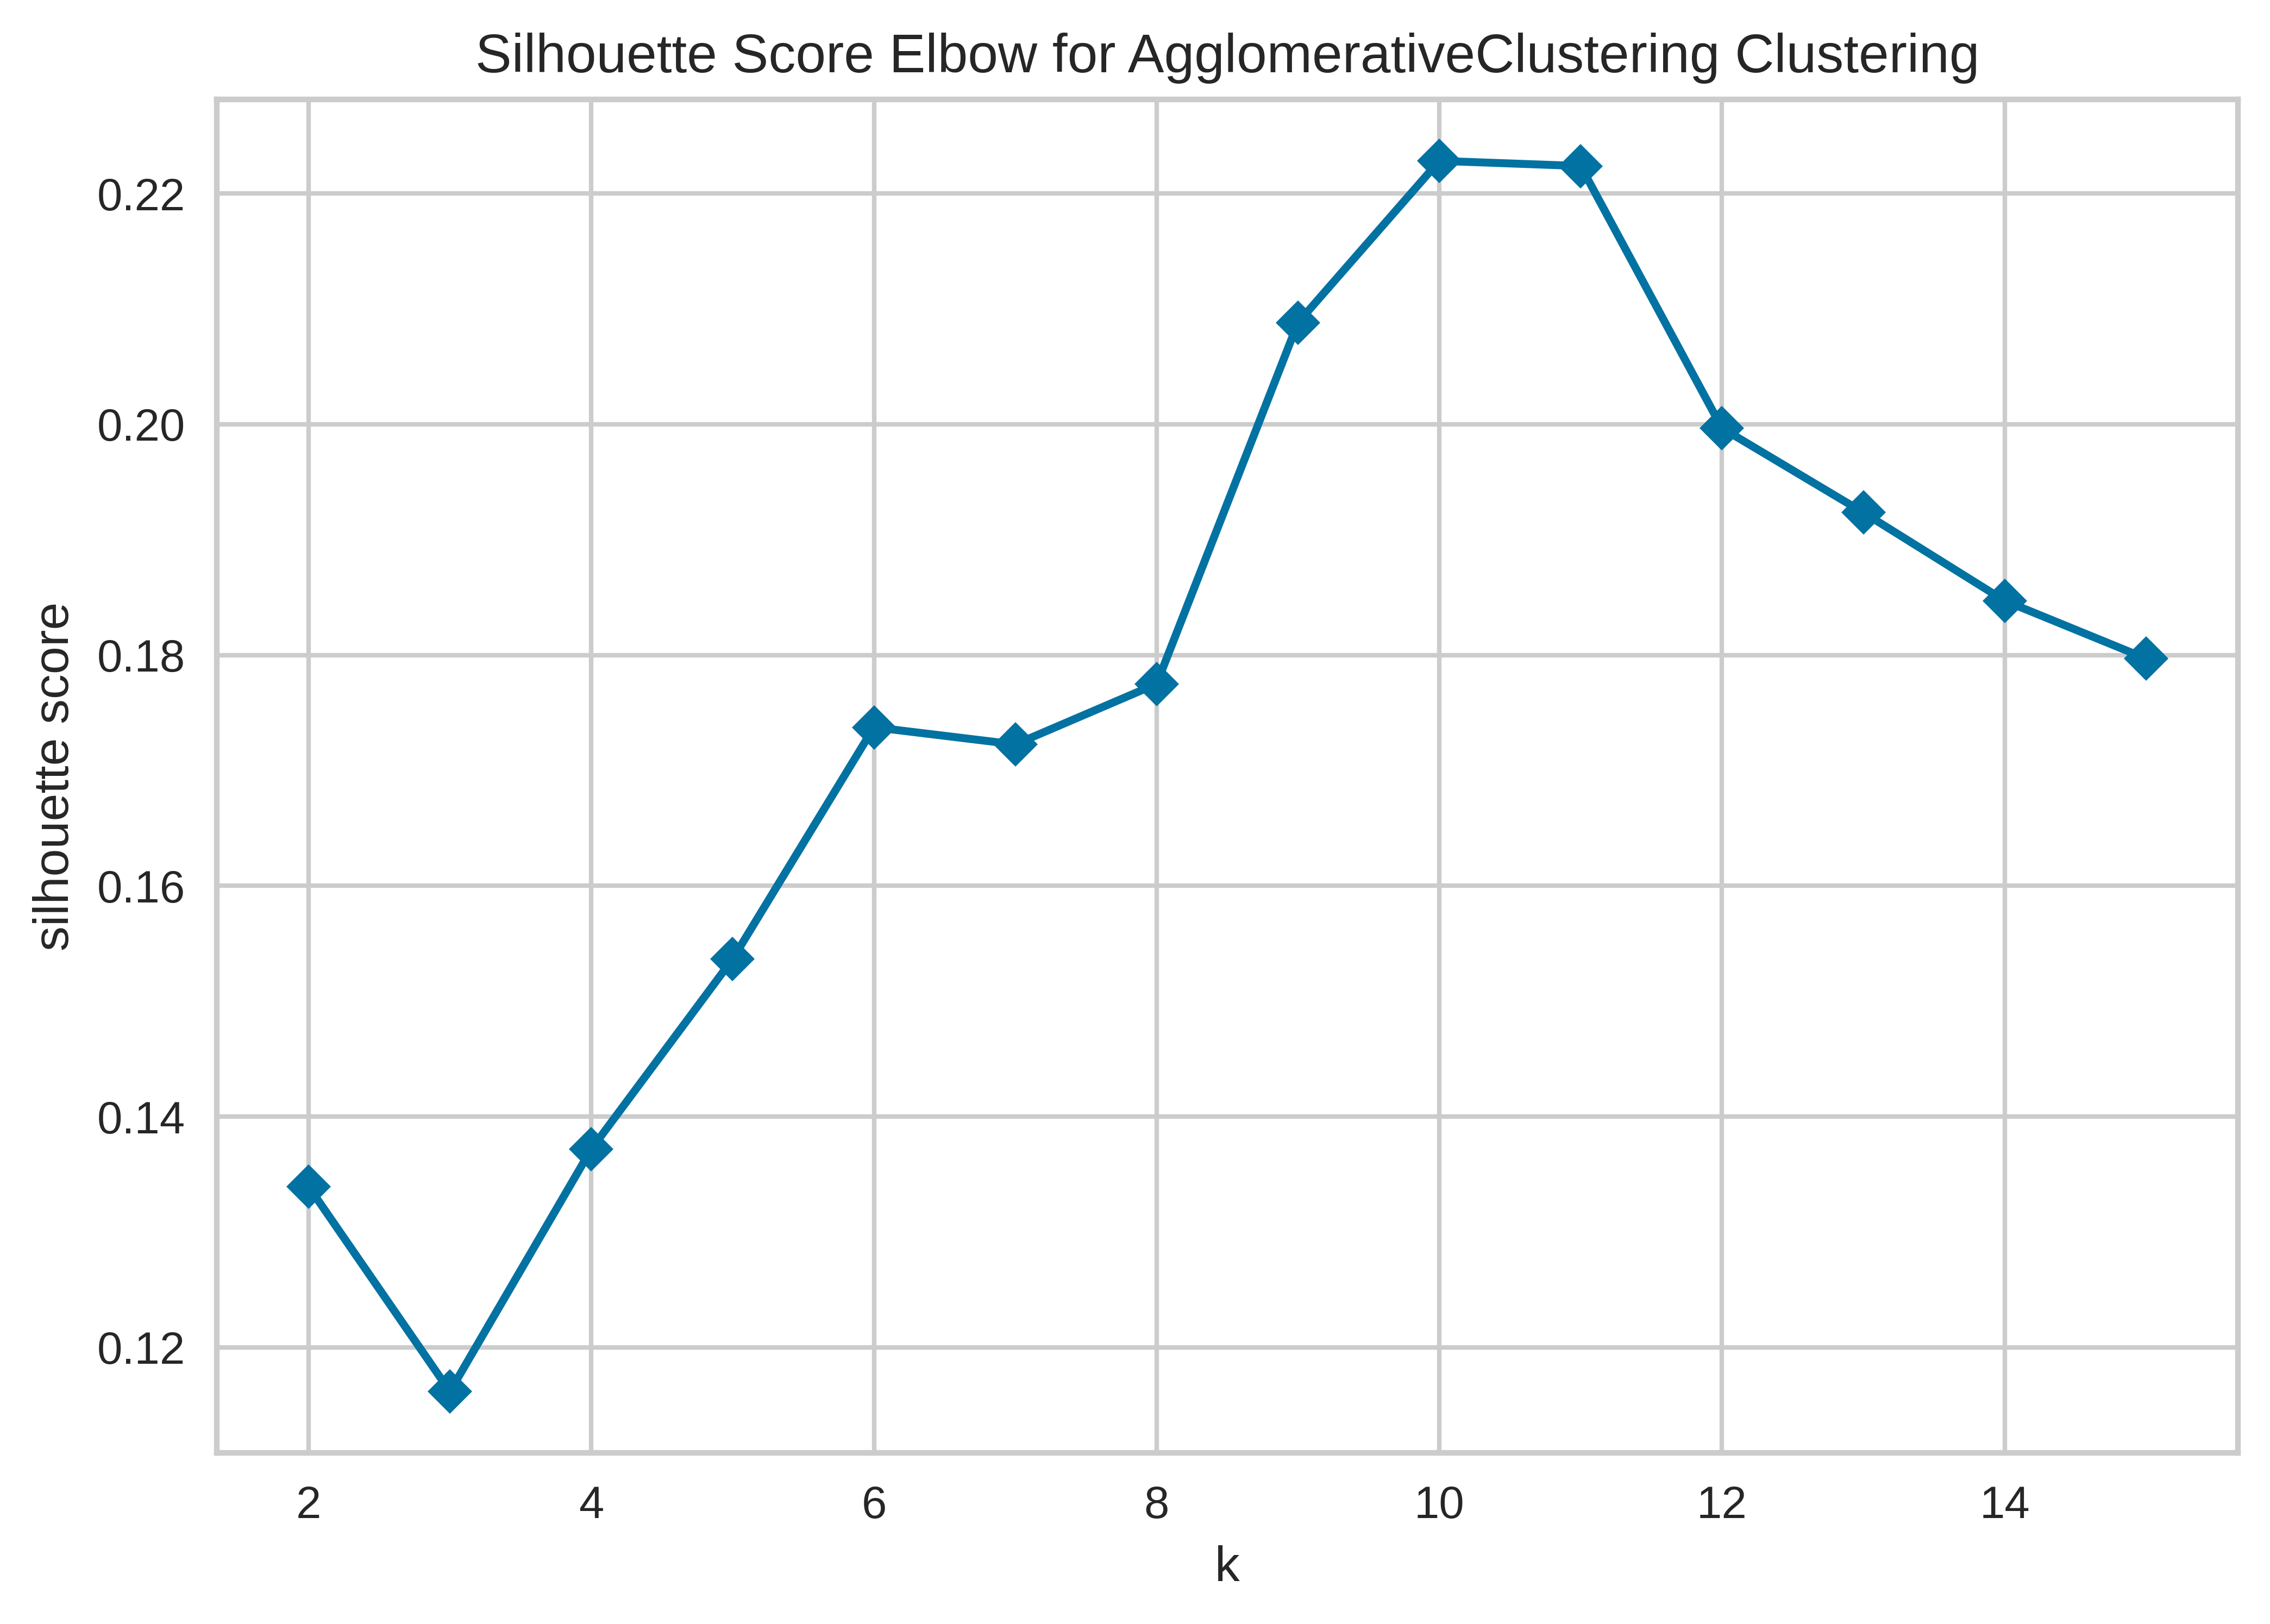

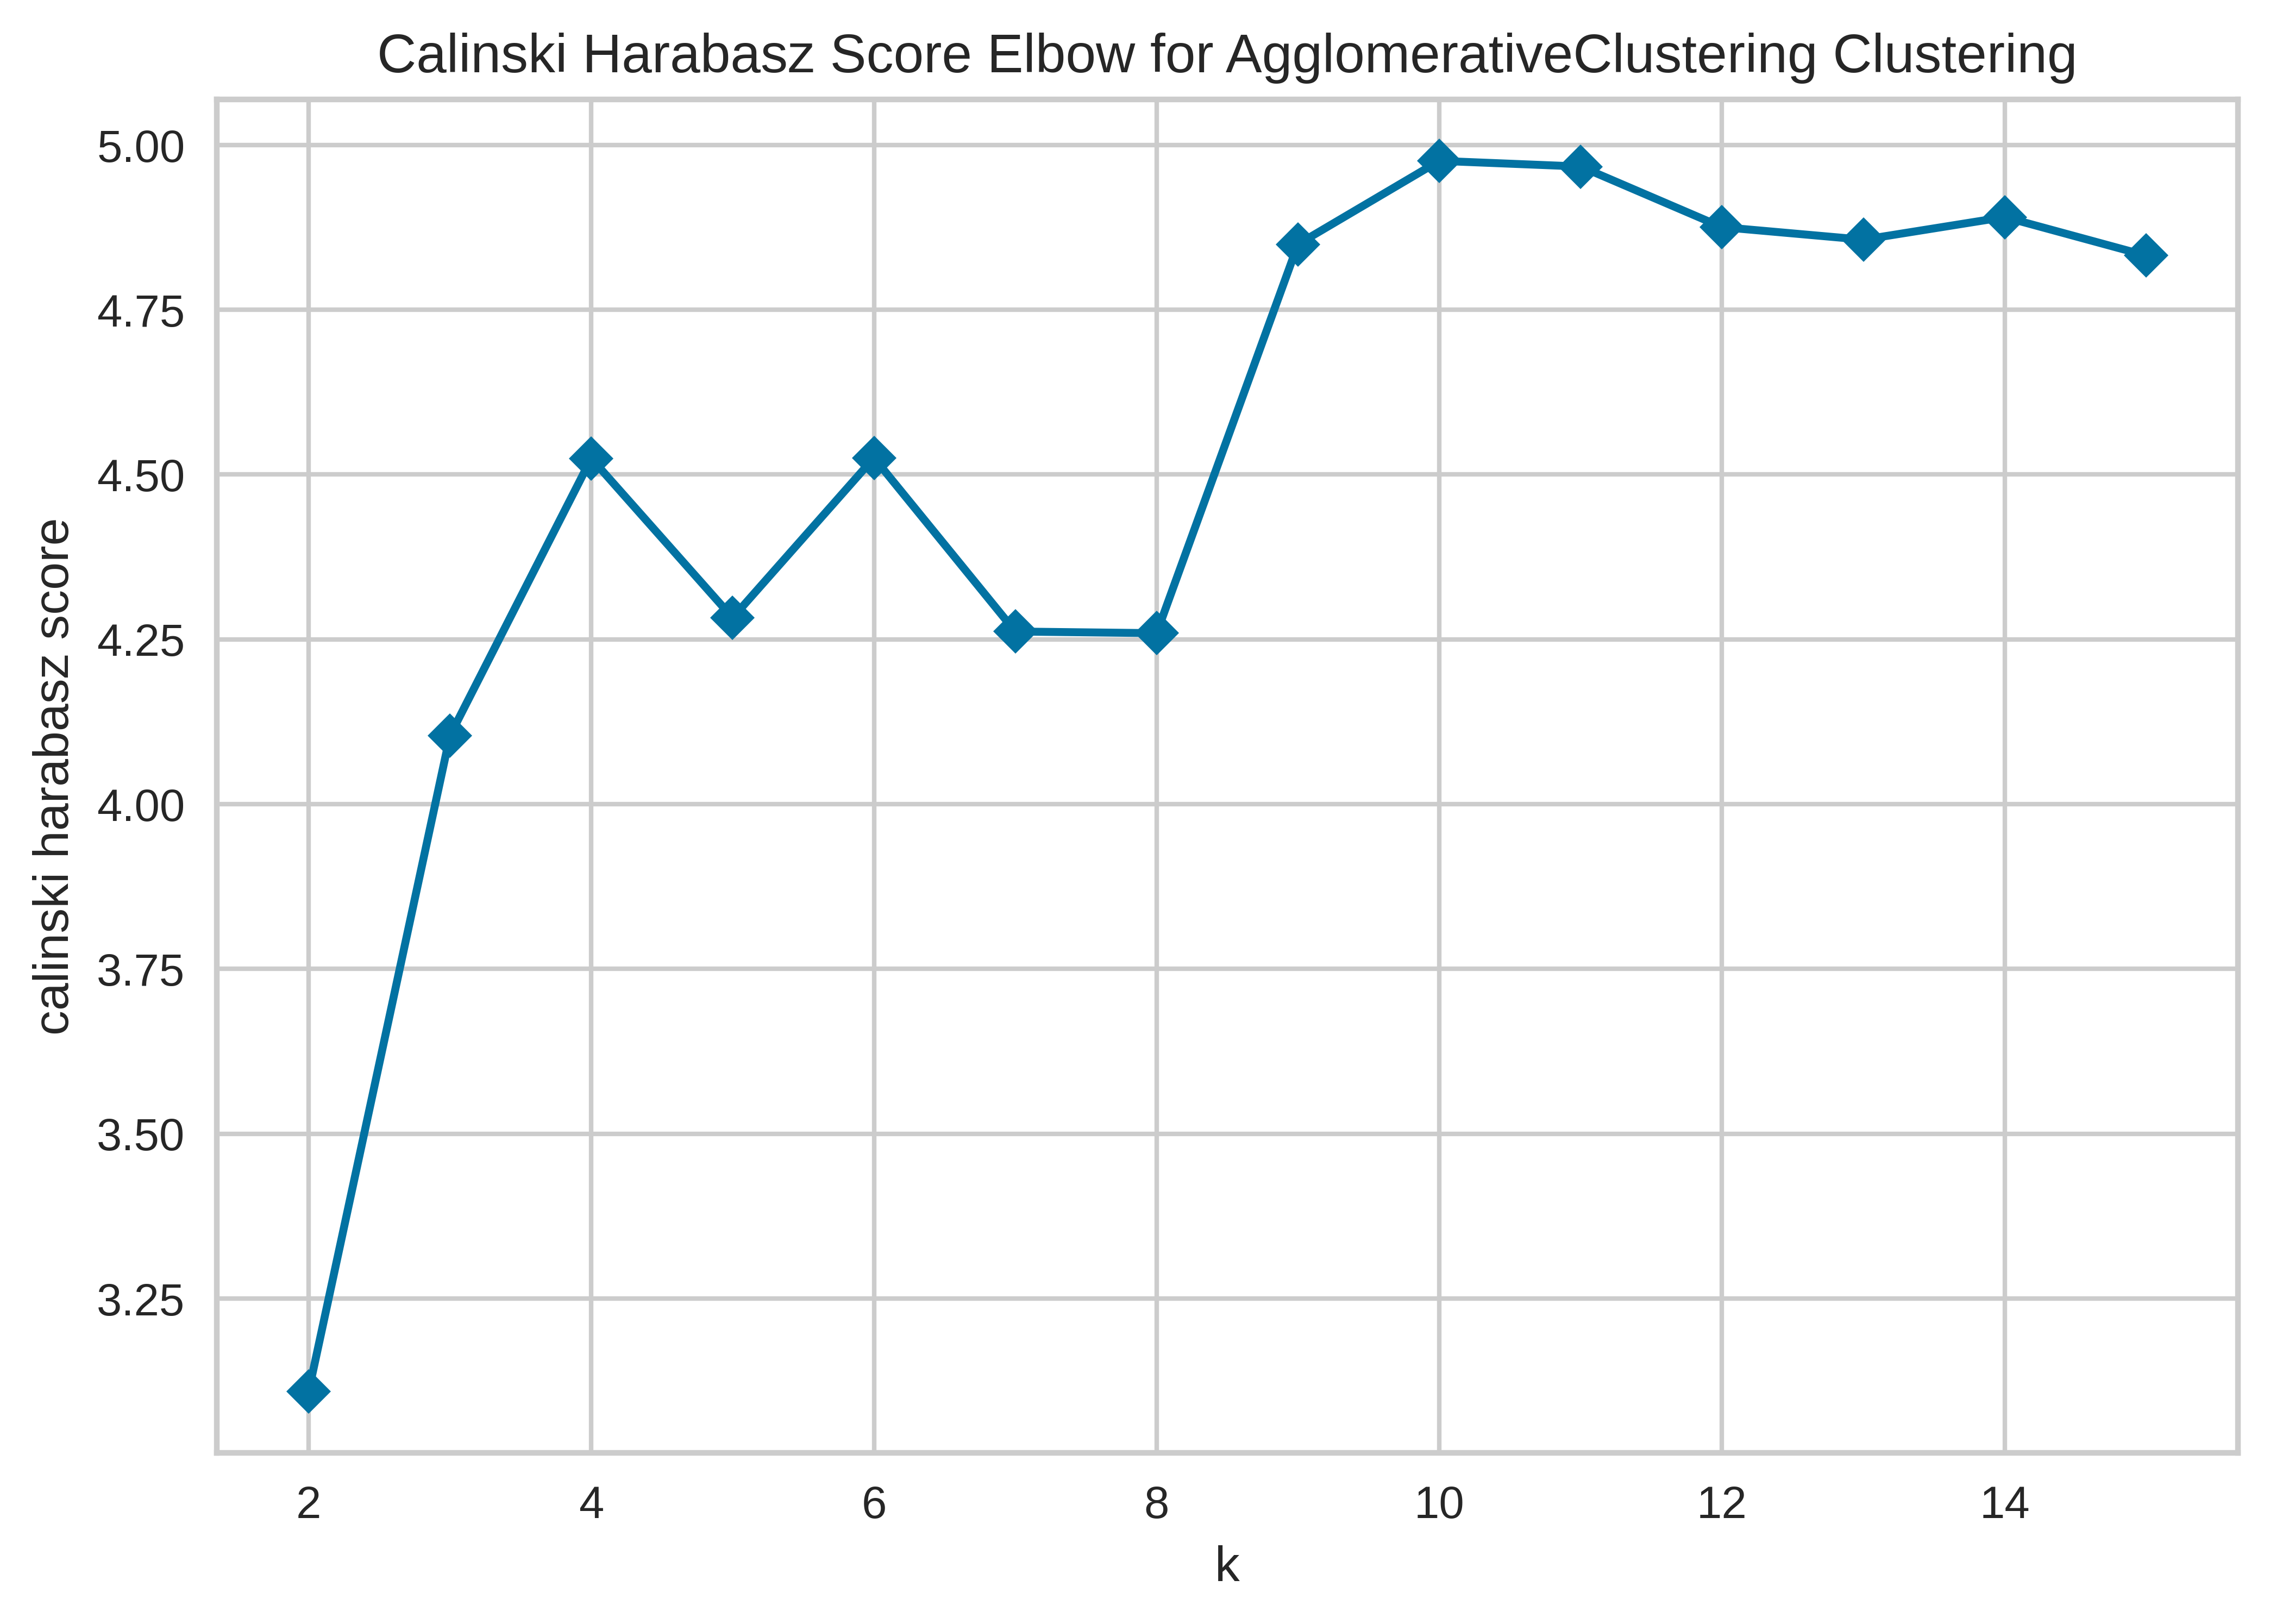

<IPython.core.display.Javascript object>

In [10]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_img_embs)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_img_embs)
ax = visualizer.show()


The optimal number of cluster seems to be 10 for our image-based embeddings. As we have seen before these are likely the different batches.

In [11]:
model = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="complete")
shared_jump_img_embs_cluster_labels = model.fit_predict(shared_jump_img_embs)
shared_jump_img_embs_clusters = pd.DataFrame(
    shared_jump_img_embs_cluster_labels,
    index=shared_jump_img_embs.index,
    columns=["cluster"],
)
shared_jump_img_embs_clusters.head()

cluster
labels         
IRAK4         0
WWTR1         2
SMAD4         2
MAP3K5        7
RHOA          0

<IPython.core.display.Javascript object>

---

## Batch-centered JUMP image embeddings



In [12]:
shared_jump_img_embs_bc = jump_img_embs_bc.loc[shared_genes]

<IPython.core.display.Javascript object>

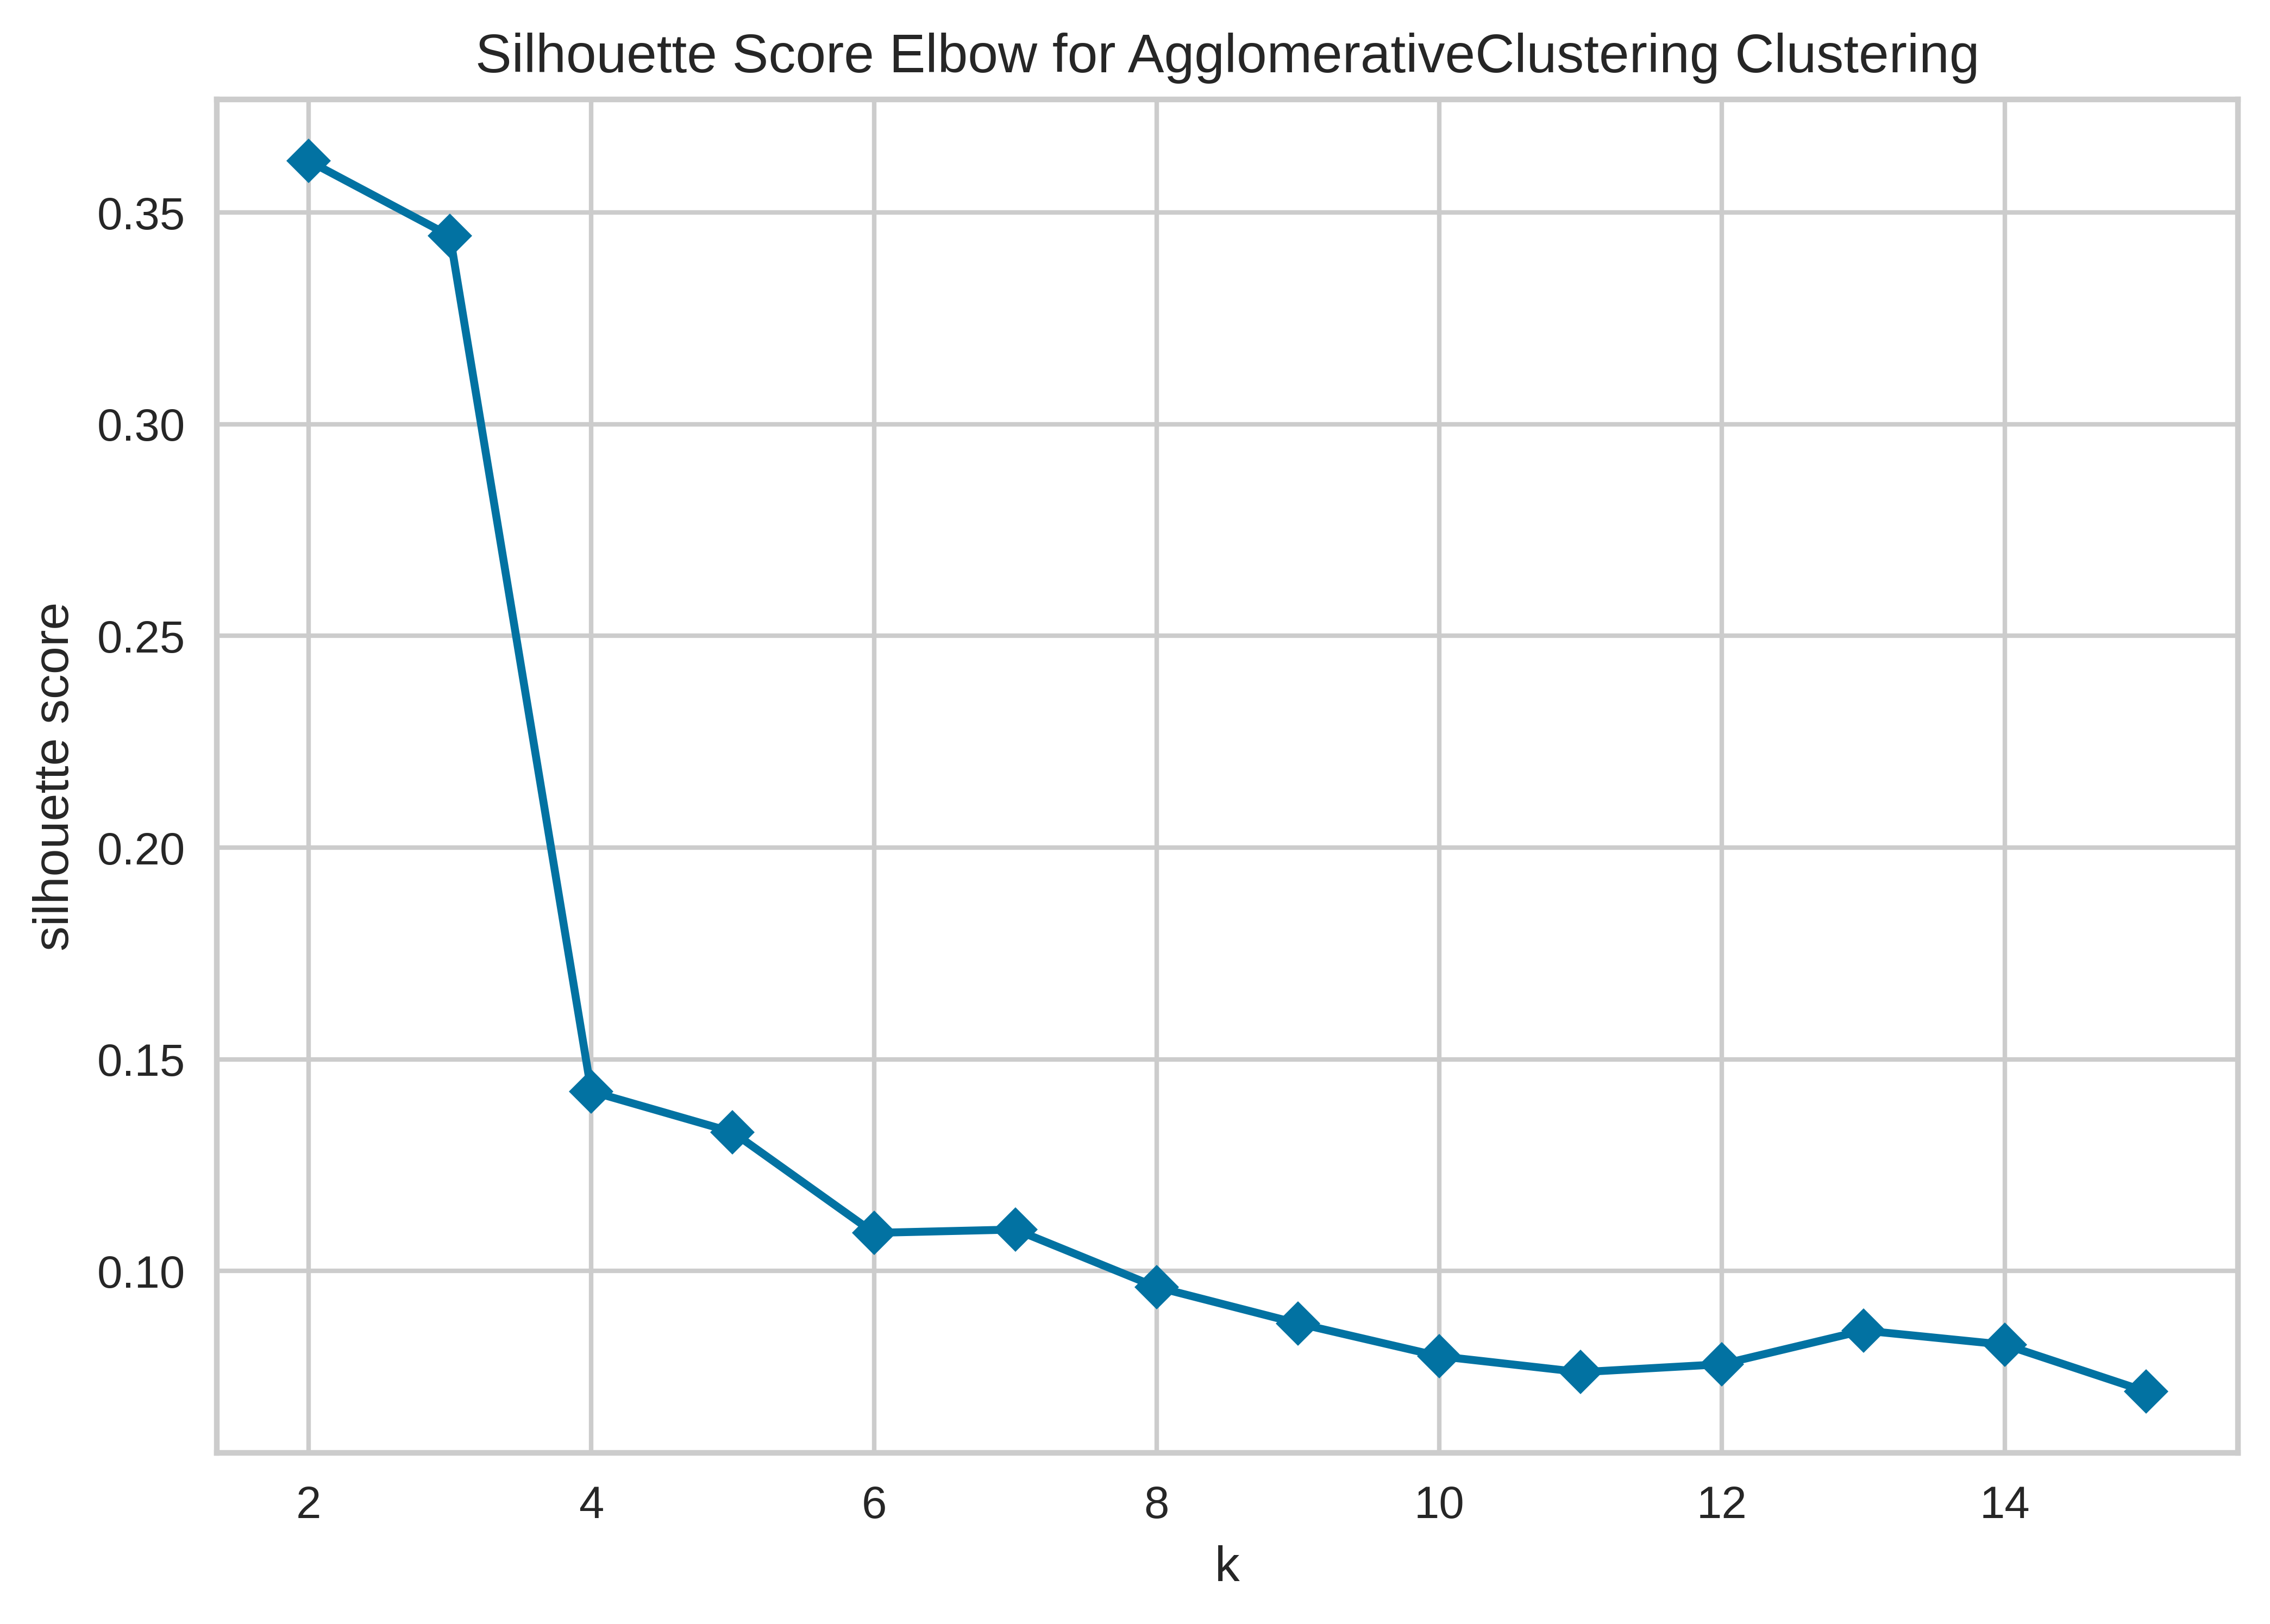

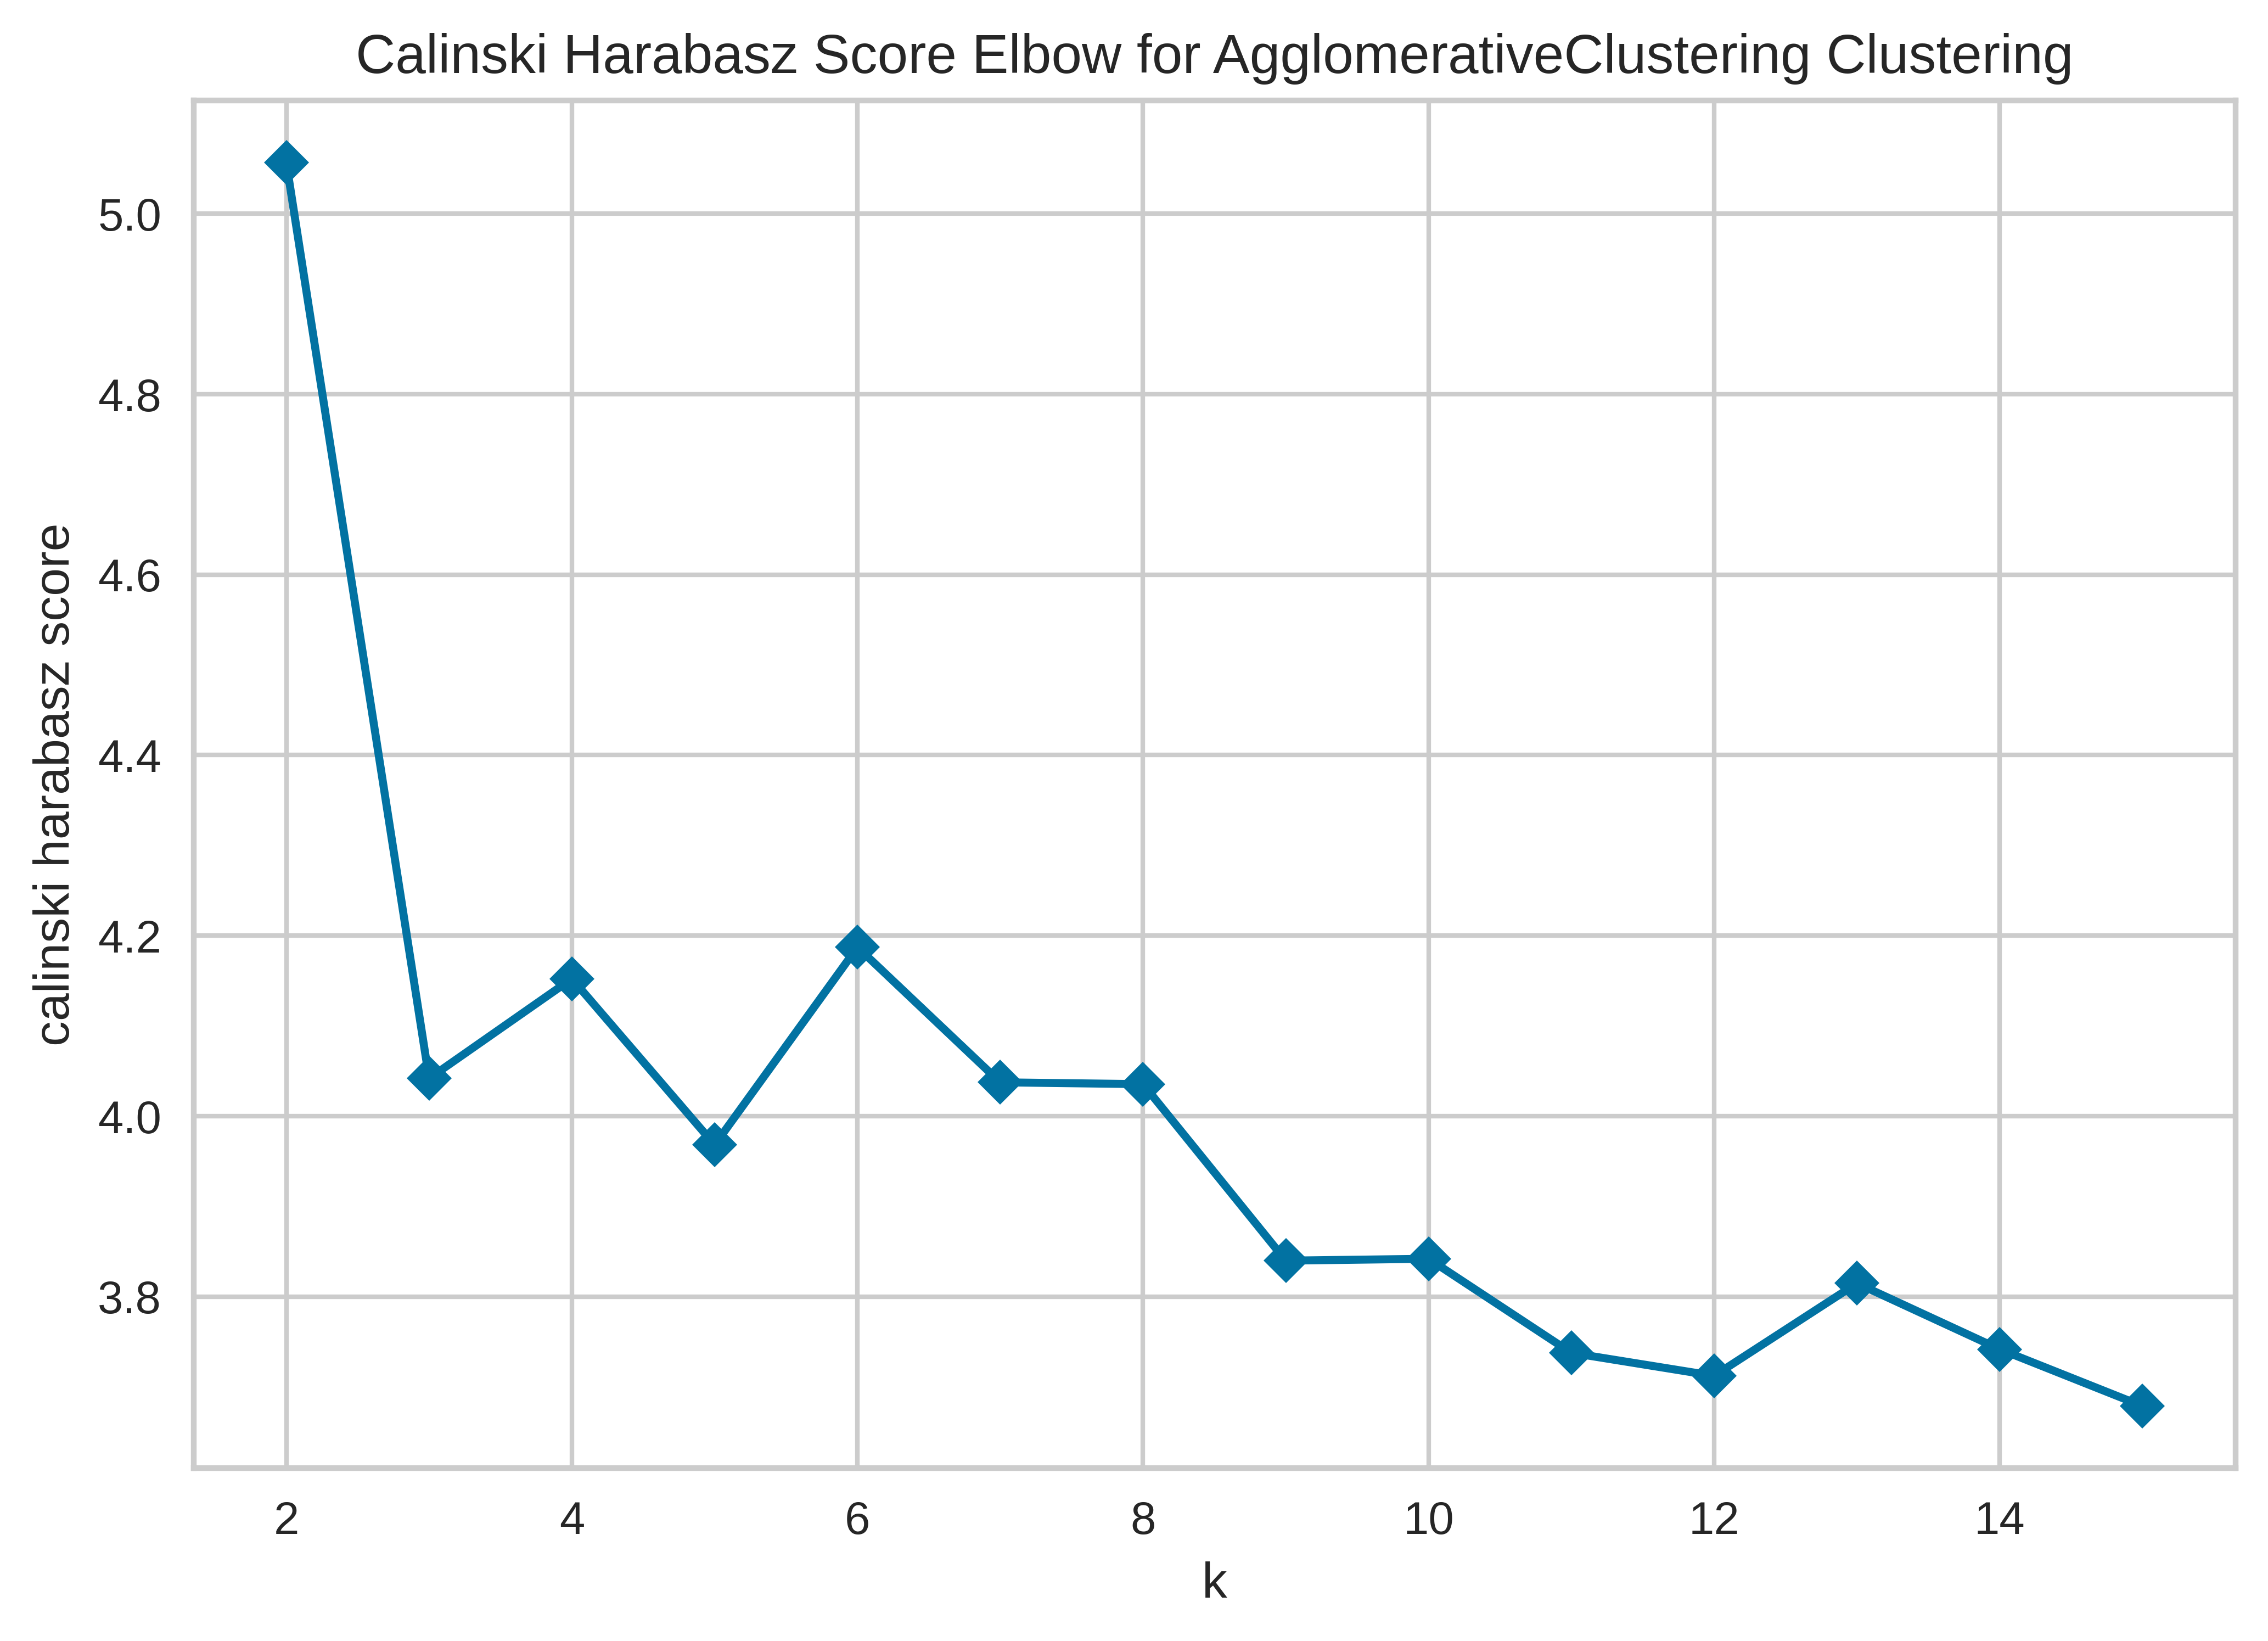

<IPython.core.display.Javascript object>

In [13]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_img_embs_bc)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_img_embs_bc)
ax = visualizer.show()


The optimal number of cluster seems to be 6 for our batch-centered JUMP image-based embeddings.

In [14]:
model = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="complete")
shared_jump_img_embs_bc_cluster_labels = model.fit_predict(shared_jump_img_embs_bc)
shared_jump_img_embs_bc_clusters = pd.DataFrame(
    shared_jump_img_embs_bc_cluster_labels,
    index=shared_jump_img_embs_bc.index,
    columns=["cluster"],
)
shared_jump_img_embs_bc_clusters.head()

cluster
label          
IRAK4         1
WWTR1         1
SMAD4         1
MAP3K5        0
RHOA          1

<IPython.core.display.Javascript object>

---

## INSP-corrected JUMP image embeddings



In [15]:
shared_jump_img_embs_insp = jump_img_embs_insp.loc[shared_genes]

<IPython.core.display.Javascript object>

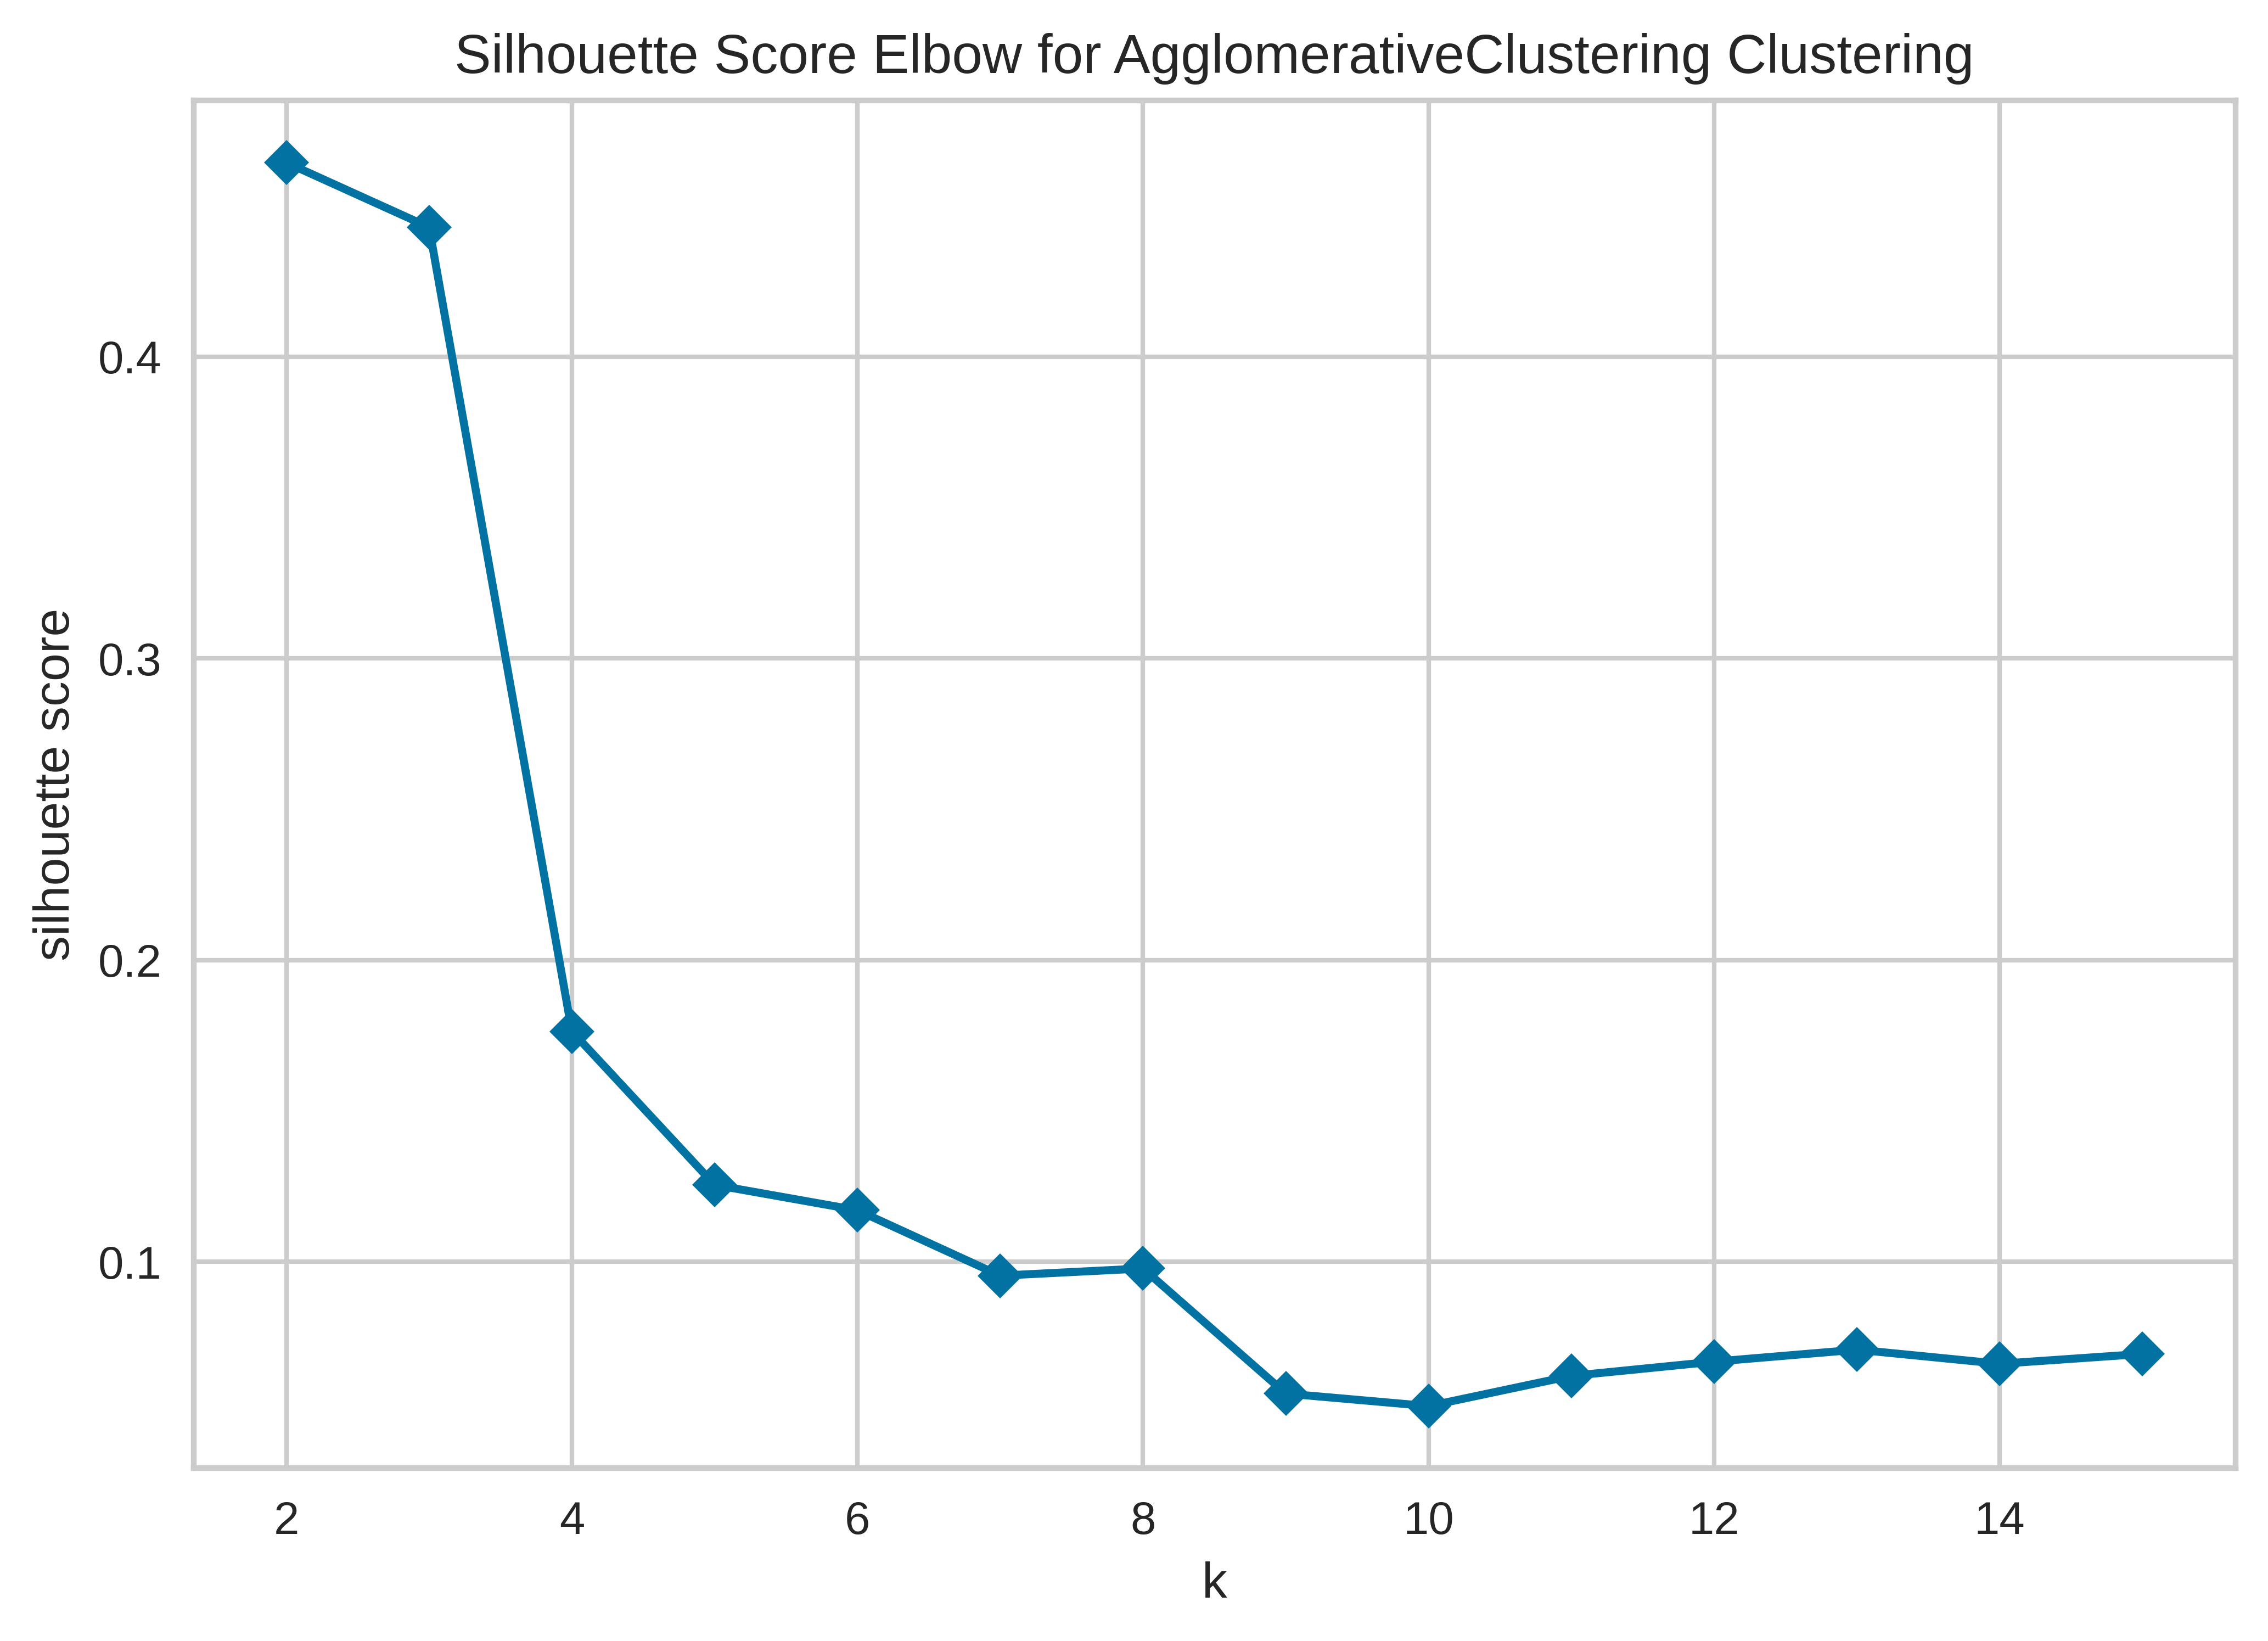

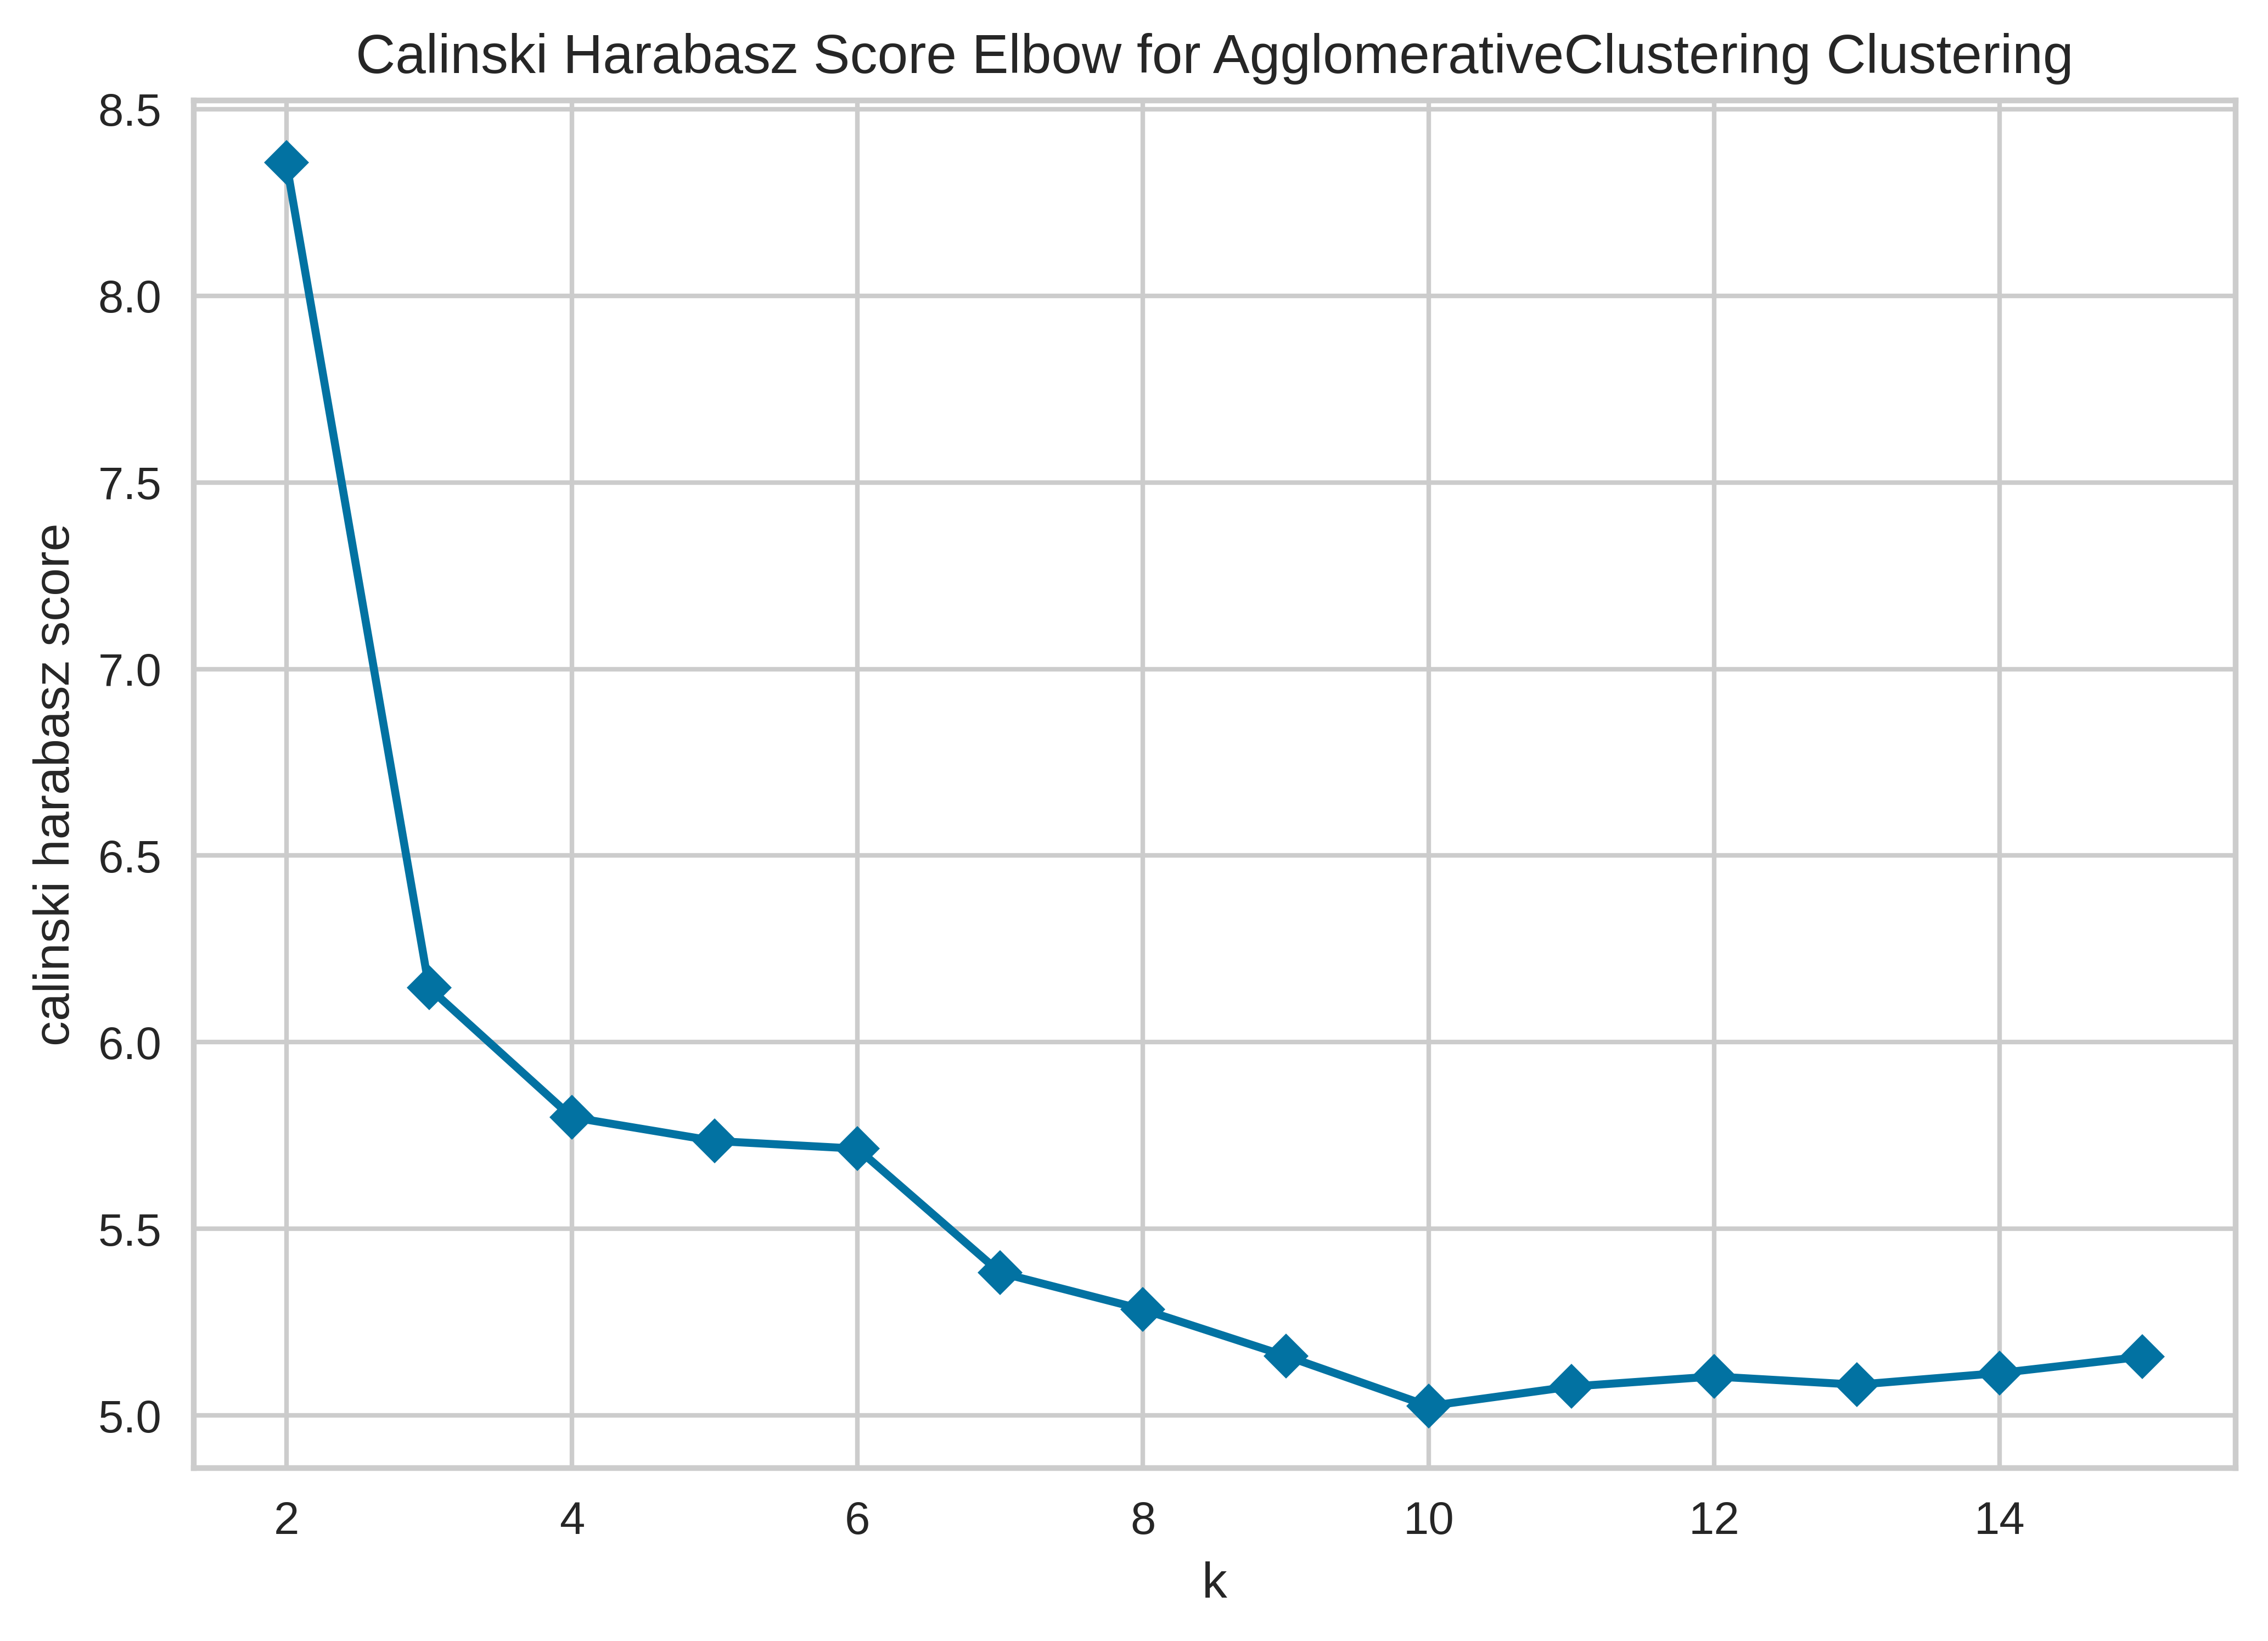

<IPython.core.display.Javascript object>

In [16]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_img_embs_insp)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_img_embs_insp)
ax = visualizer.show()


The optimal number of cluster seems to be 10 for our INSP-corrected JUMP image-based embeddings.

In [17]:
model = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="complete")
shared_jump_img_embs_insp_cluster_labels = model.fit_predict(shared_jump_img_embs_insp)
shared_jump_img_embs_insp_clusters = pd.DataFrame(
    shared_jump_img_embs_insp_cluster_labels,
    index=shared_jump_img_embs_insp.index,
    columns=["cluster"],
)
shared_jump_img_embs_insp_clusters.head()

cluster
label          
IRAK4         3
WWTR1         1
SMAD4         4
MAP3K5        1
RHOA          2

<IPython.core.display.Javascript object>

---

## JUMP morphological profiles



In [18]:
shared_jump_morph_embs = jump_morph_embs.loc[shared_genes]

<IPython.core.display.Javascript object>

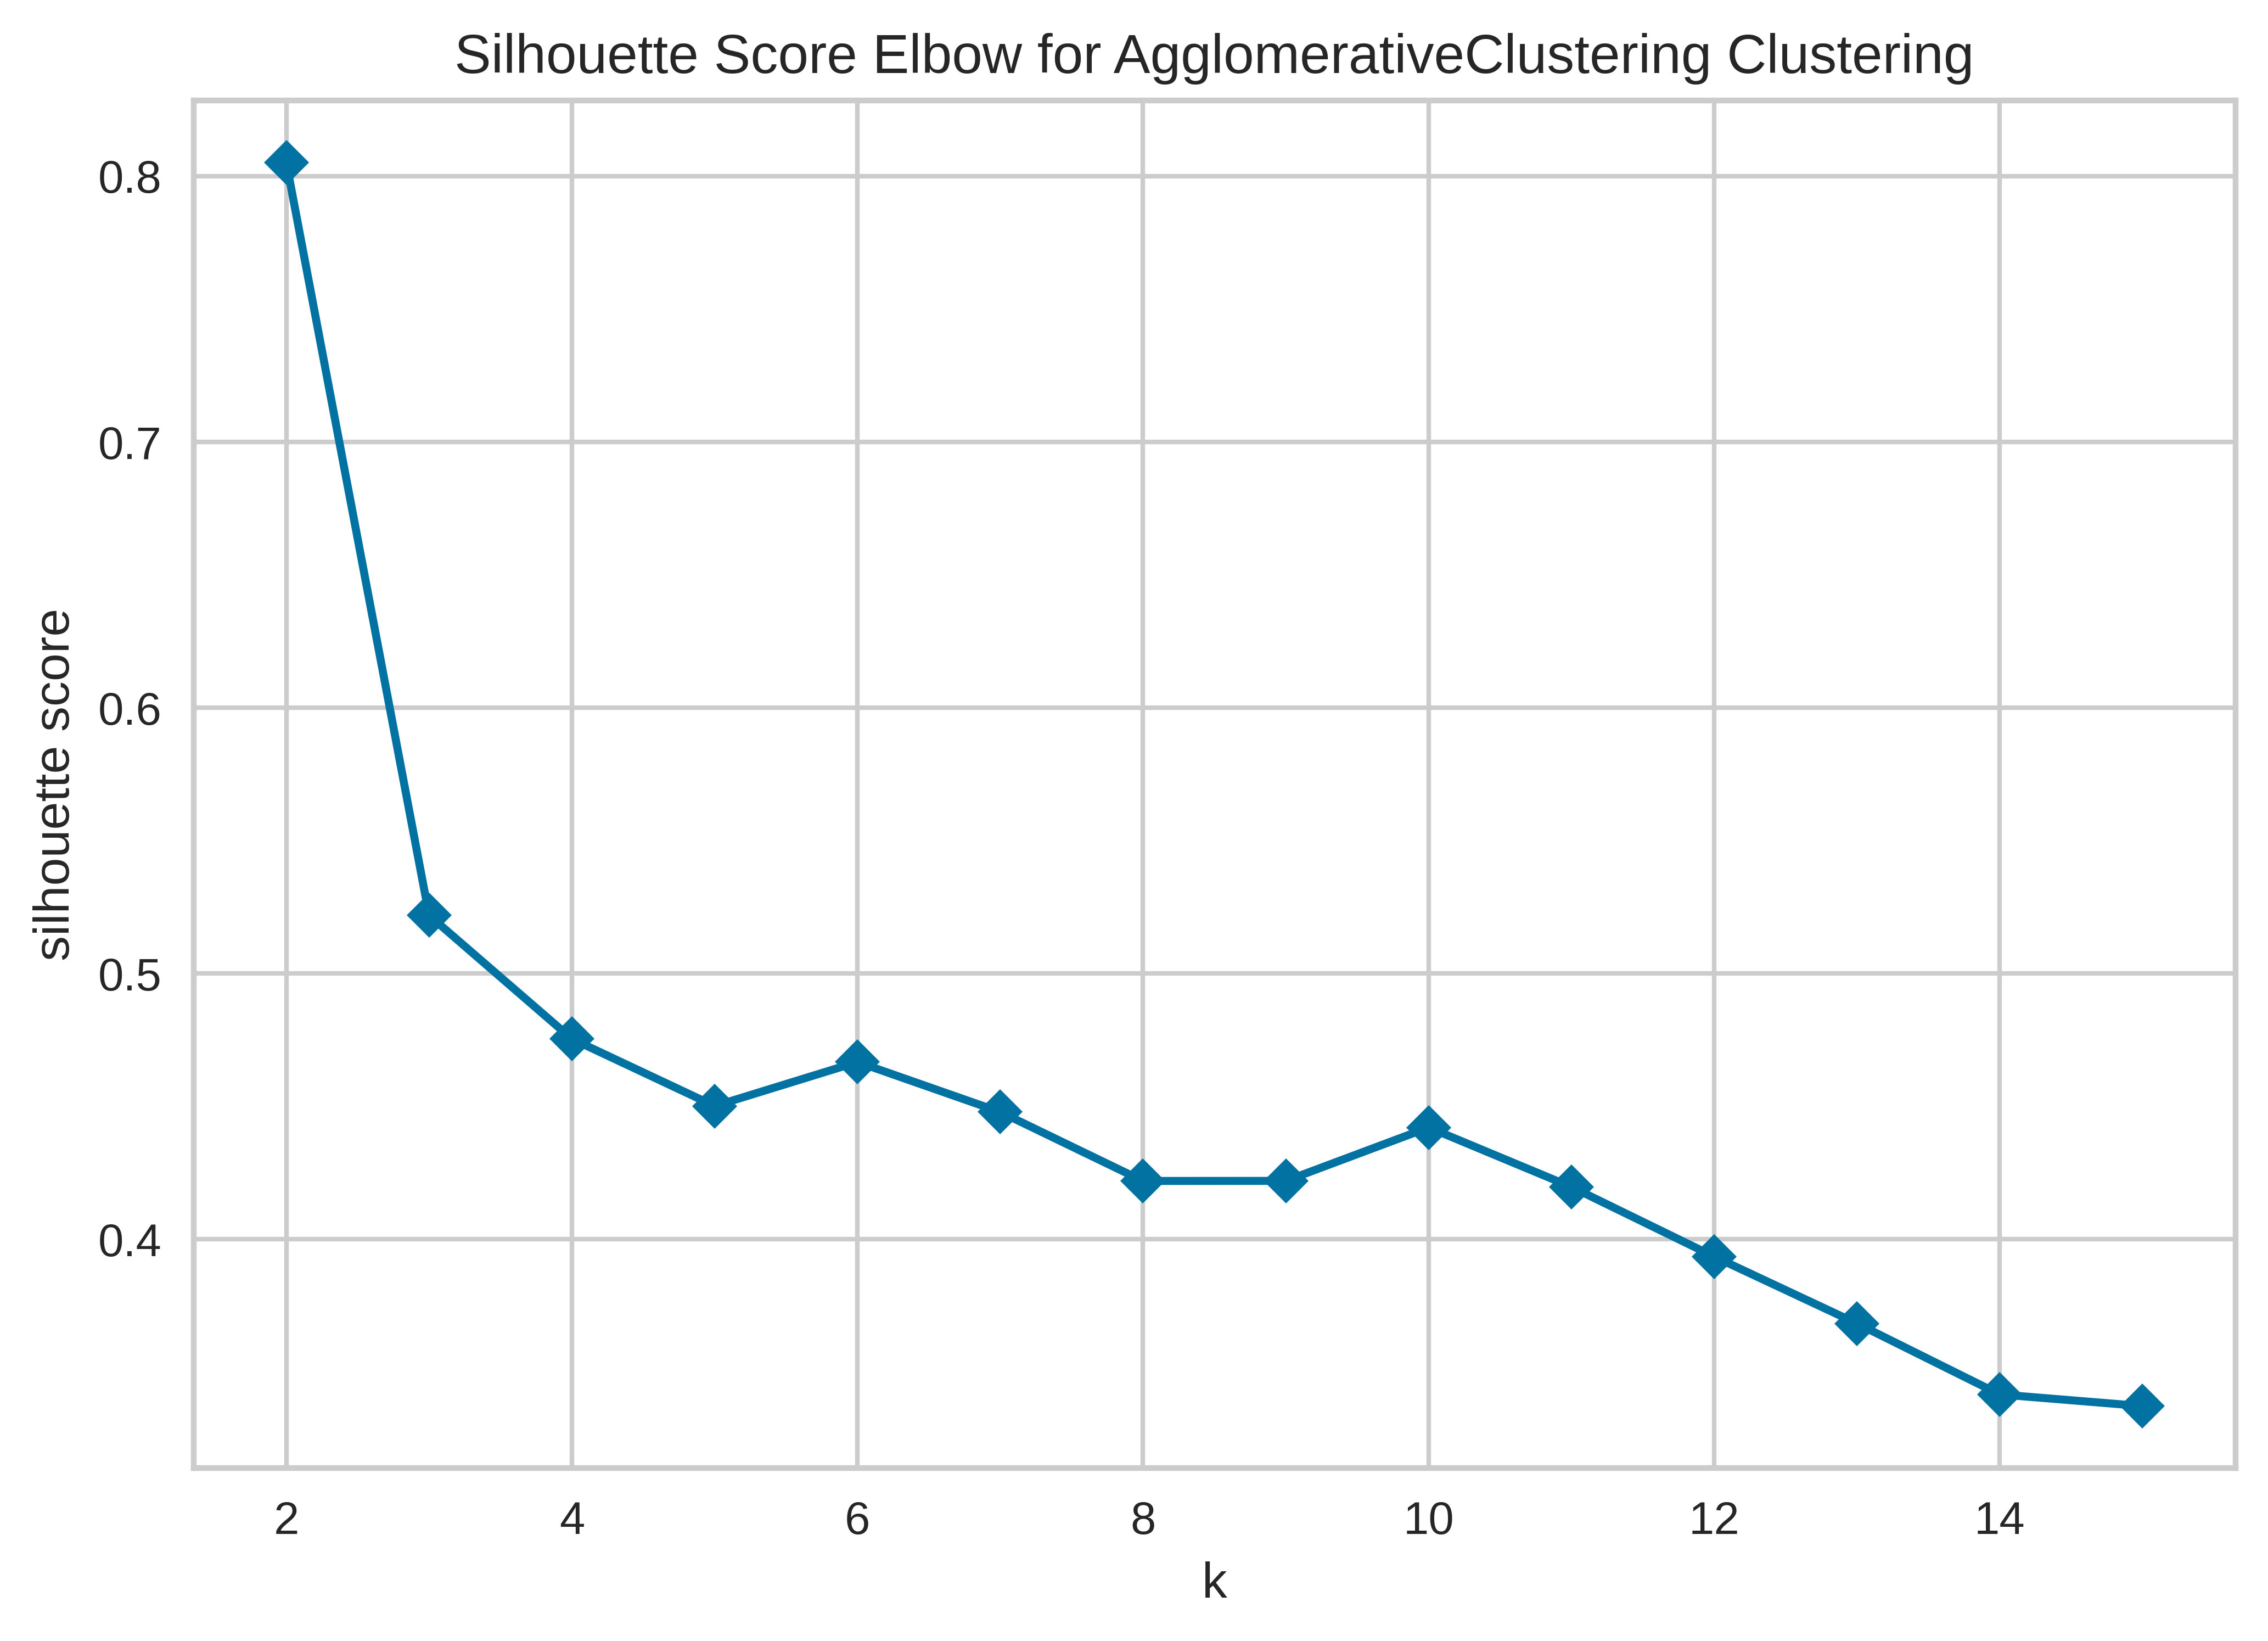

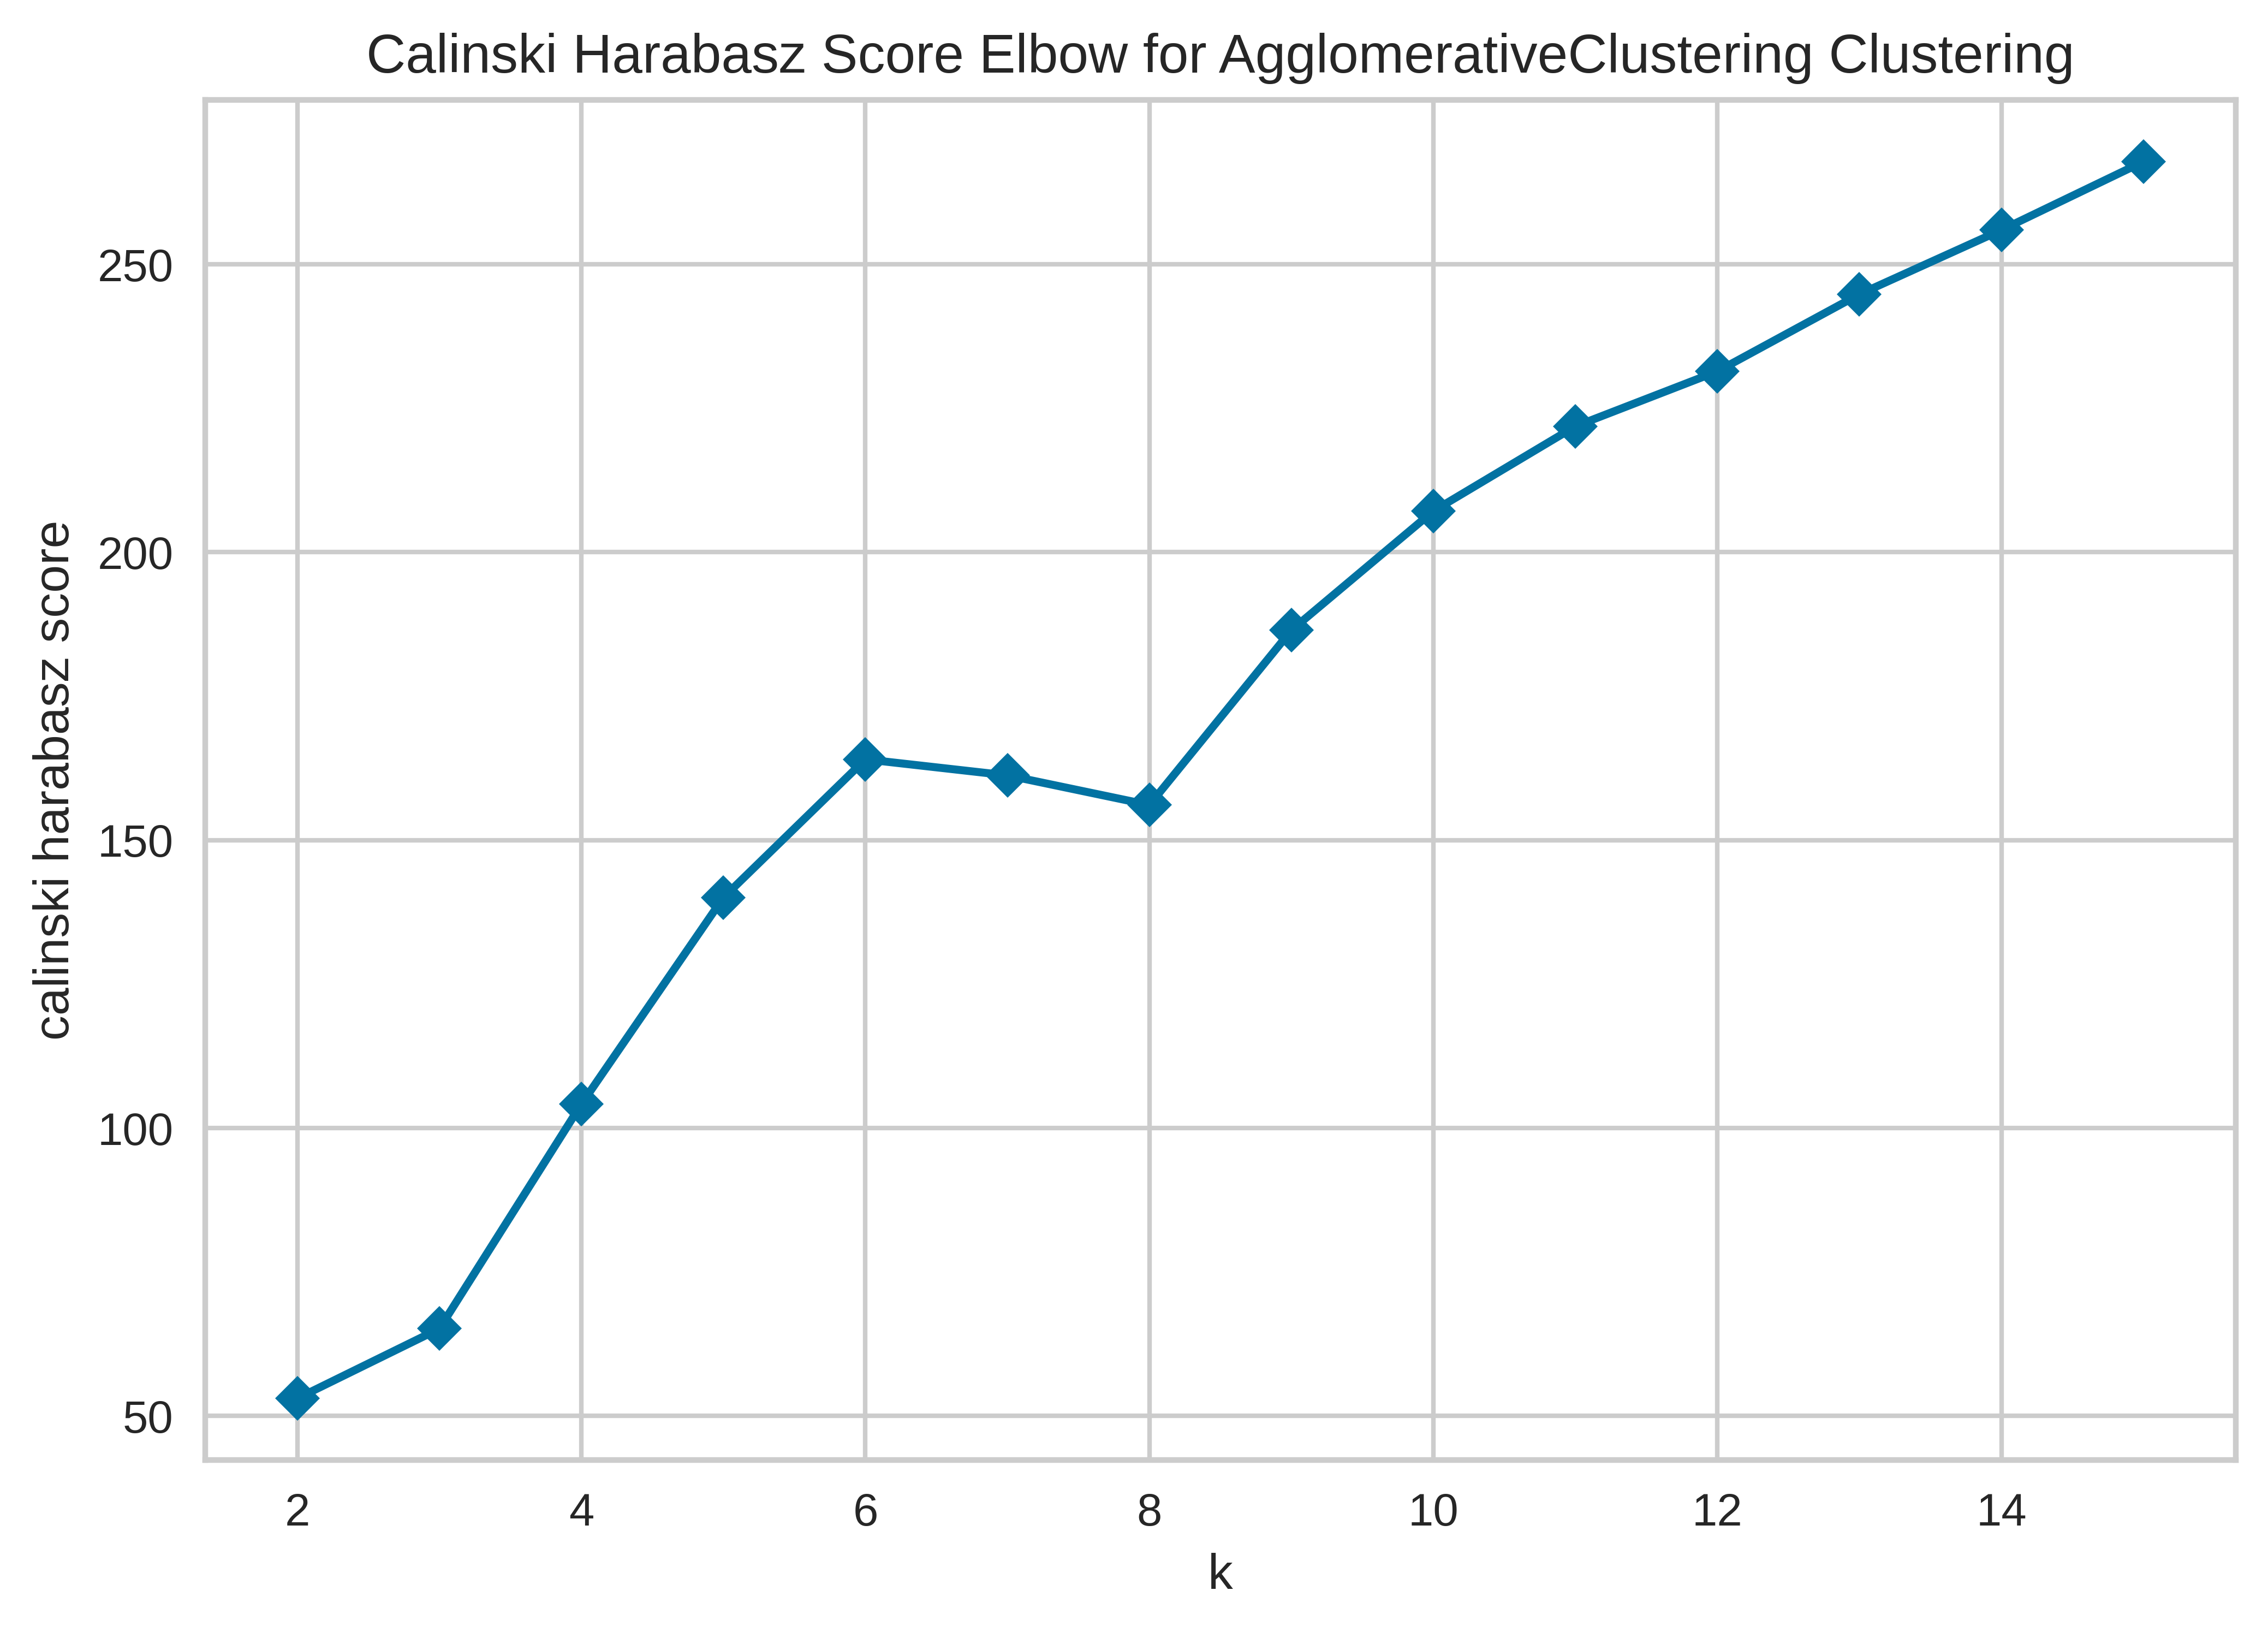

<IPython.core.display.Javascript object>

In [19]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_morph_embs)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_morph_embs)
ax = visualizer.show()


The optimal number of cluster seems to be 6 for our batch-centered JUMP morphological profiles.

In [20]:
model = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="complete")
shared_jump_morph_embs_cluster_labels = model.fit_predict(shared_jump_morph_embs)
shared_jump_morph_embs_clusters = pd.DataFrame(
    shared_jump_morph_embs_cluster_labels,
    index=shared_jump_morph_embs.index,
    columns=["cluster"],
)
shared_jump_morph_embs_clusters.head()

cluster
Metadata_Symbol         
IRAK4                  4
WWTR1                  4
SMAD4                  0
MAP3K5                 5
RHOA                   1

<IPython.core.display.Javascript object>

---
## Batch-centered JUMP morphological profiles



In [21]:
shared_jump_morph_embs_bc = jump_morph_embs_bc.loc[shared_genes]

<IPython.core.display.Javascript object>

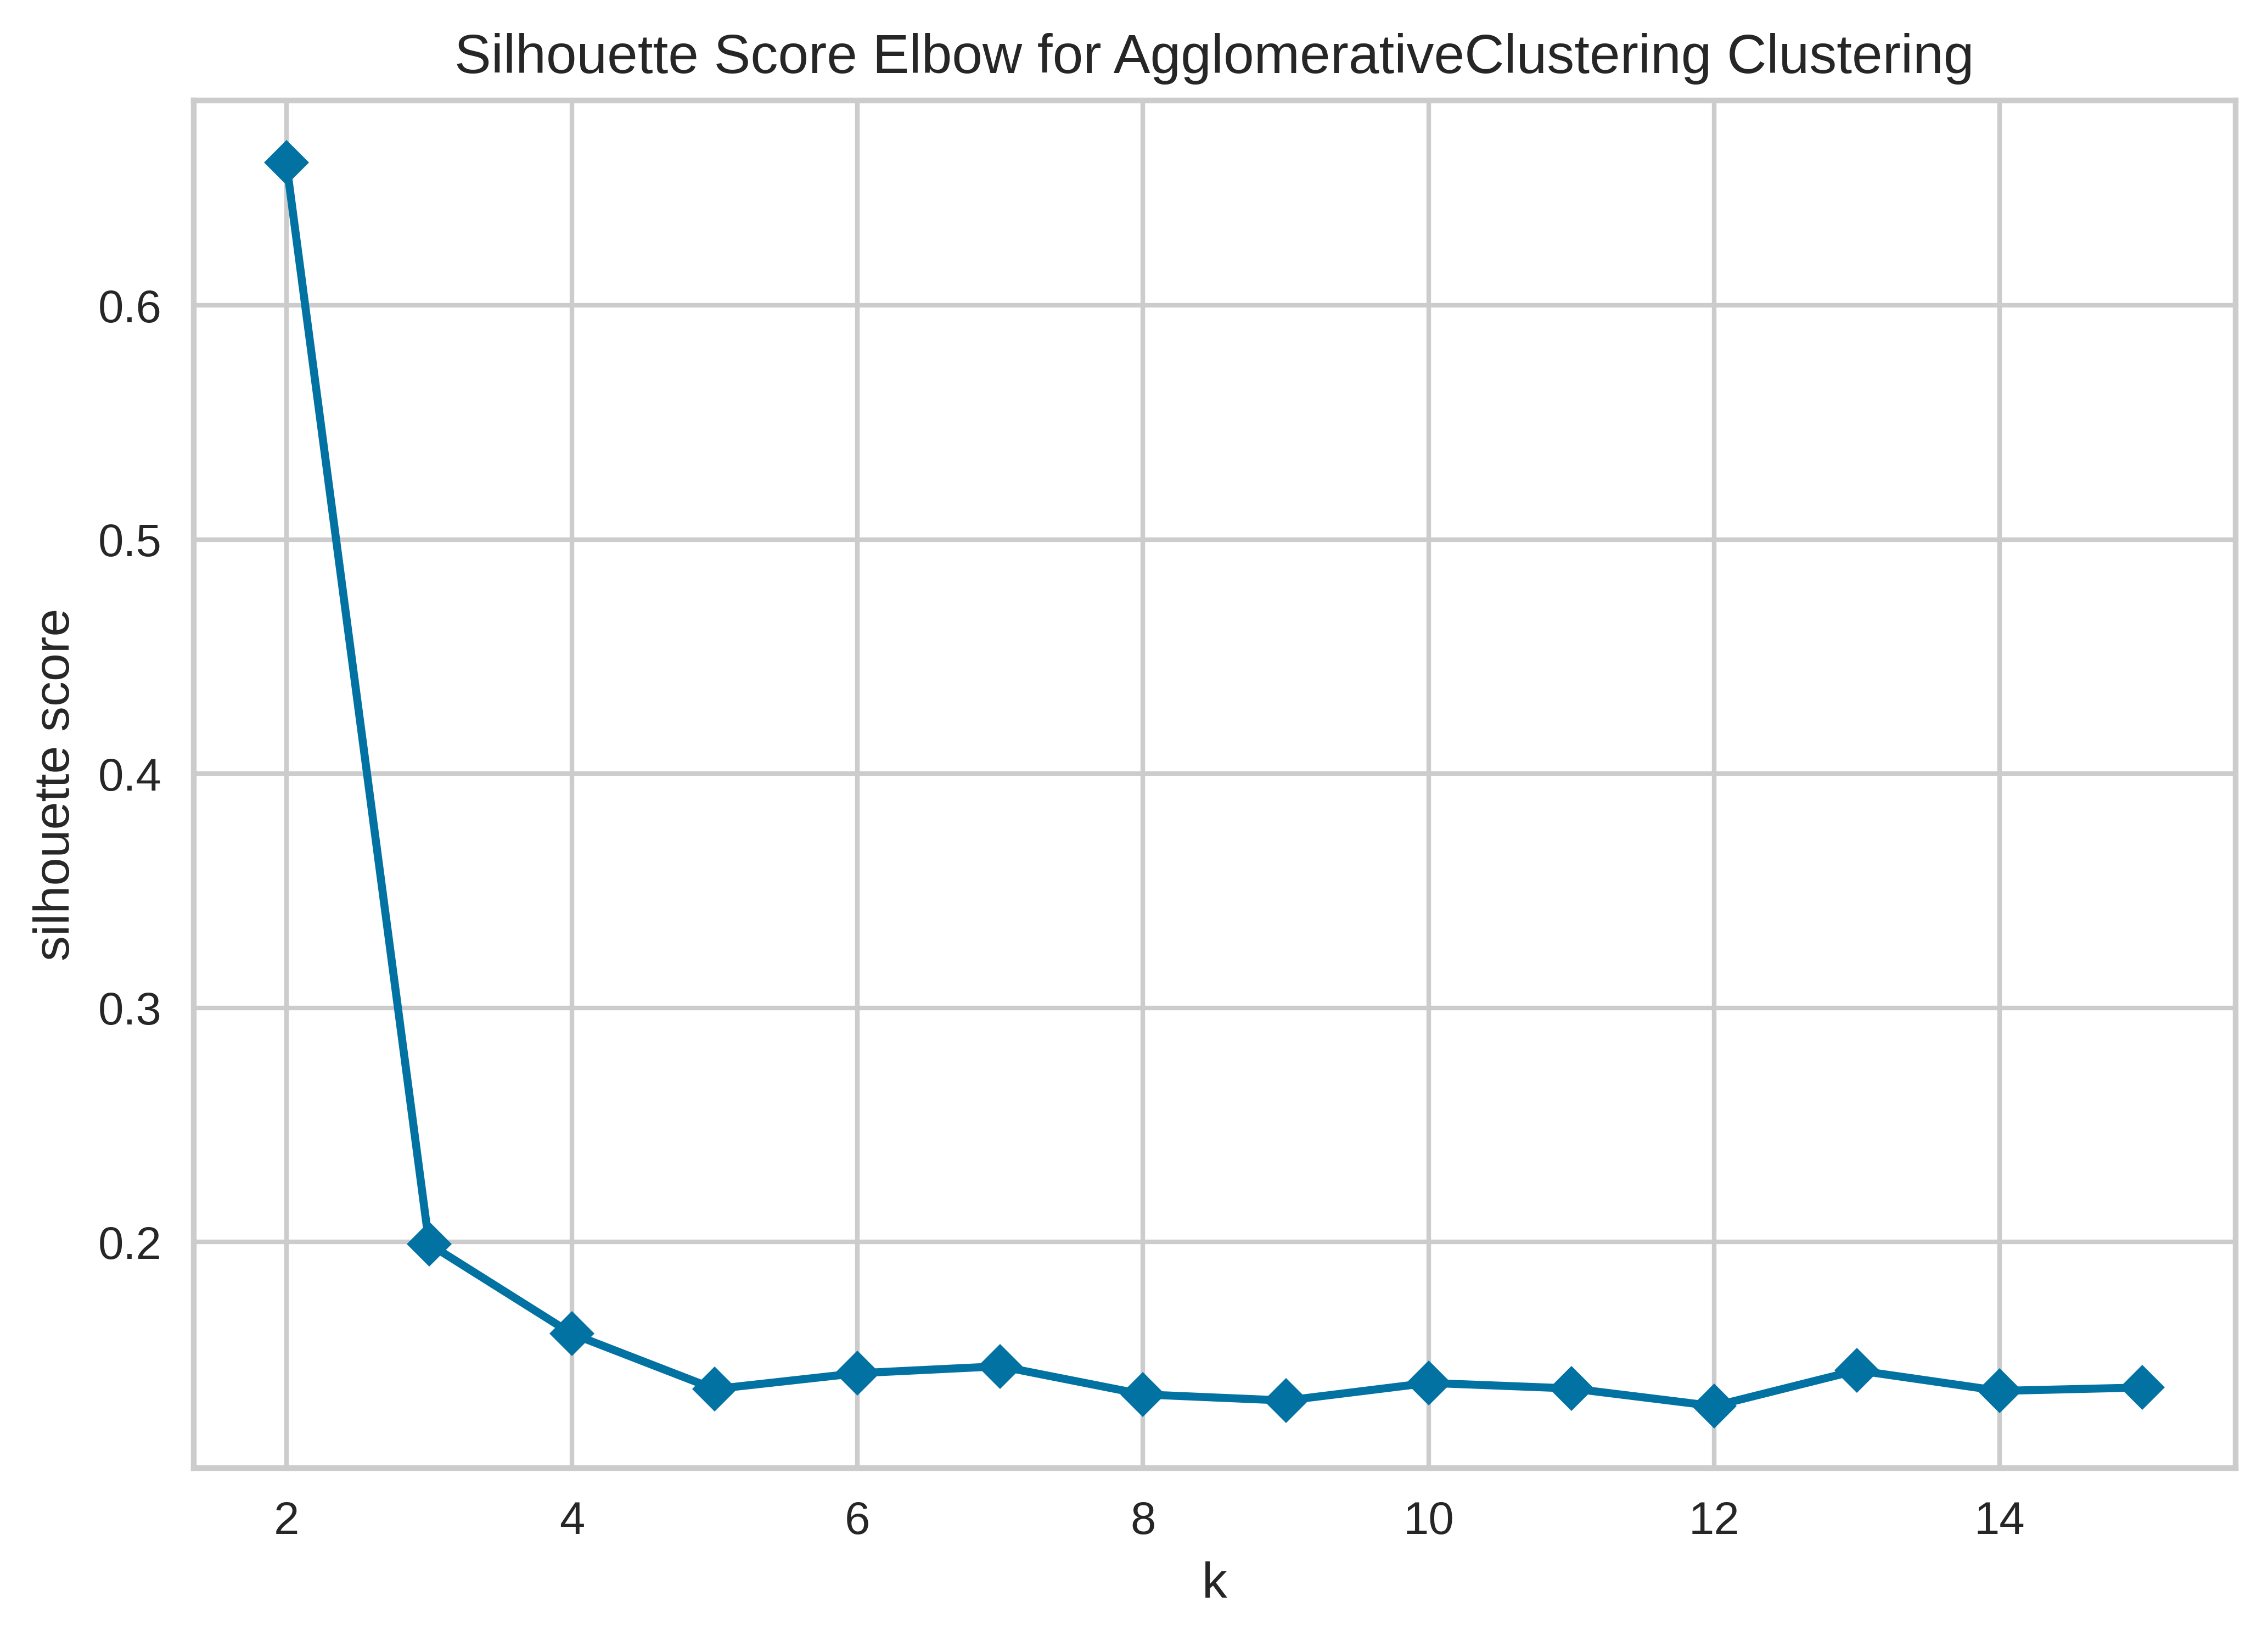

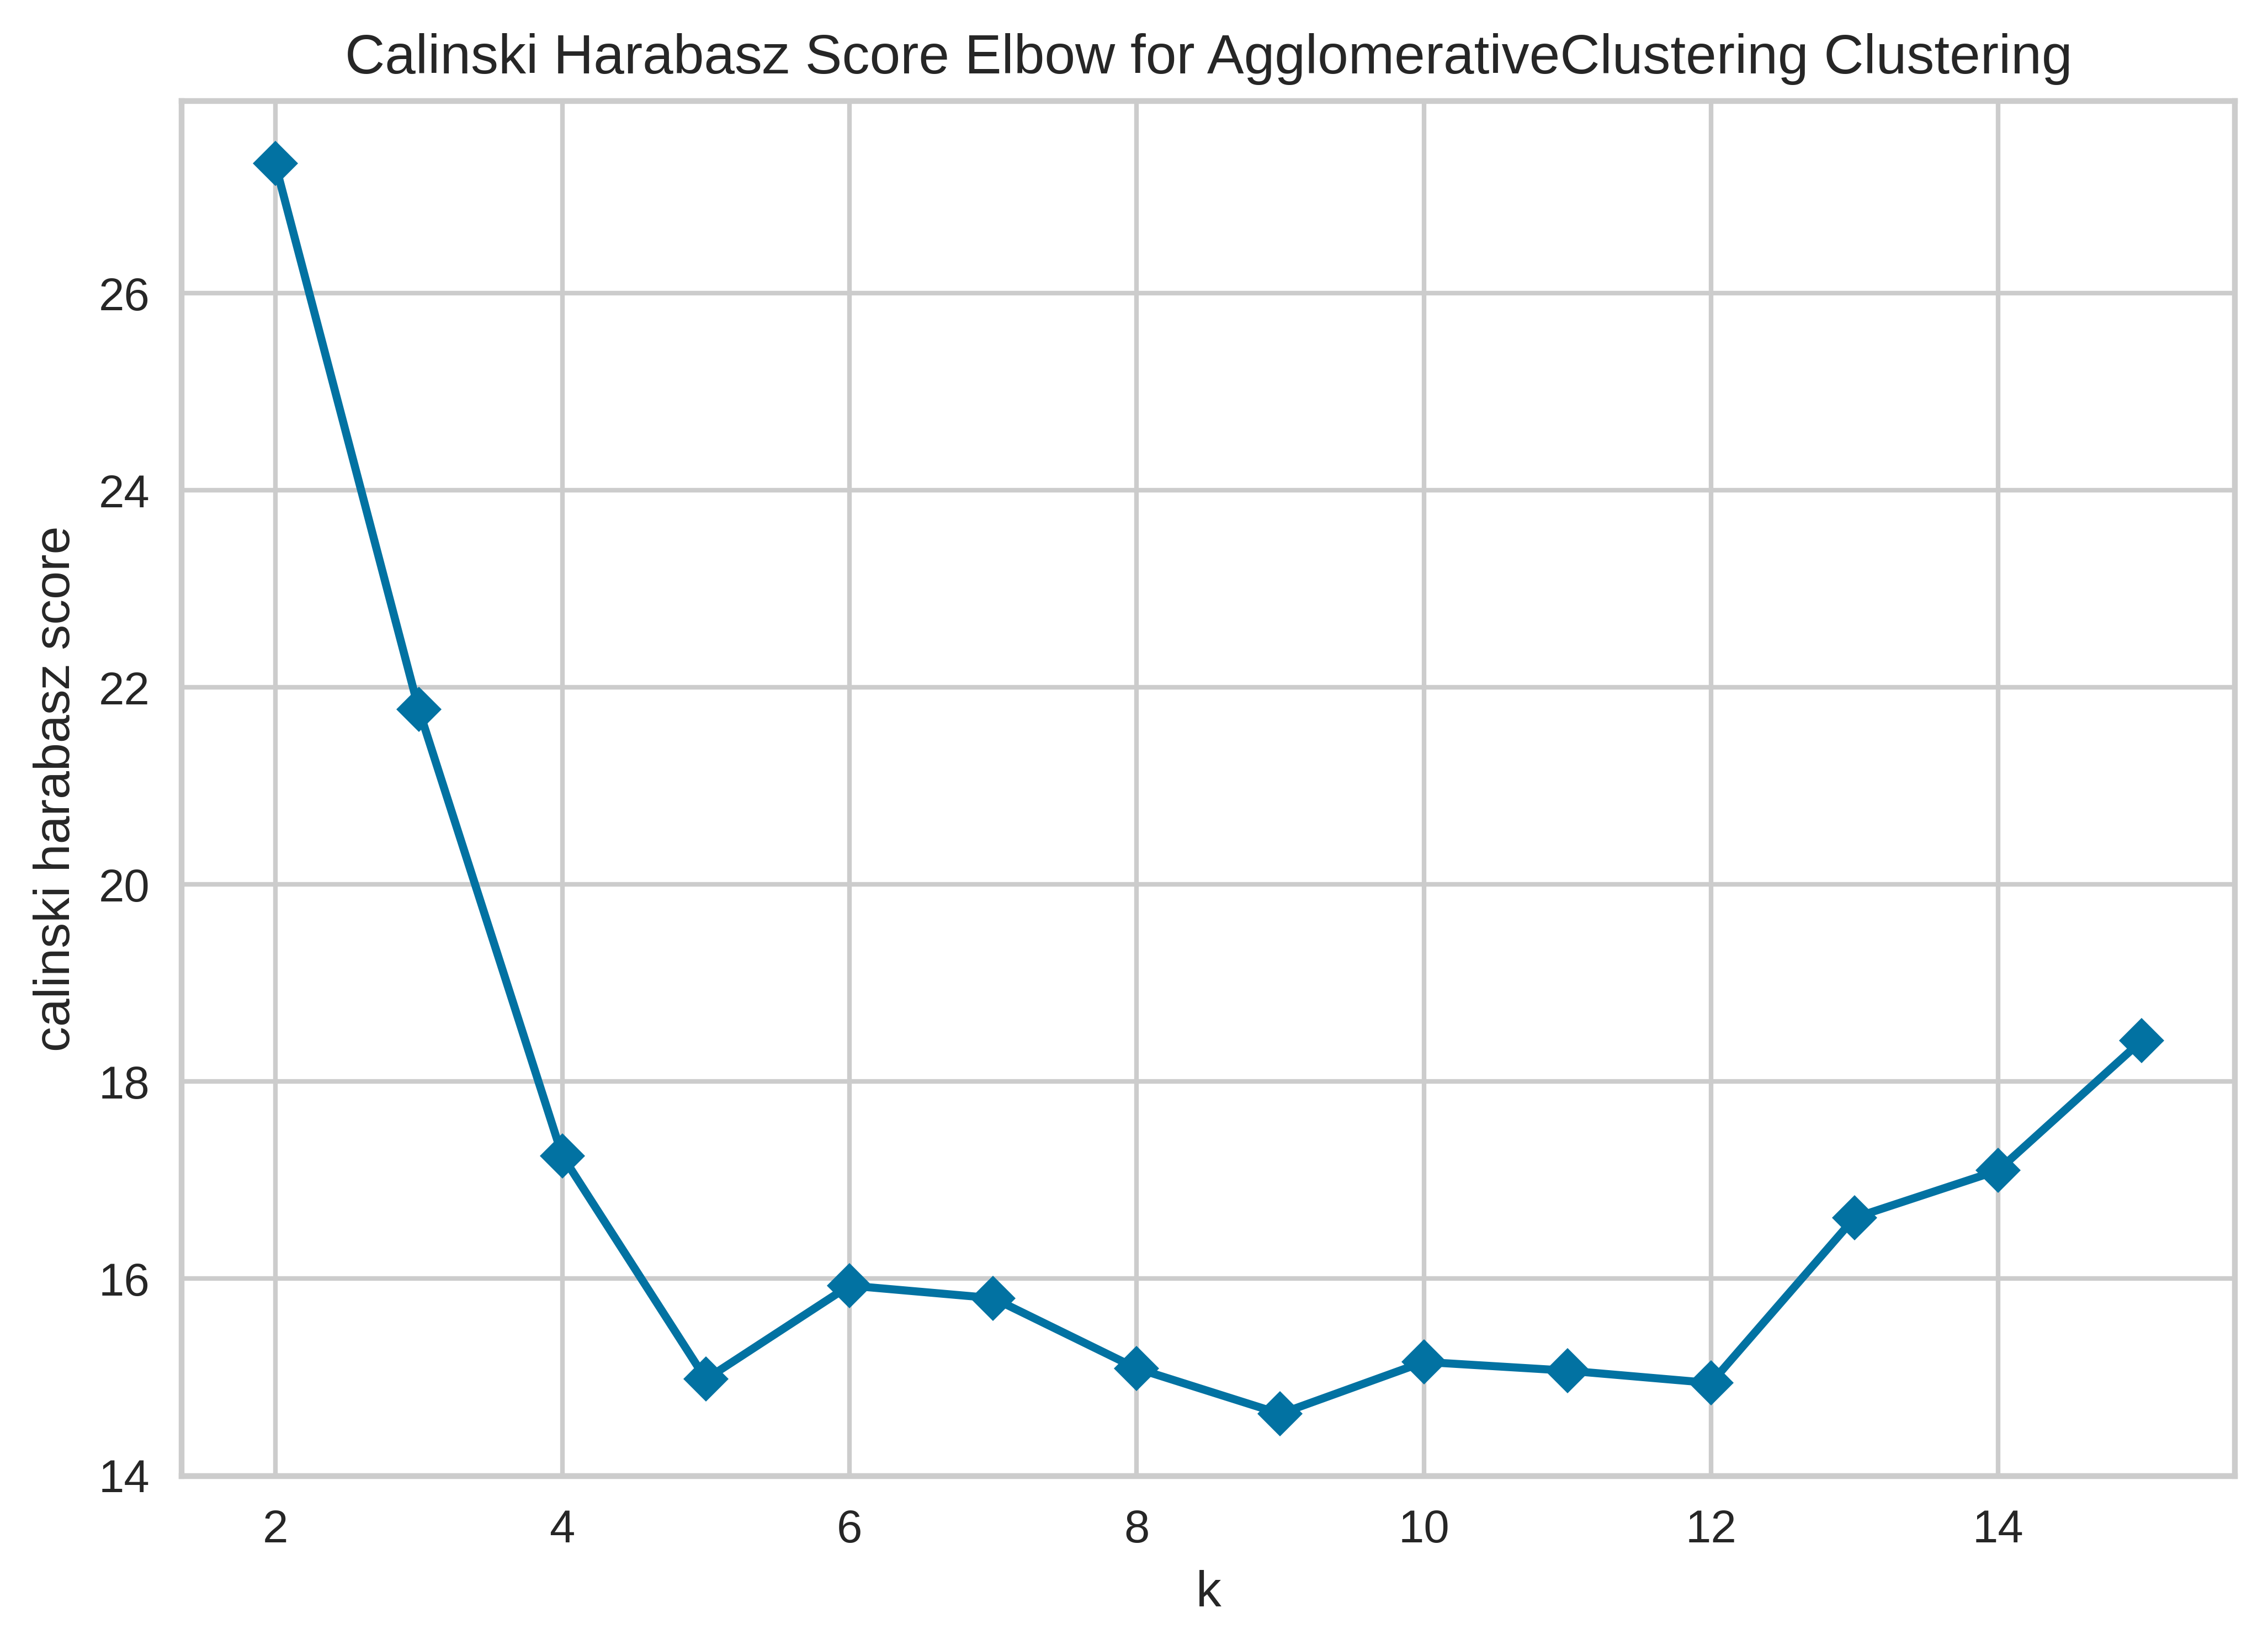

<IPython.core.display.Javascript object>

In [22]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_morph_embs_bc)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_morph_embs_bc)
ax = visualizer.show()


The optimal number of cluster seems to be 6 for our batch-centered JUMP morphological profiles.

In [23]:
model = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="complete")
shared_jump_morph_embs_bc_cluster_labels = model.fit_predict(shared_jump_morph_embs_bc)
shared_jump_morph_embs_bc_clusters = pd.DataFrame(
    shared_jump_morph_embs_bc_cluster_labels,
    index=shared_jump_morph_embs_bc.index,
    columns=["cluster"],
)
shared_jump_morph_embs_bc_clusters.head()

cluster
Metadata_Symbol         
IRAK4                  2
WWTR1                  0
SMAD4                  0
MAP3K5                 1
RHOA                   0

<IPython.core.display.Javascript object>

---

## INSP-corrected JUMP morphological profiles



In [24]:
shared_jump_morph_embs_insp = jump_morph_embs_insp.loc[shared_genes]

<IPython.core.display.Javascript object>

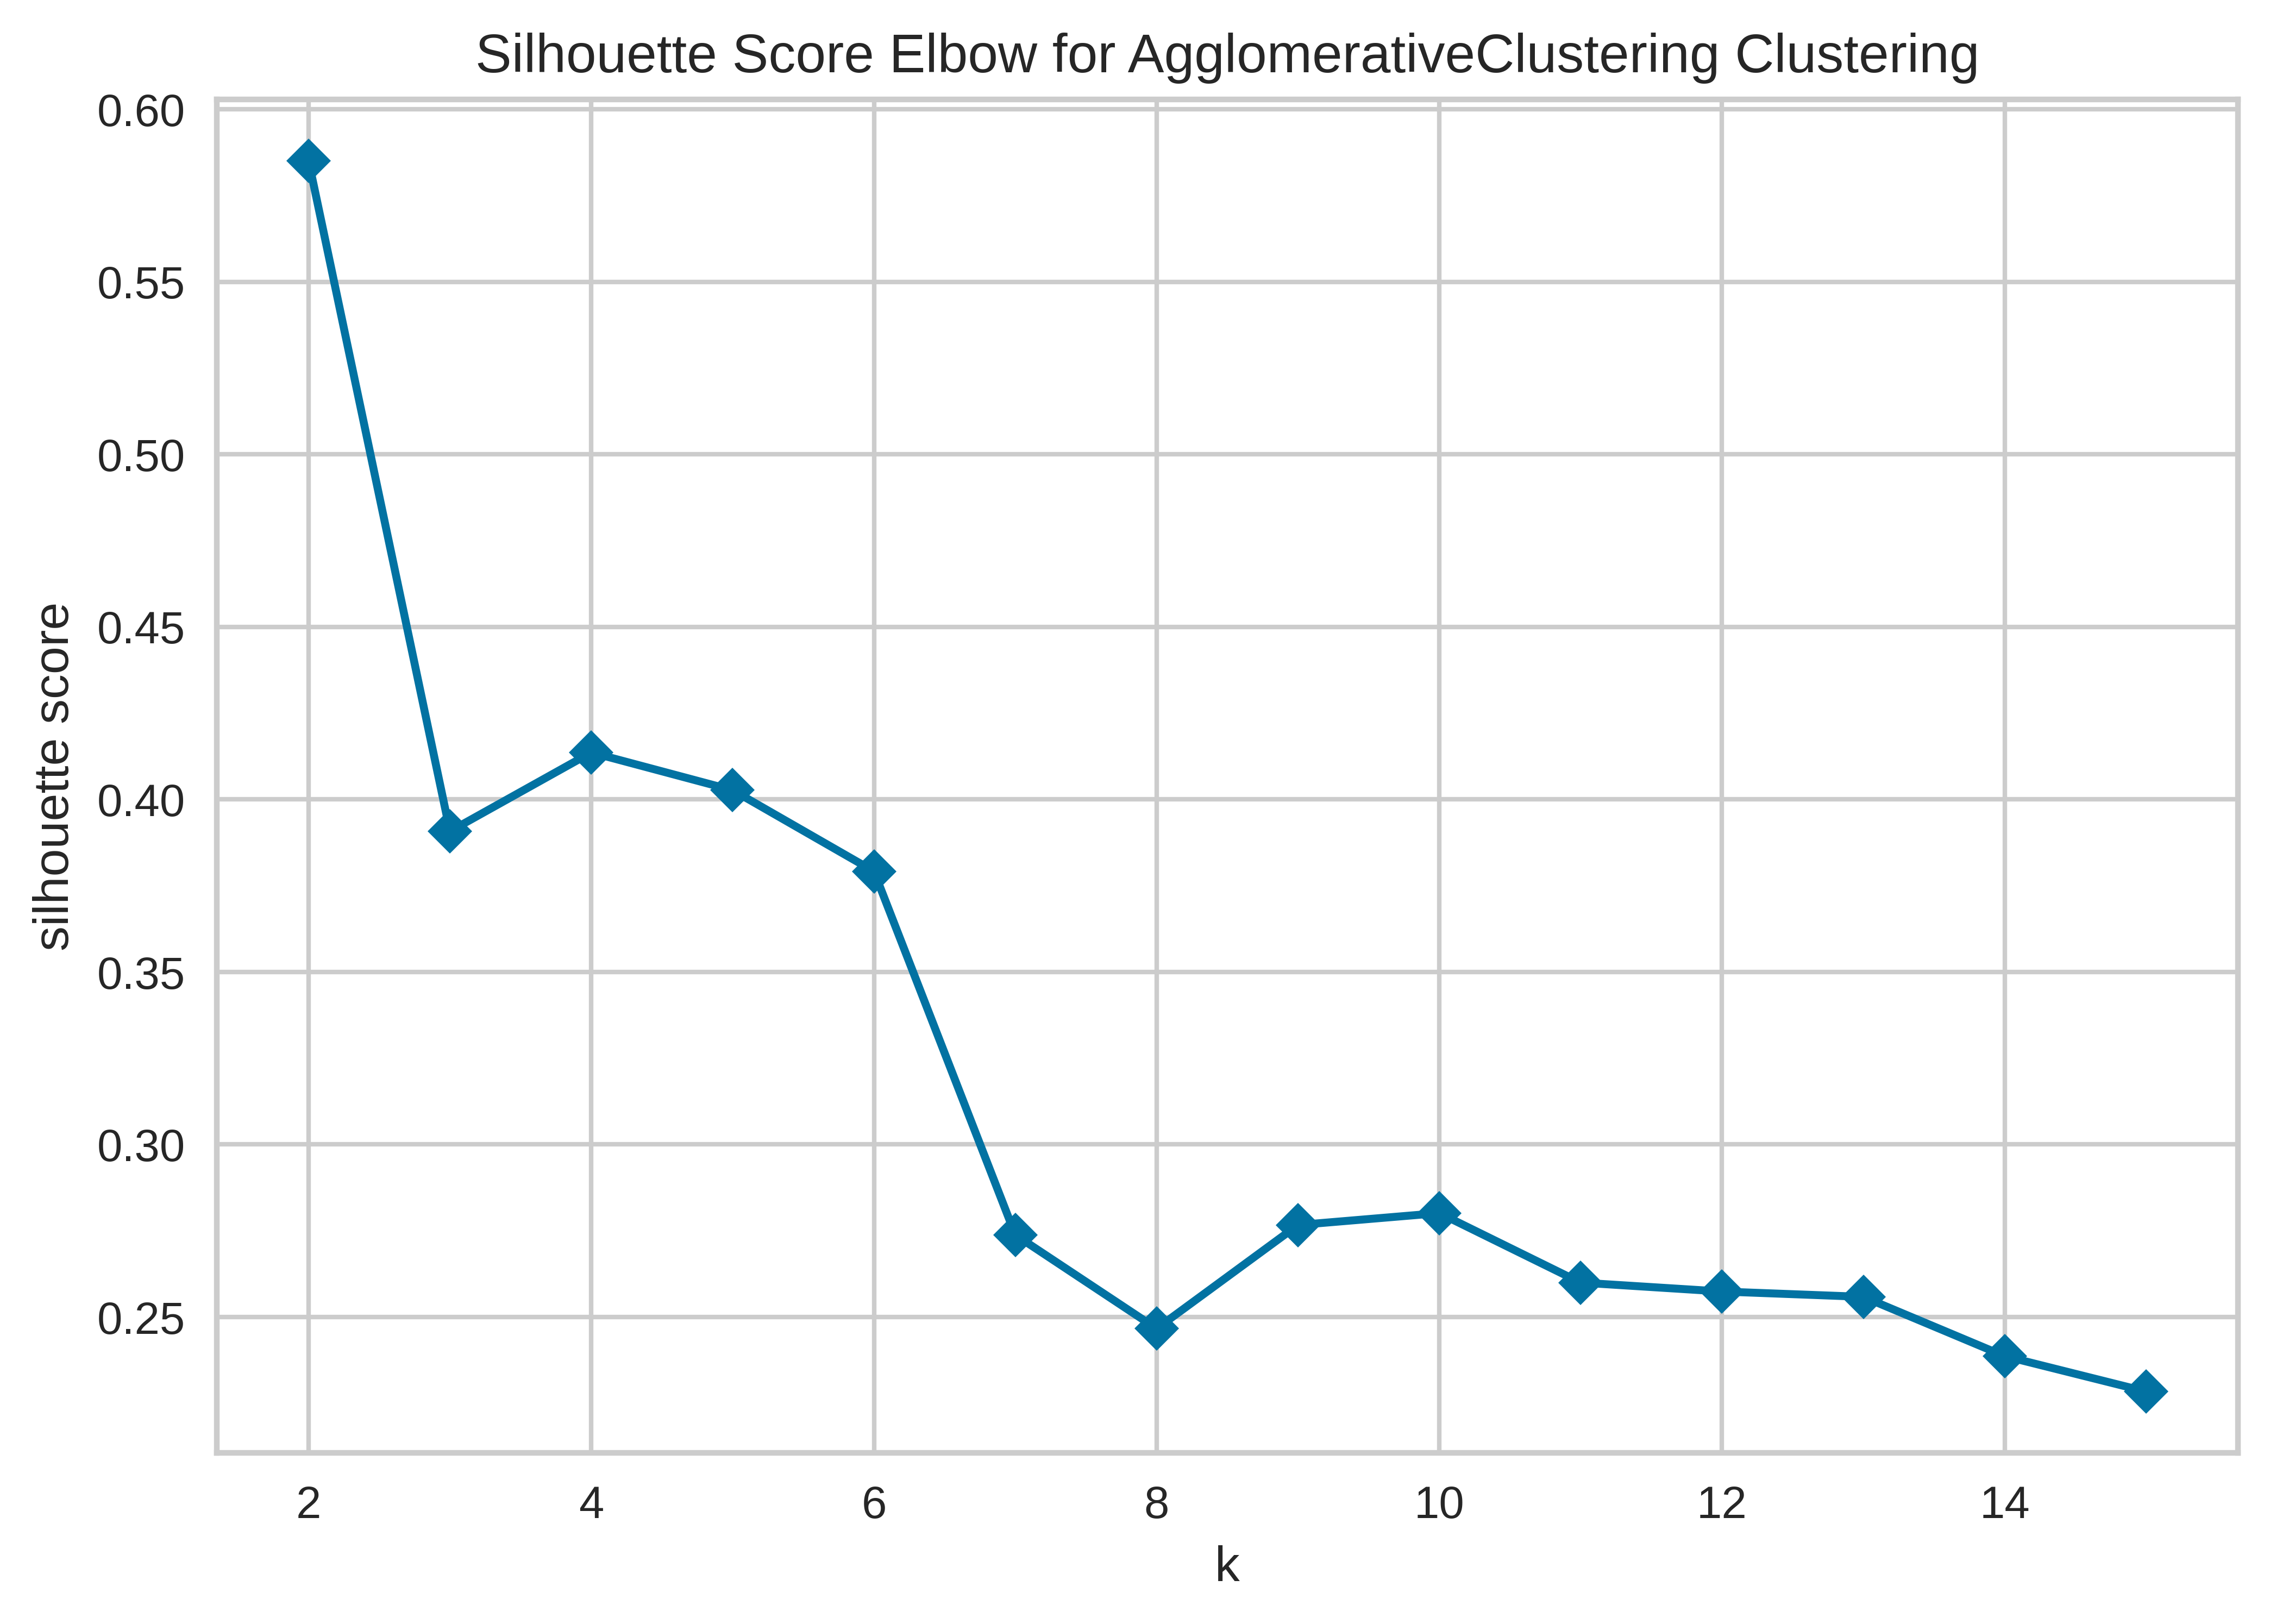

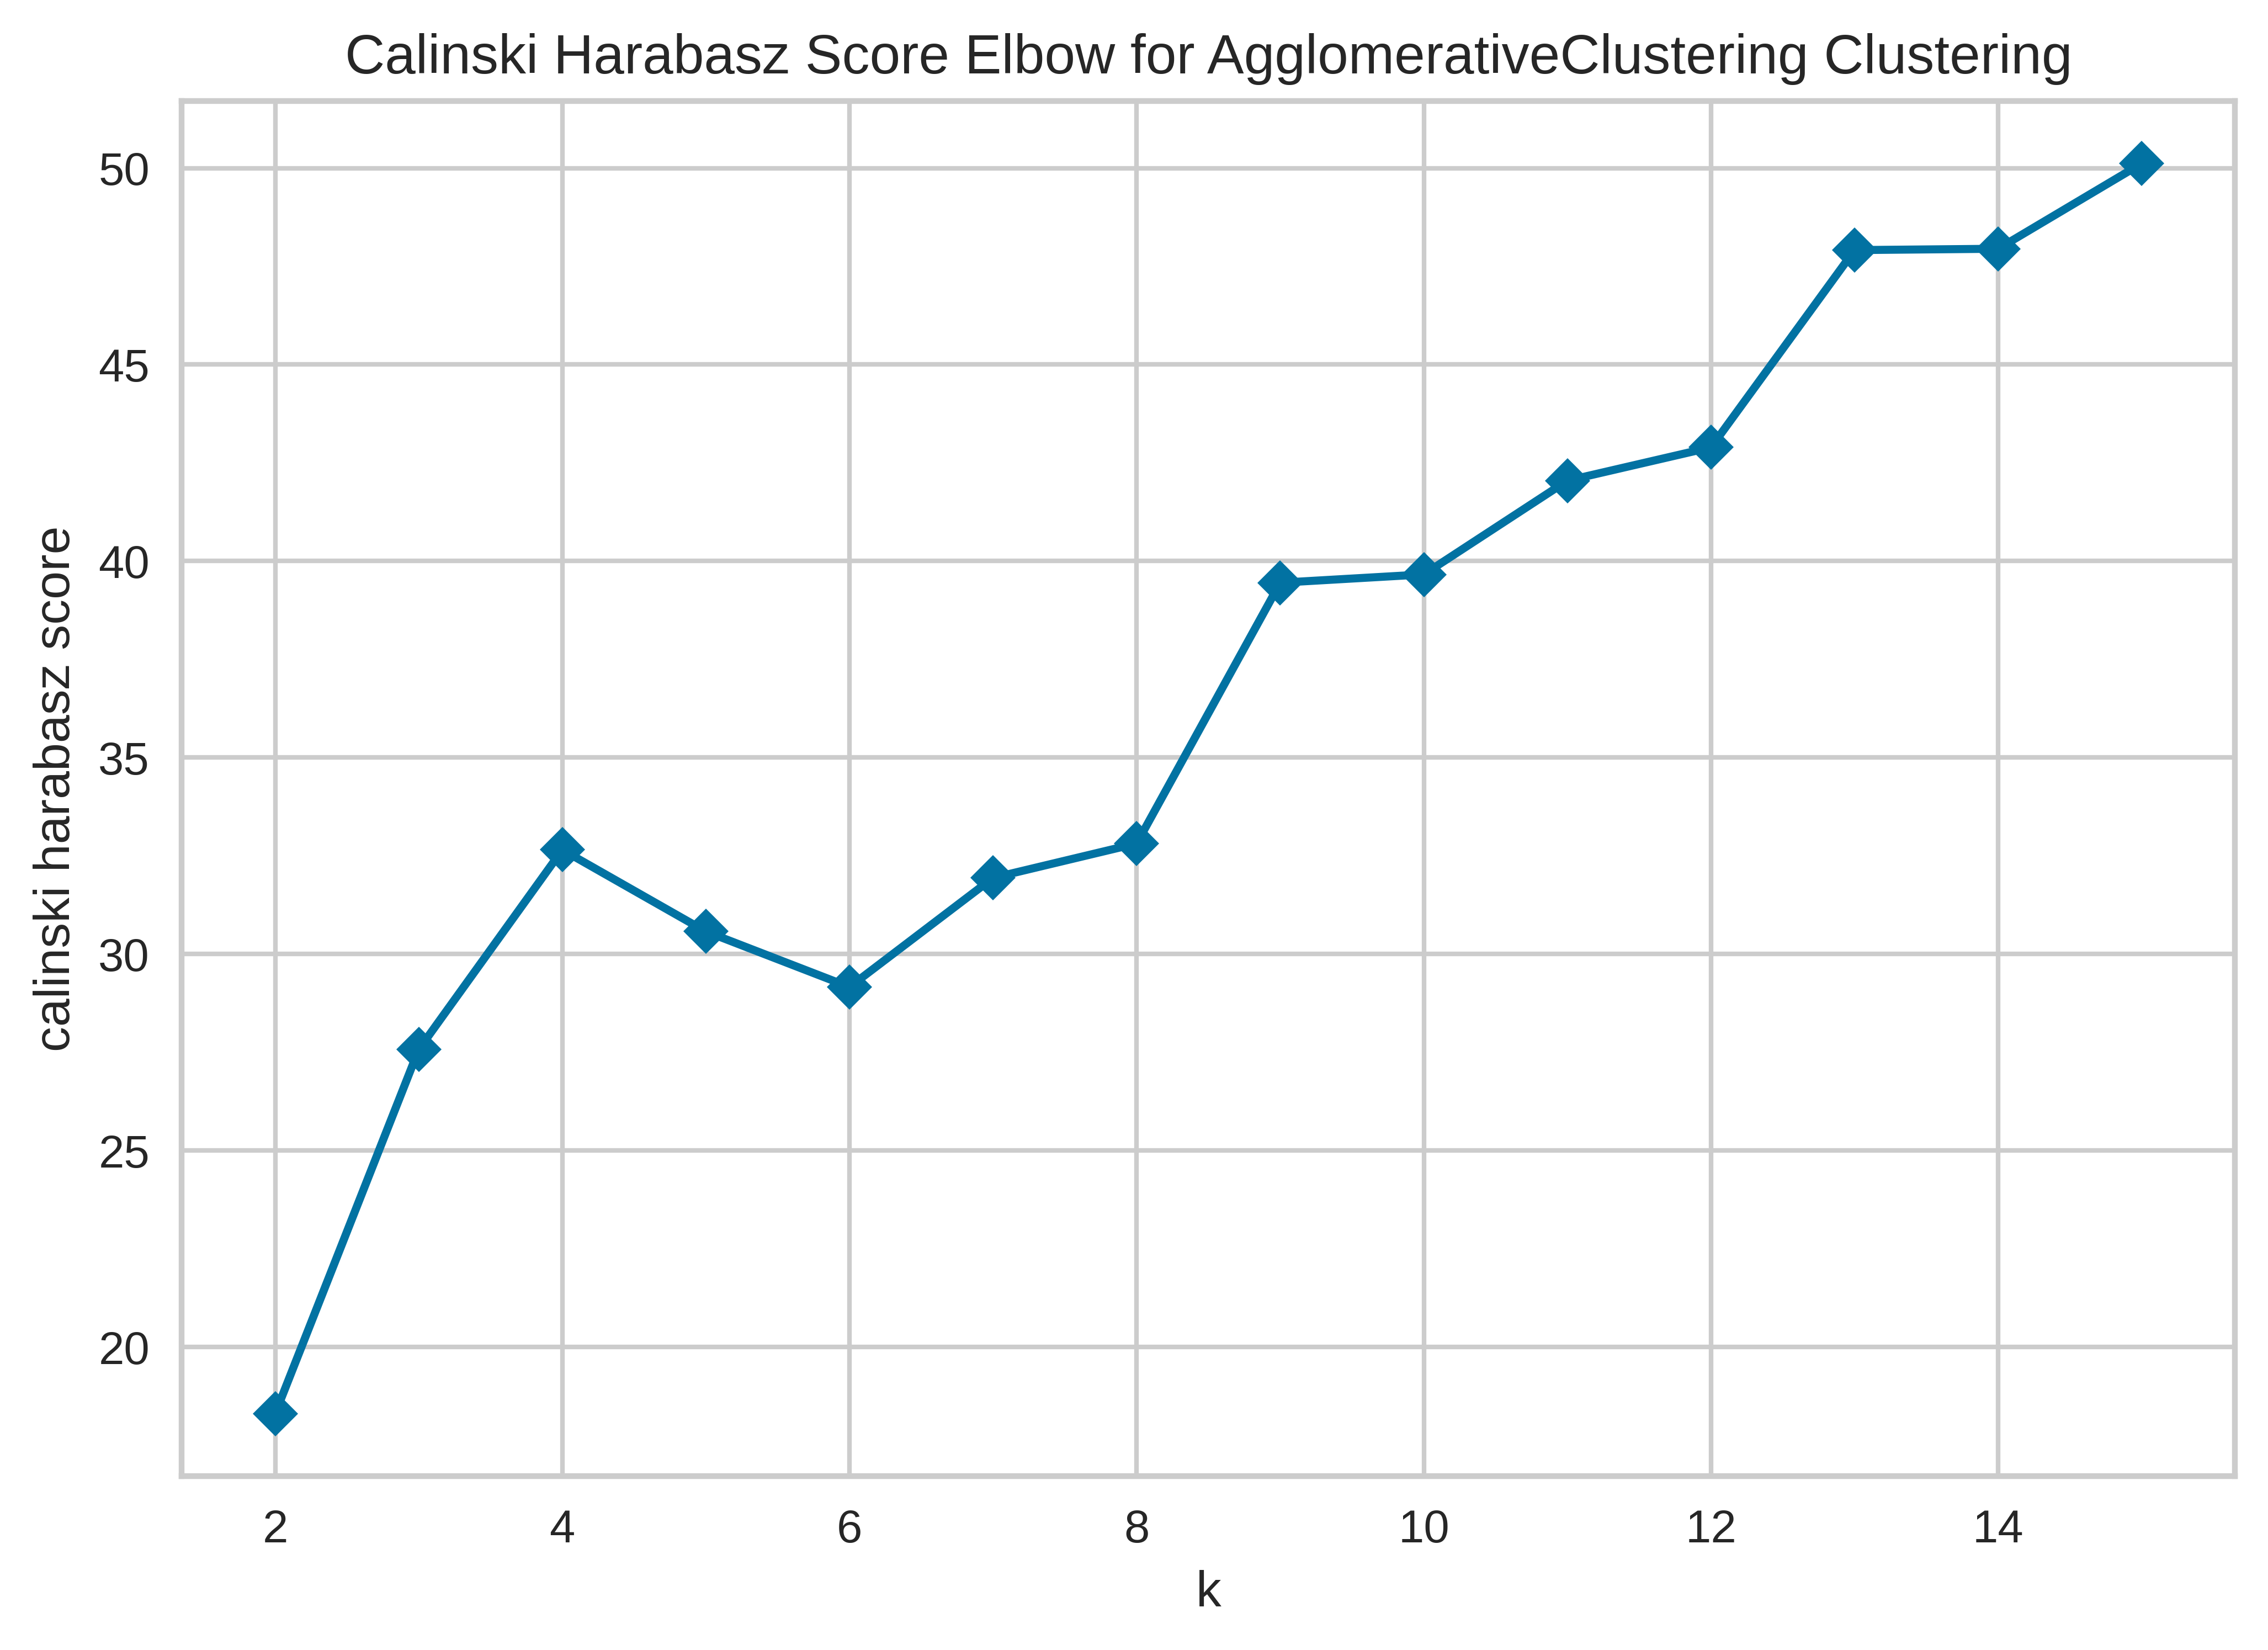

<IPython.core.display.Javascript object>

In [25]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_morph_embs_insp)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_jump_morph_embs_insp)
ax = visualizer.show()


The optimal number of cluster seems to be 10 for our batch-centered JUMP morphological profiles.

In [26]:
model = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="complete")
shared_jump_morph_embs_insp_cluster_labels = model.fit_predict(
    shared_jump_morph_embs_insp
)
shared_jump_morph_embs_insp_clusters = pd.DataFrame(
    shared_jump_morph_embs_insp_cluster_labels,
    index=shared_jump_morph_embs_insp.index,
    columns=["cluster"],
)
shared_jump_morph_embs_insp_clusters.head()

cluster
label          
IRAK4         2
WWTR1         3
SMAD4         2
MAP3K5        9
RHOA          0

<IPython.core.display.Javascript object>

---
## Rohban image embeddings



In [27]:
shared_rohban_img_embs = rohban_img_embs.loc[shared_genes]

<IPython.core.display.Javascript object>

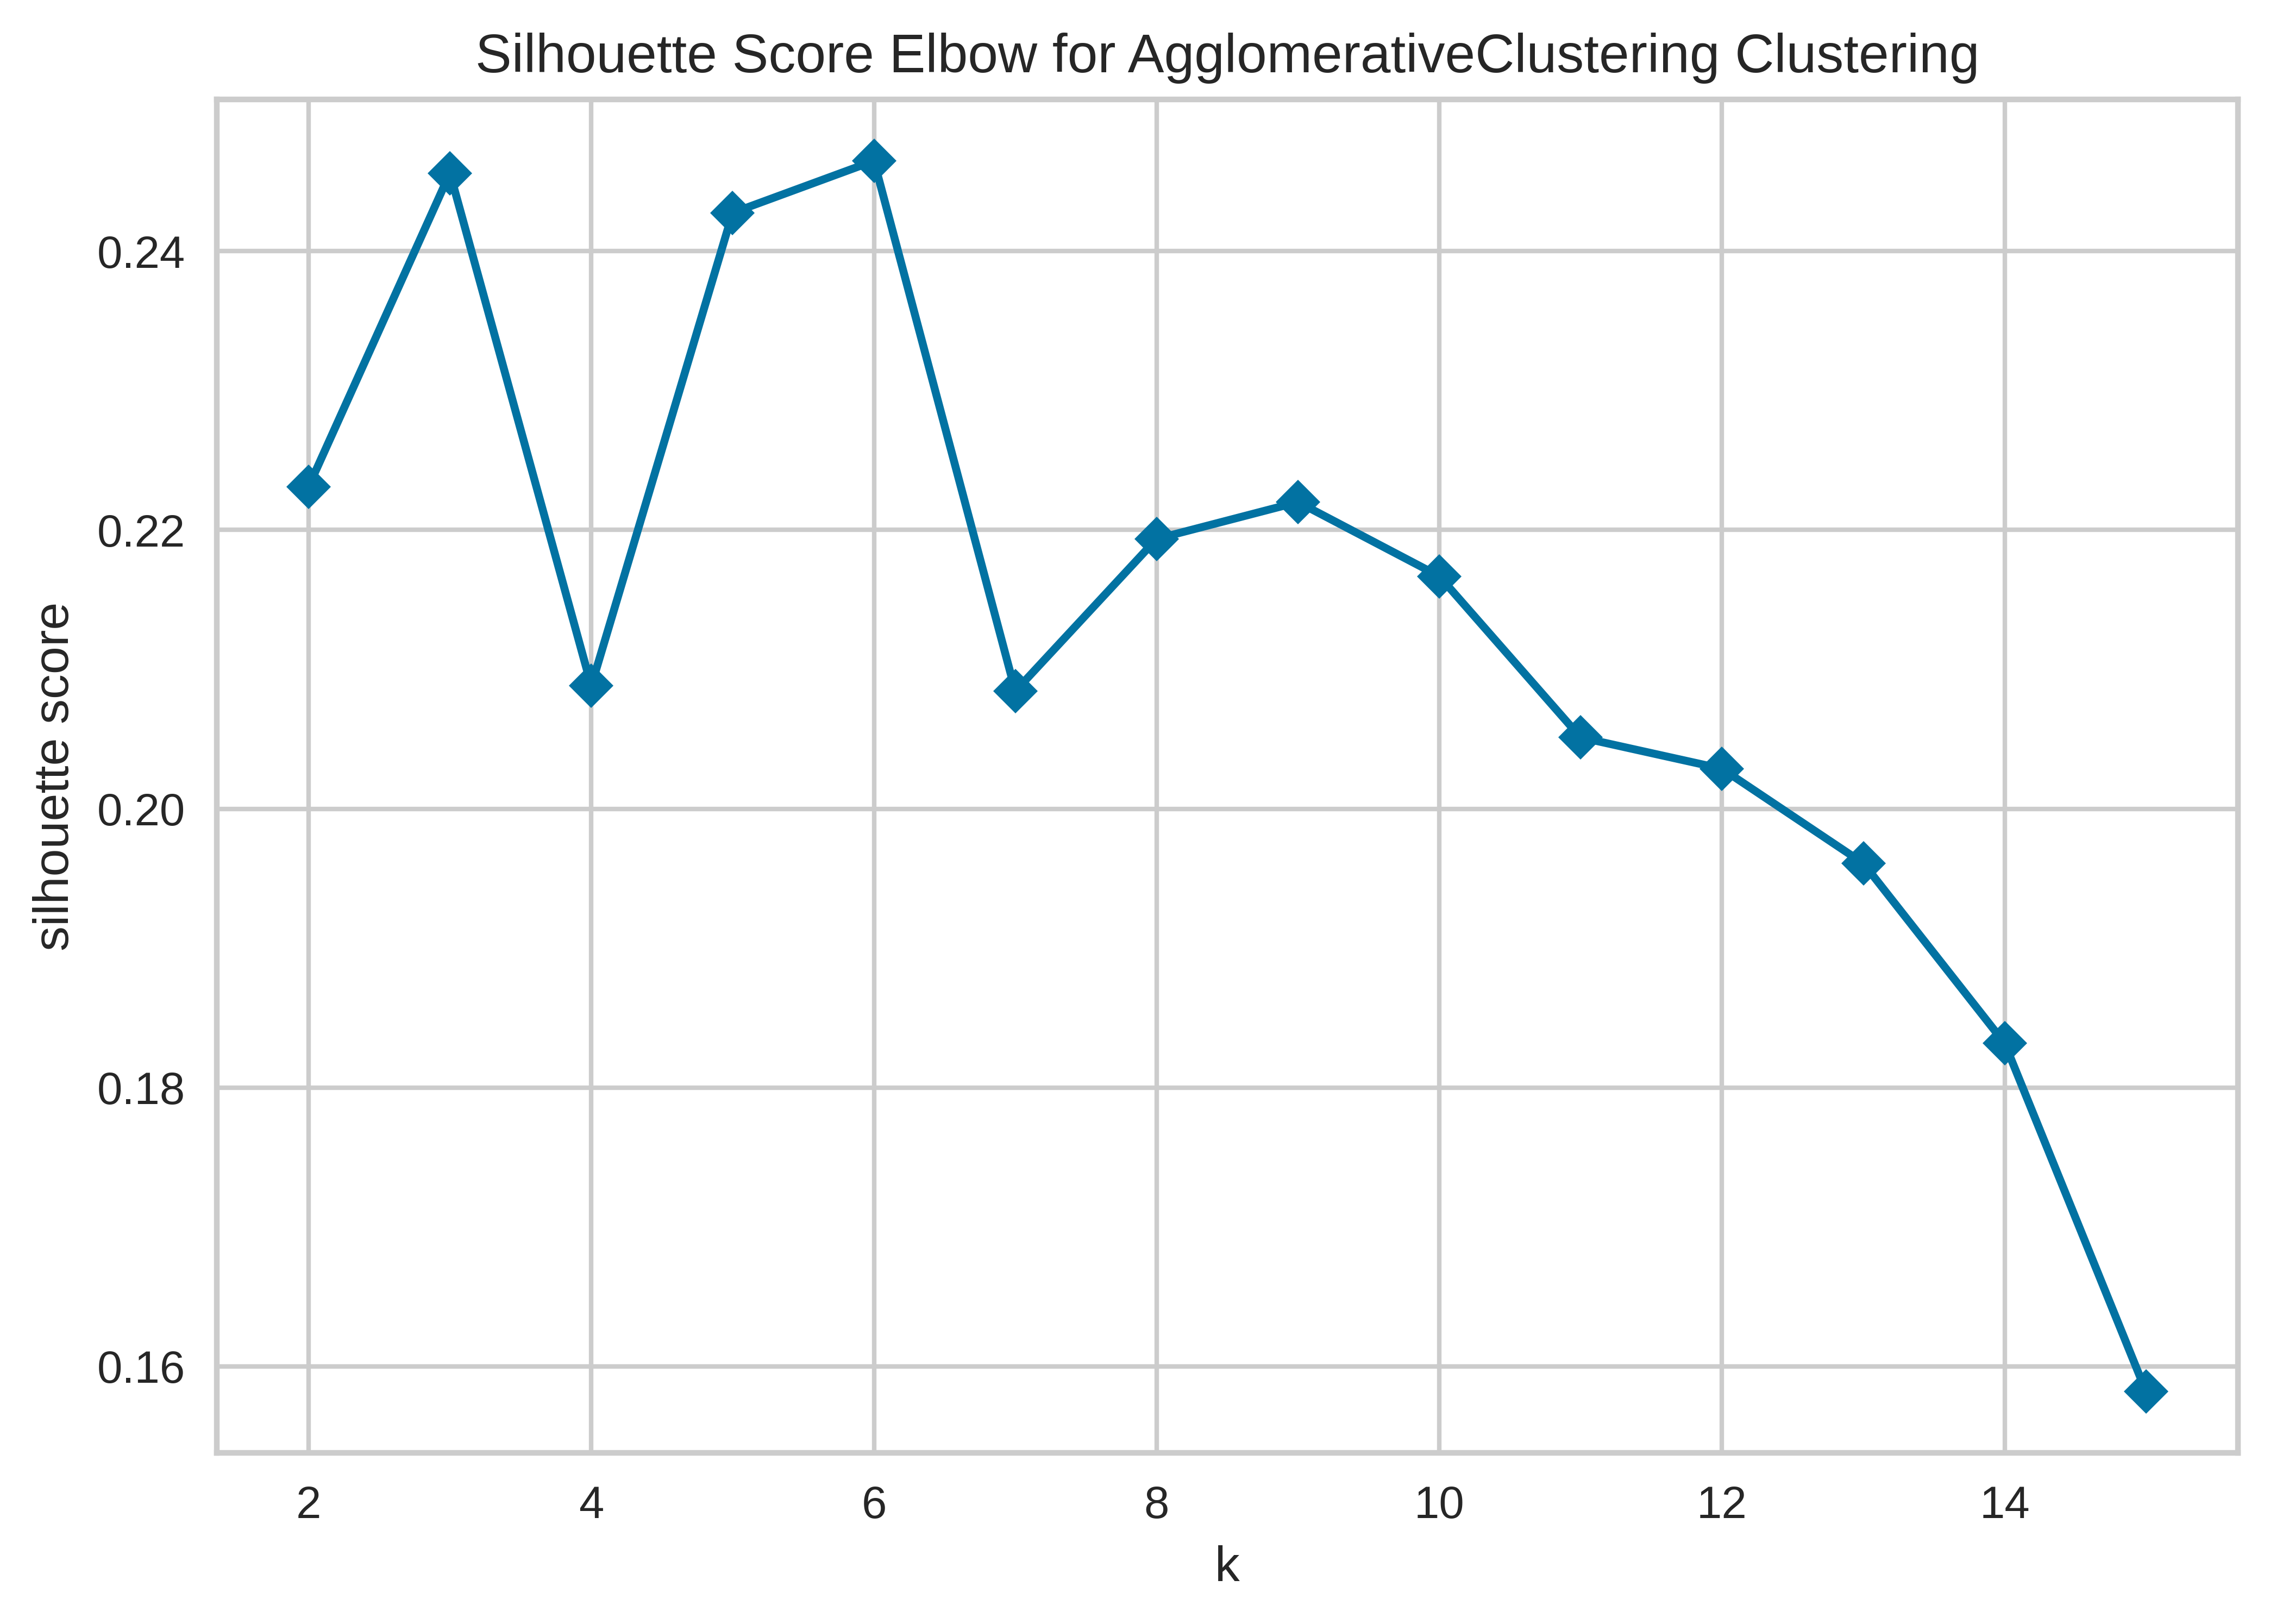

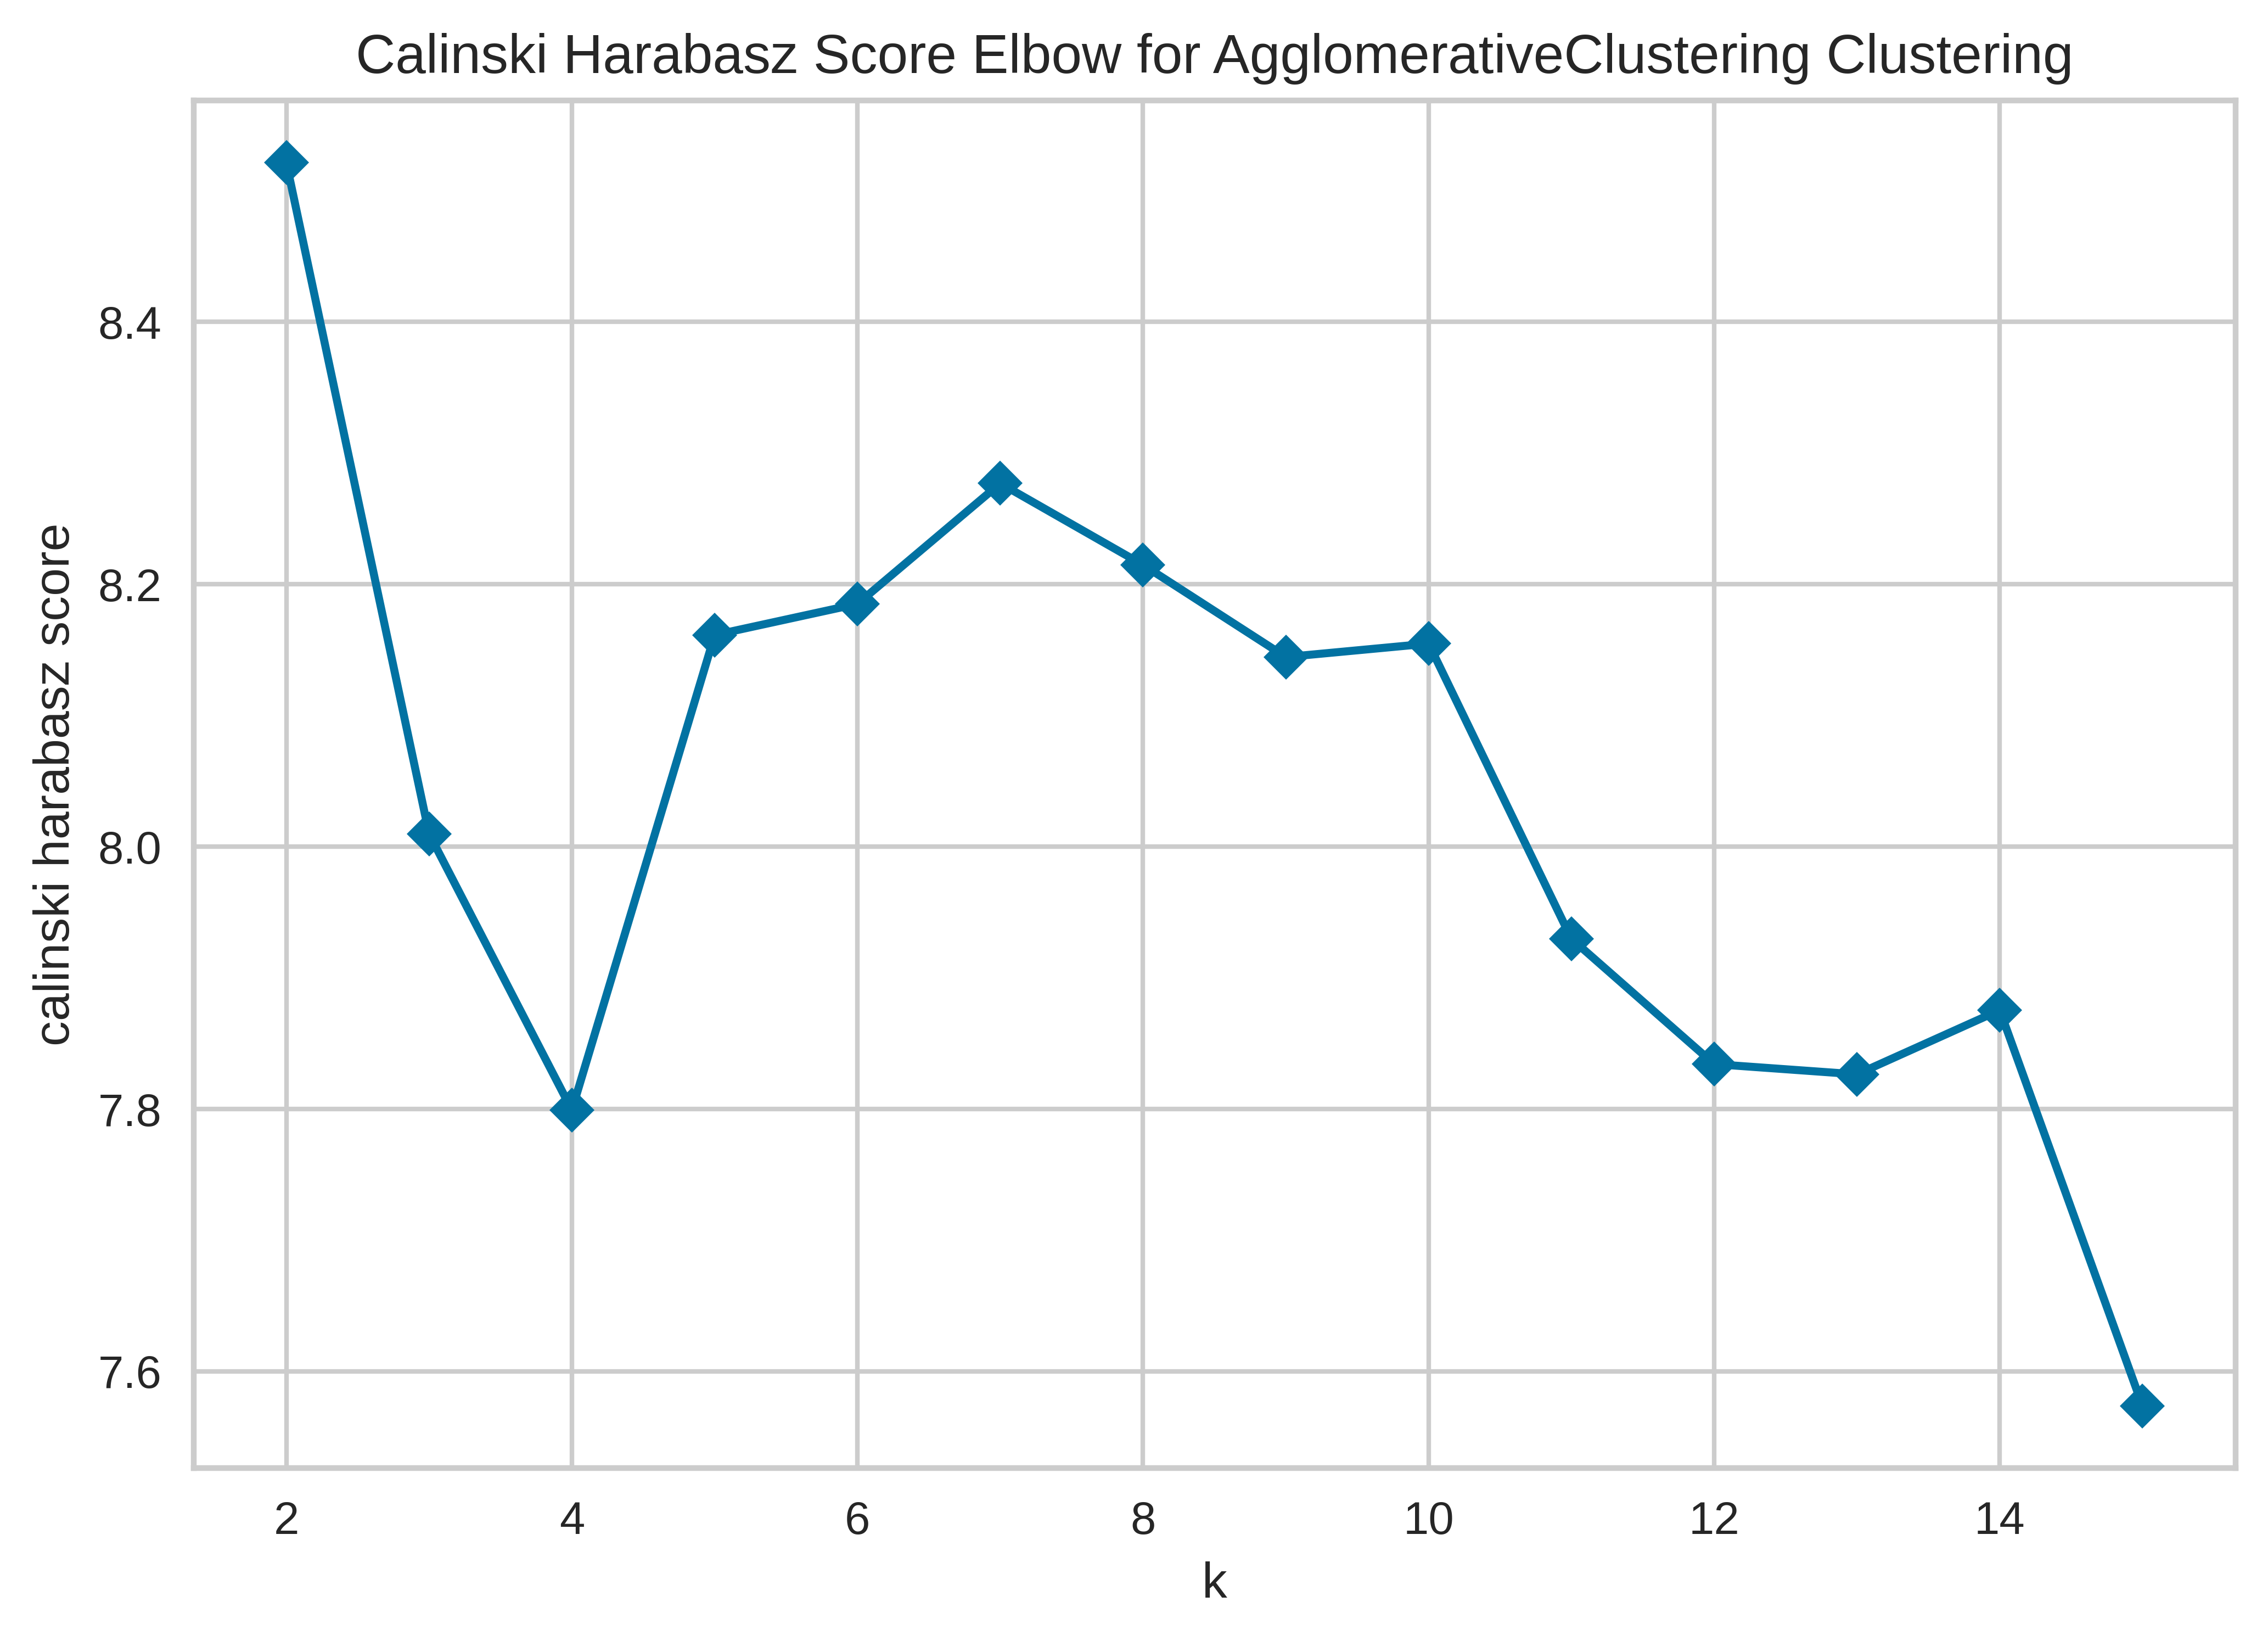

<IPython.core.display.Javascript object>

In [28]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_rohban_img_embs)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_rohban_img_embs)
ax = visualizer.show()


The optimal number of cluster seems to be 10 for our batch-centered JUMP morphological profiles.

In [29]:
model = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="complete")
shared_rohban_img_embs_cluster_labels = model.fit_predict(shared_rohban_img_embs)
shared_rohban_img_embs_clusters = pd.DataFrame(
    shared_rohban_img_embs_cluster_labels,
    index=shared_rohban_img_embs.index,
    columns=["cluster"],
)
shared_rohban_img_embs_clusters.head()

cluster
labels         
IRAK4         9
WWTR1         2
SMAD4         9
MAP3K5        4
RHOA          6

<IPython.core.display.Javascript object>

---
## Rohban morphological profiles



In [30]:
shared_rohban_morph_profiles = rohban_morph_profiles.loc[shared_genes]

<IPython.core.display.Javascript object>

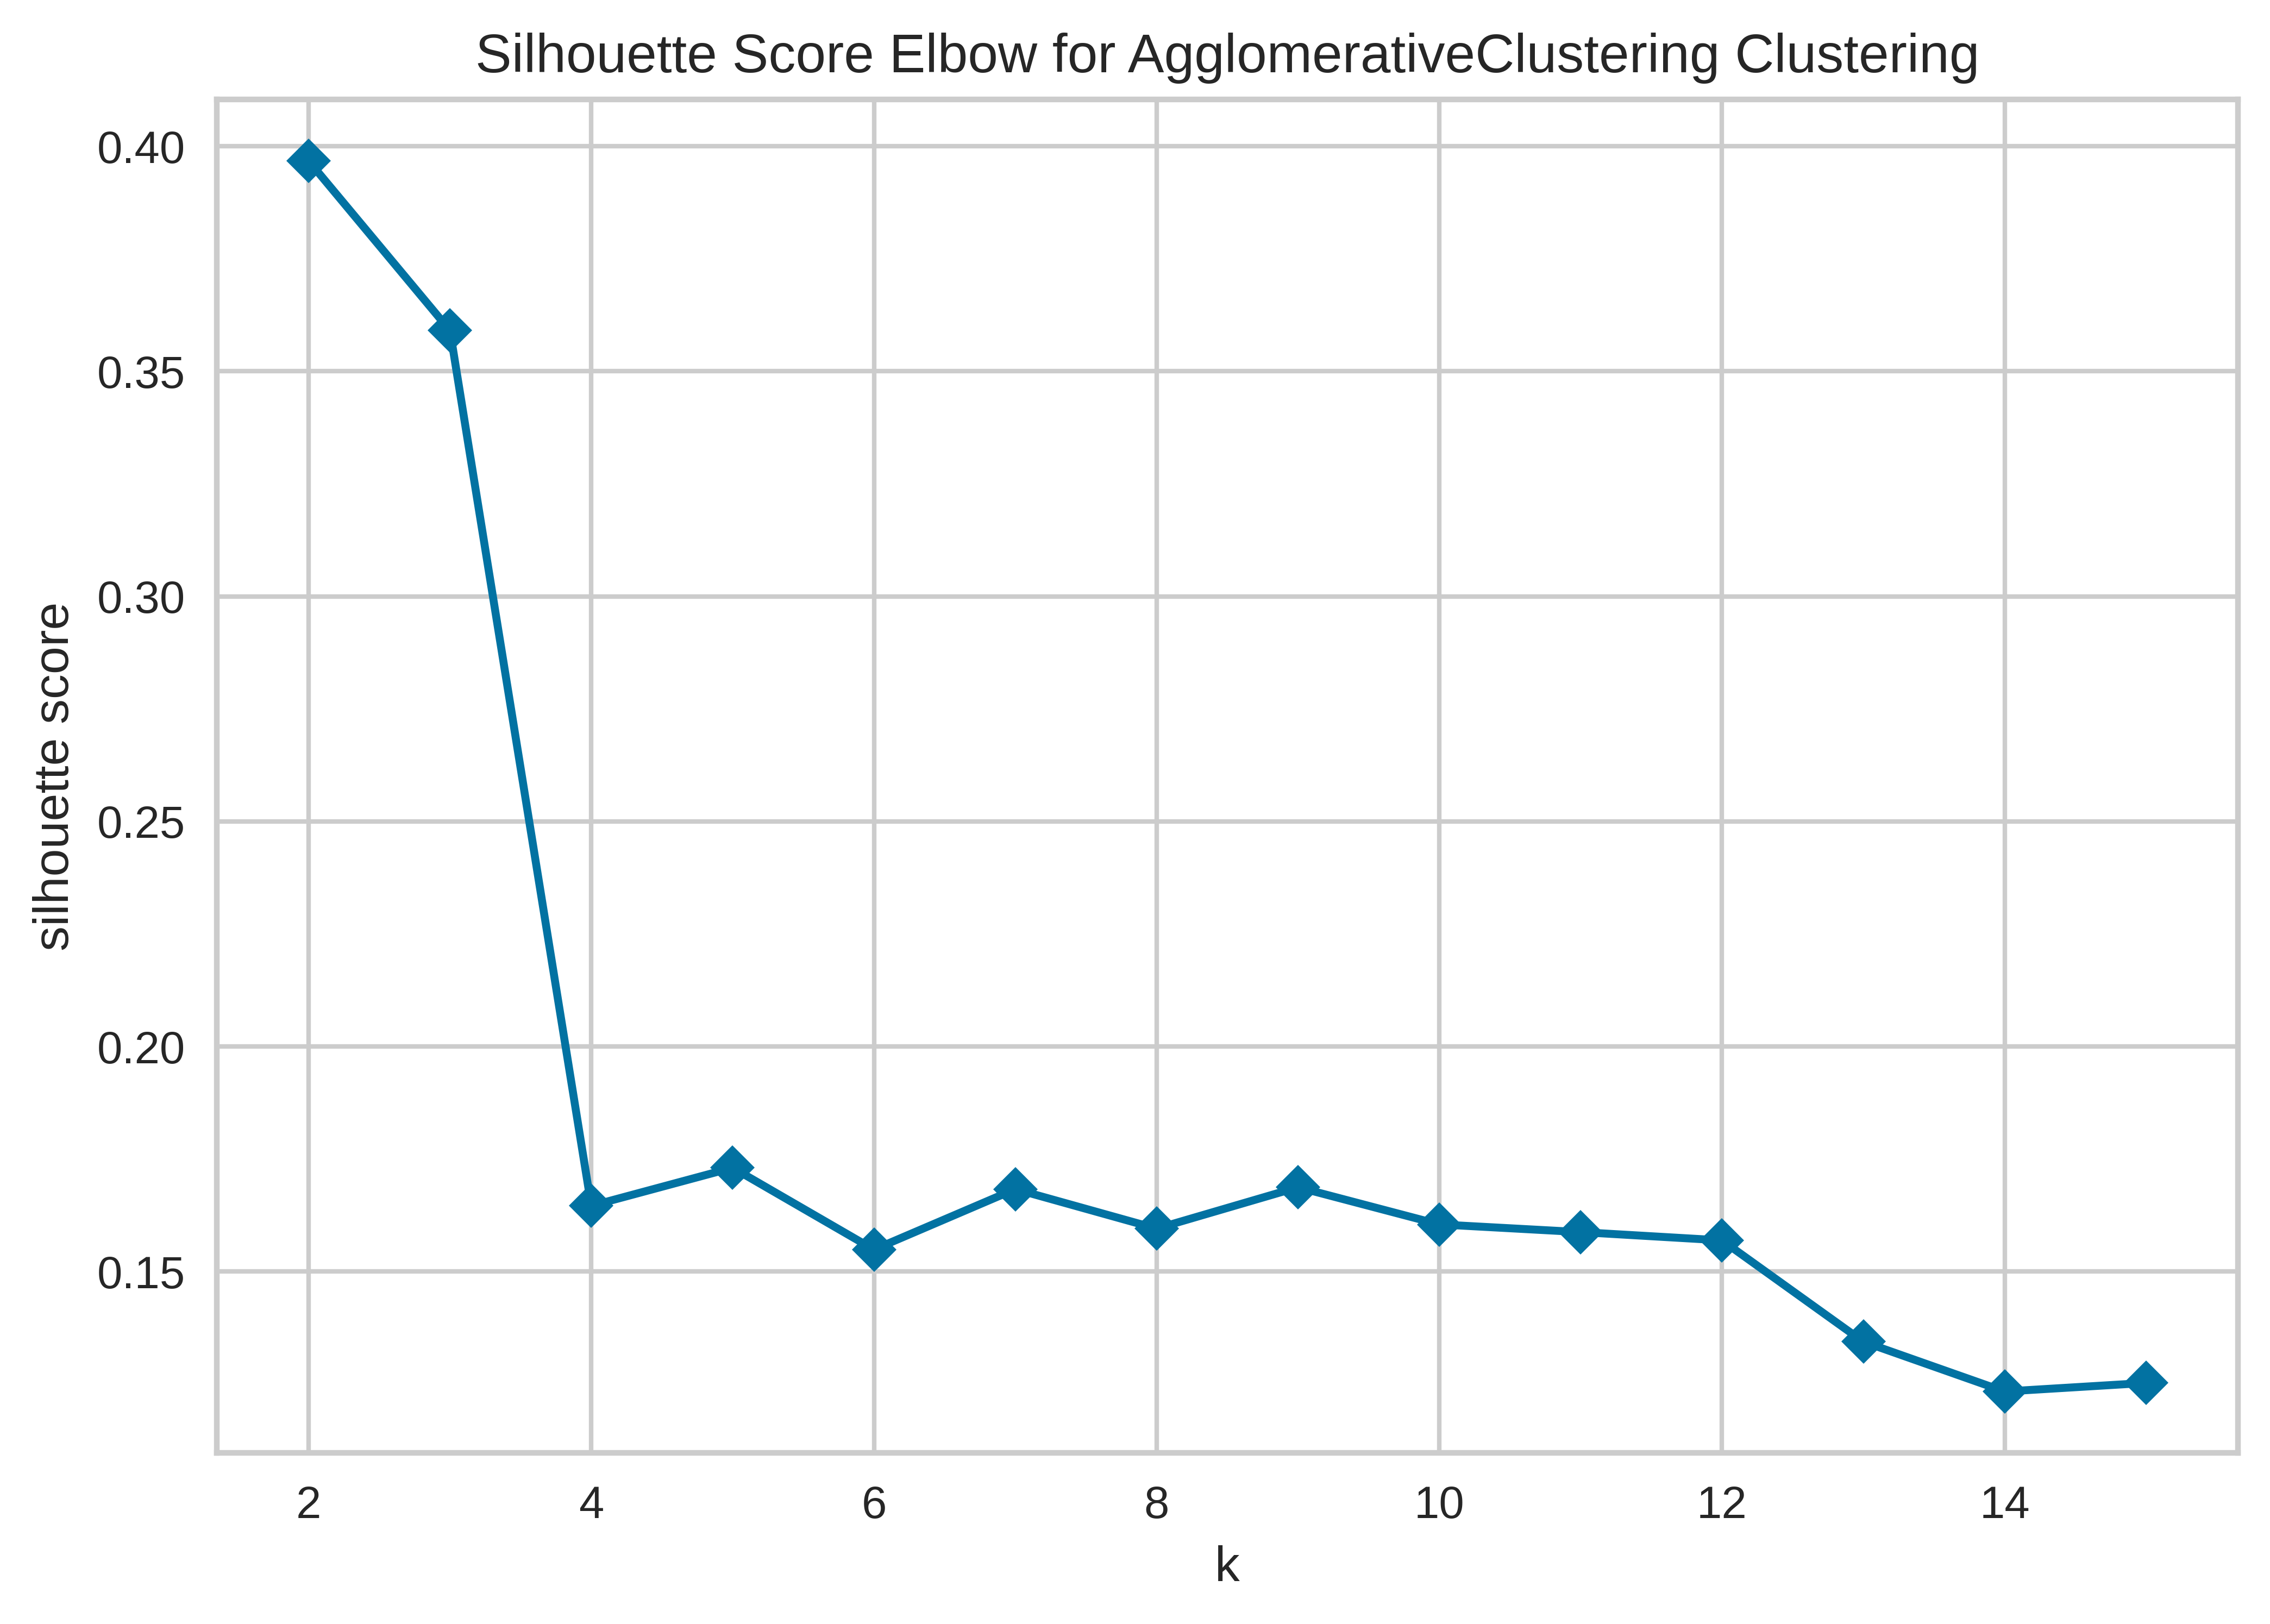

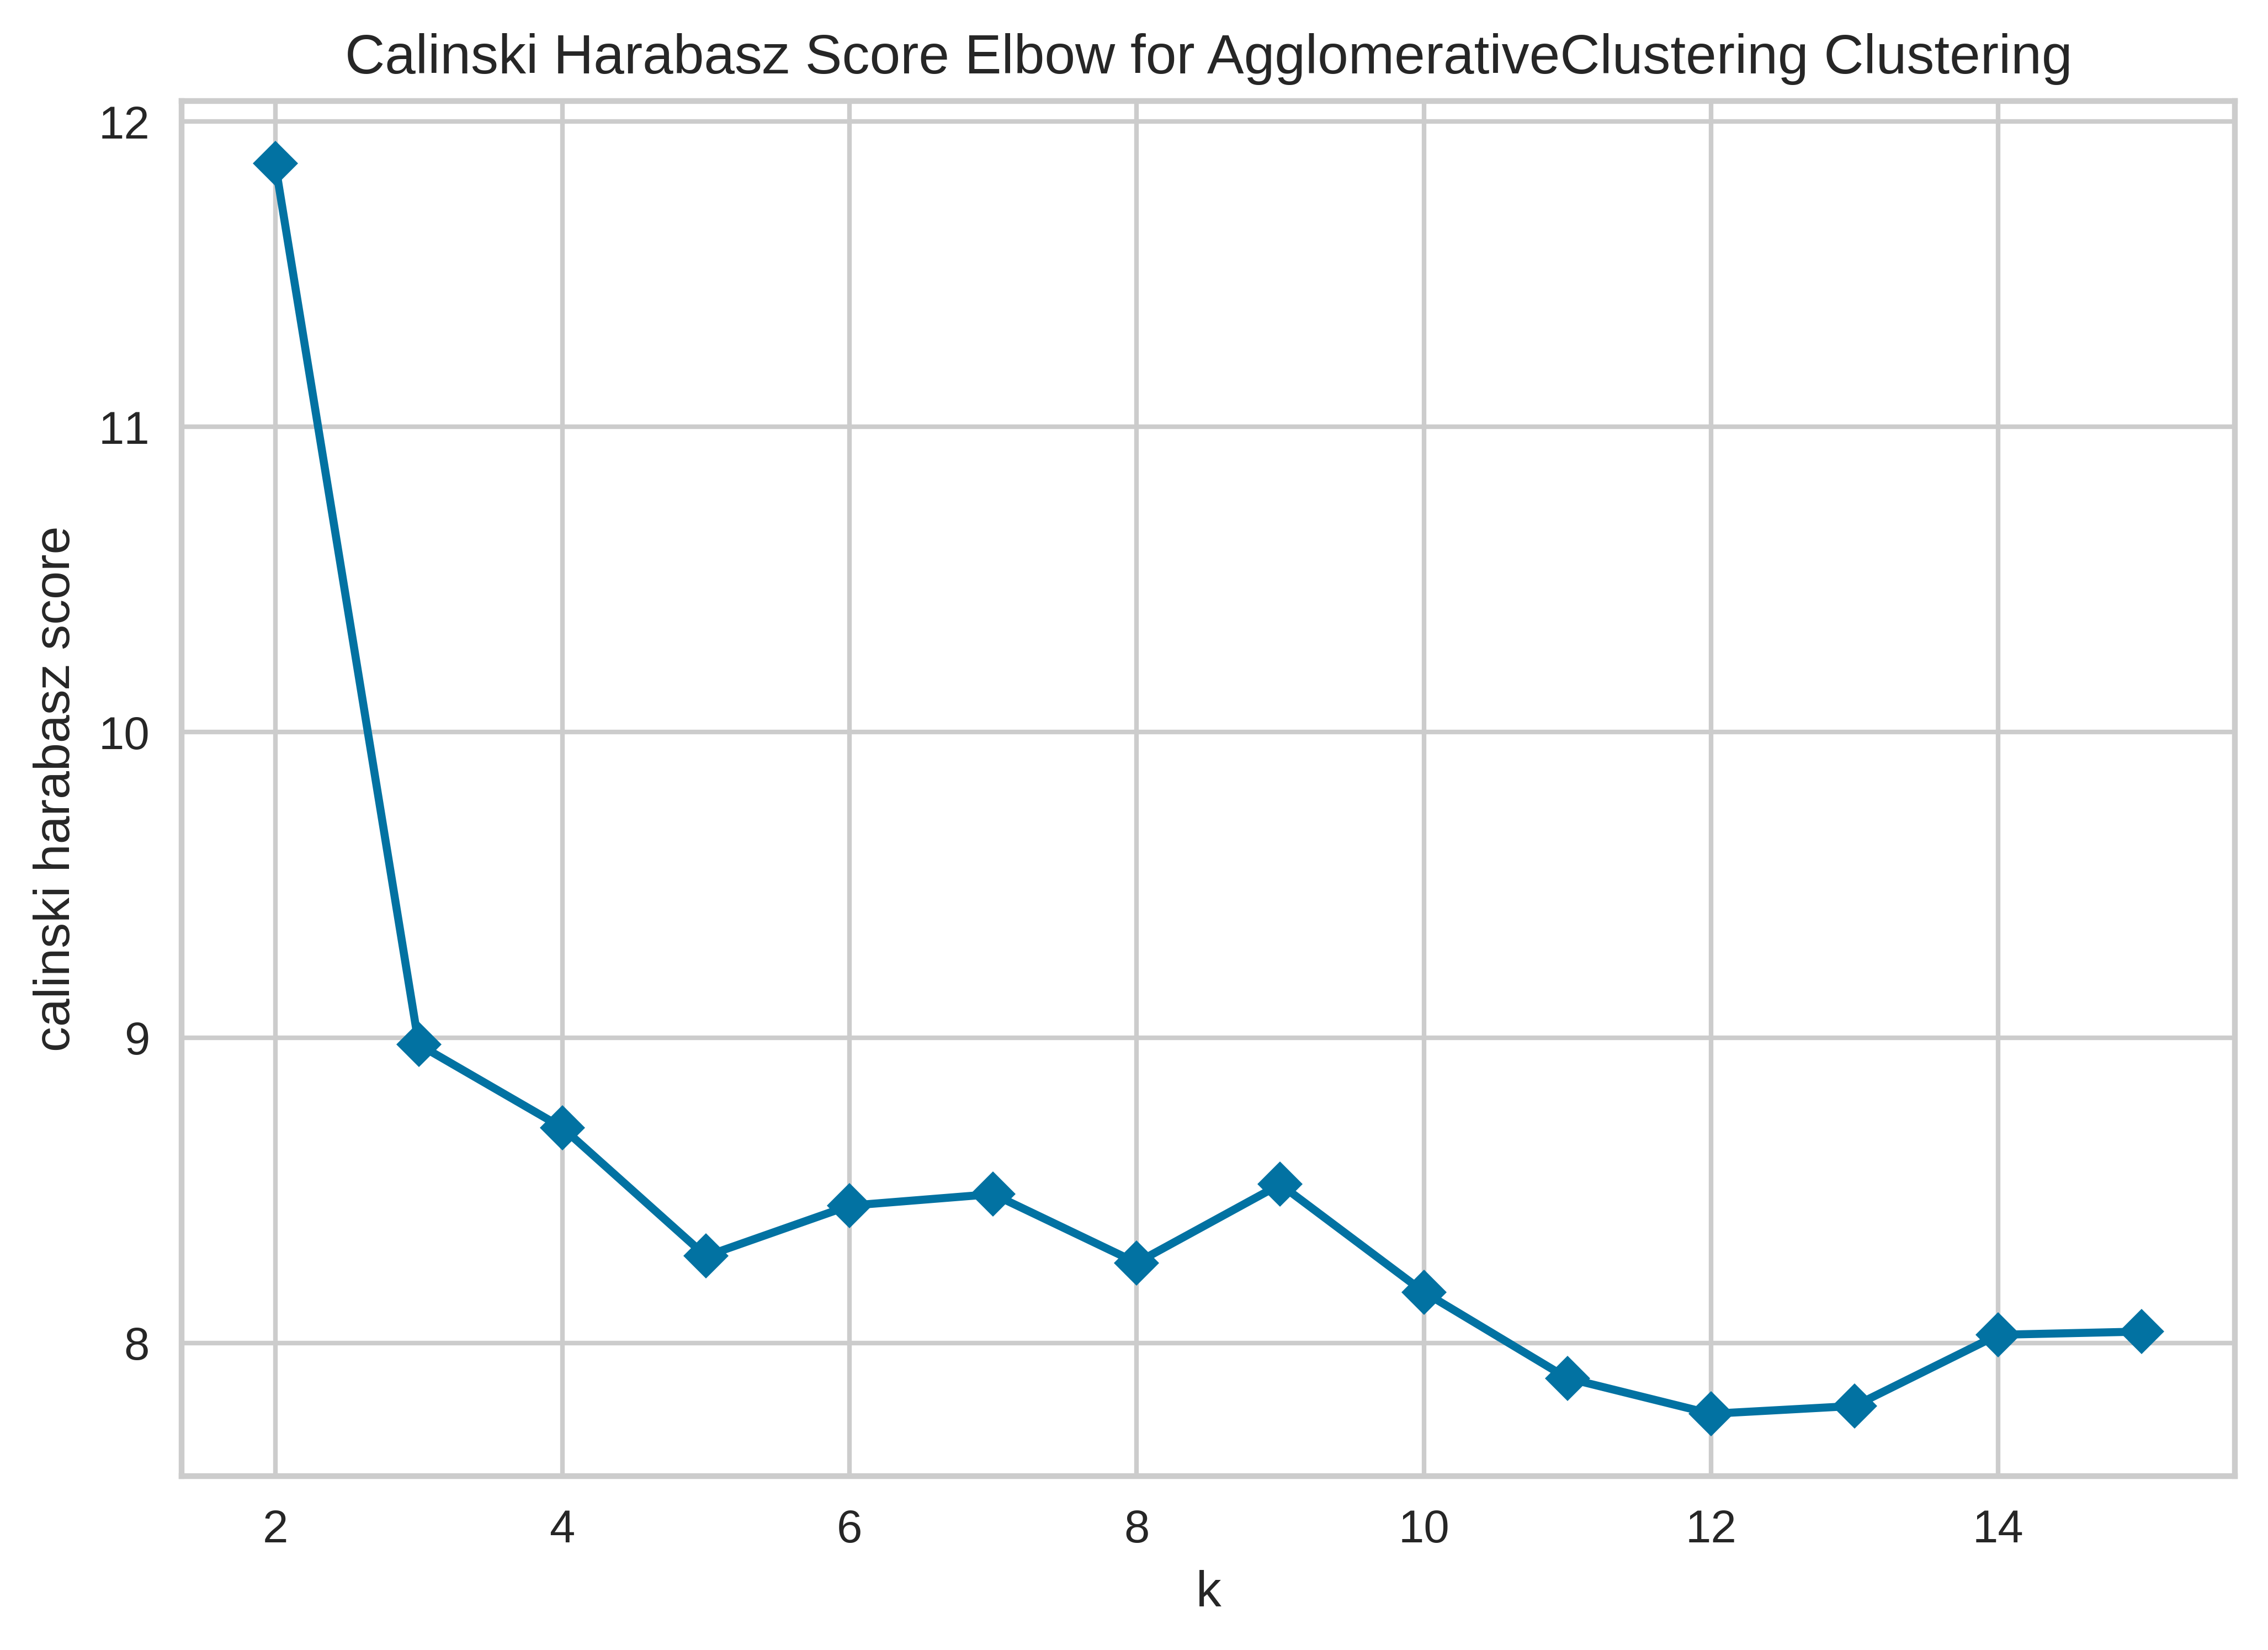

<IPython.core.display.Javascript object>

In [31]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_rohban_morph_profiles)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_rohban_morph_profiles)
ax = visualizer.show()


The optimal number of cluster seems to be 9 for our batch-centered JUMP morphological profiles.

In [32]:
model = AgglomerativeClustering(n_clusters=9, affinity="euclidean", linkage="complete")
shared_rohban_morph_embs_cluster_labels = model.fit_predict(
    shared_rohban_morph_profiles
)
shared_rohban_morph_embs_clusters = pd.DataFrame(
    shared_rohban_morph_embs_cluster_labels,
    index=shared_jump_morph_embs.index,
    columns=["cluster"],
)
shared_rohban_morph_embs_clusters.head()

cluster
Metadata_Symbol         
IRAK4                  2
WWTR1                  2
SMAD4                  2
MAP3K5                 2
RHOA                   7

<IPython.core.display.Javascript object>

---

## CMap signatures

In [33]:
shared_cmap_sigs = cmap_sigs.loc[shared_genes]

<IPython.core.display.Javascript object>

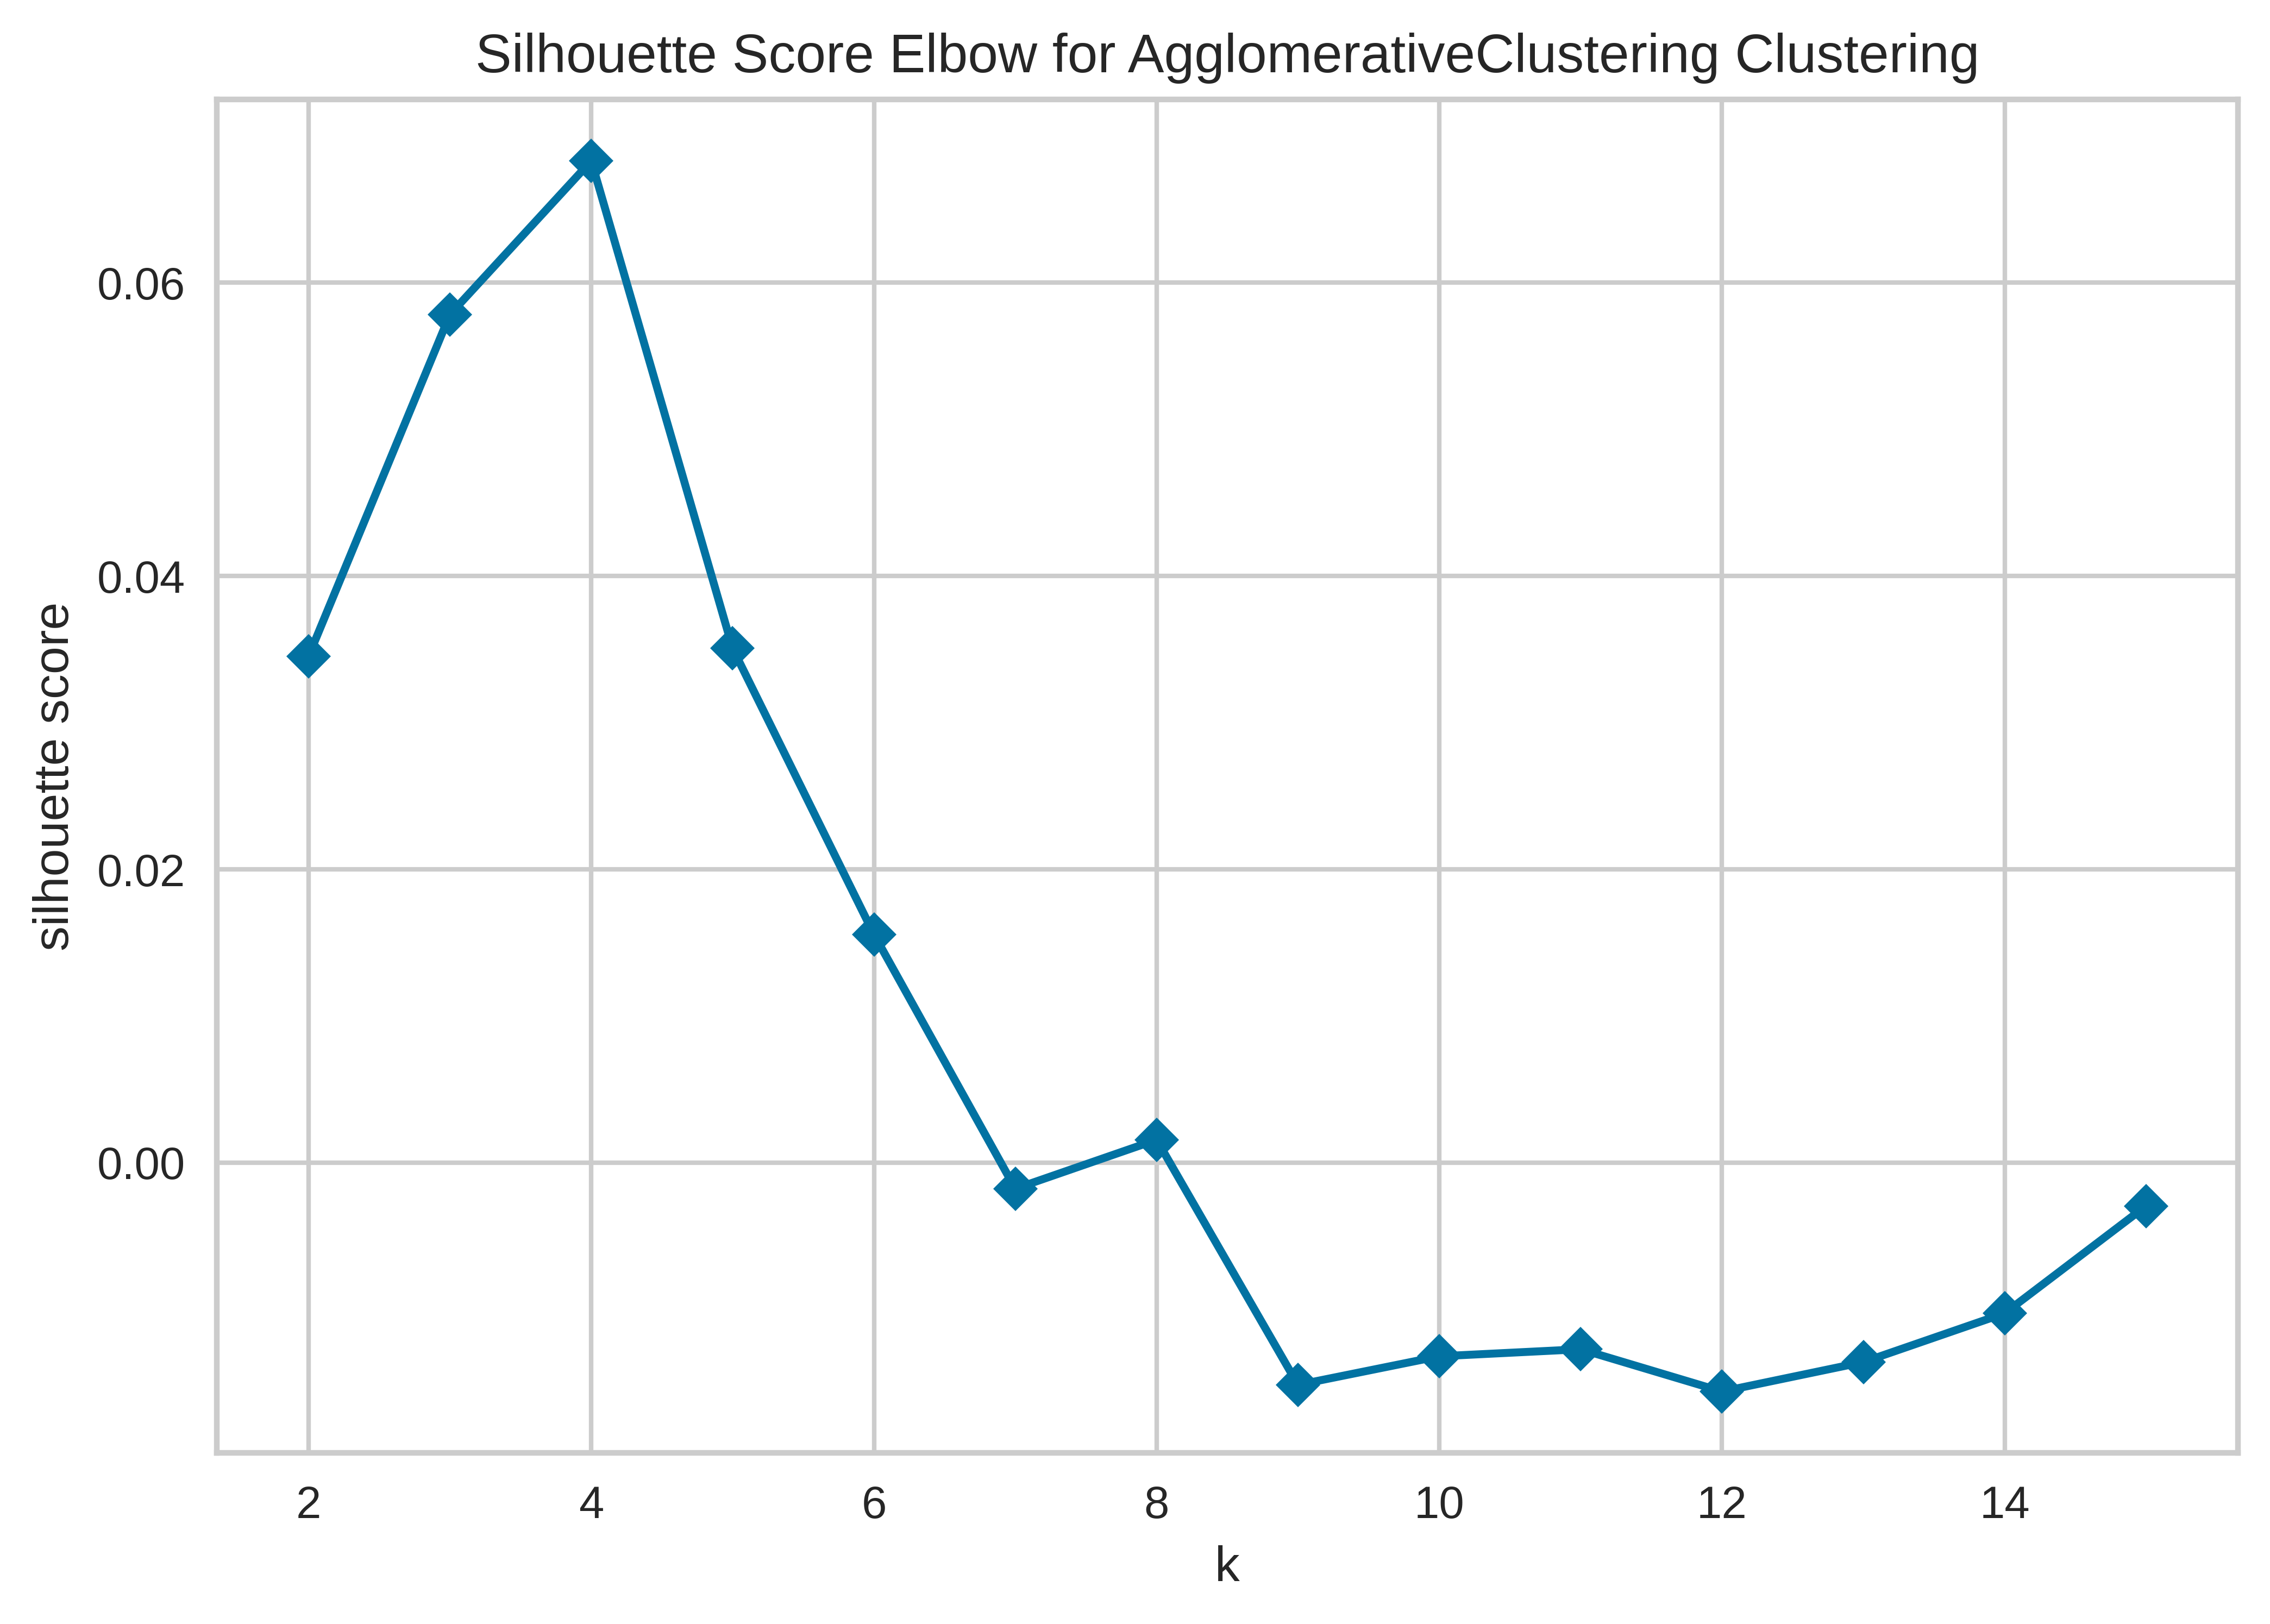

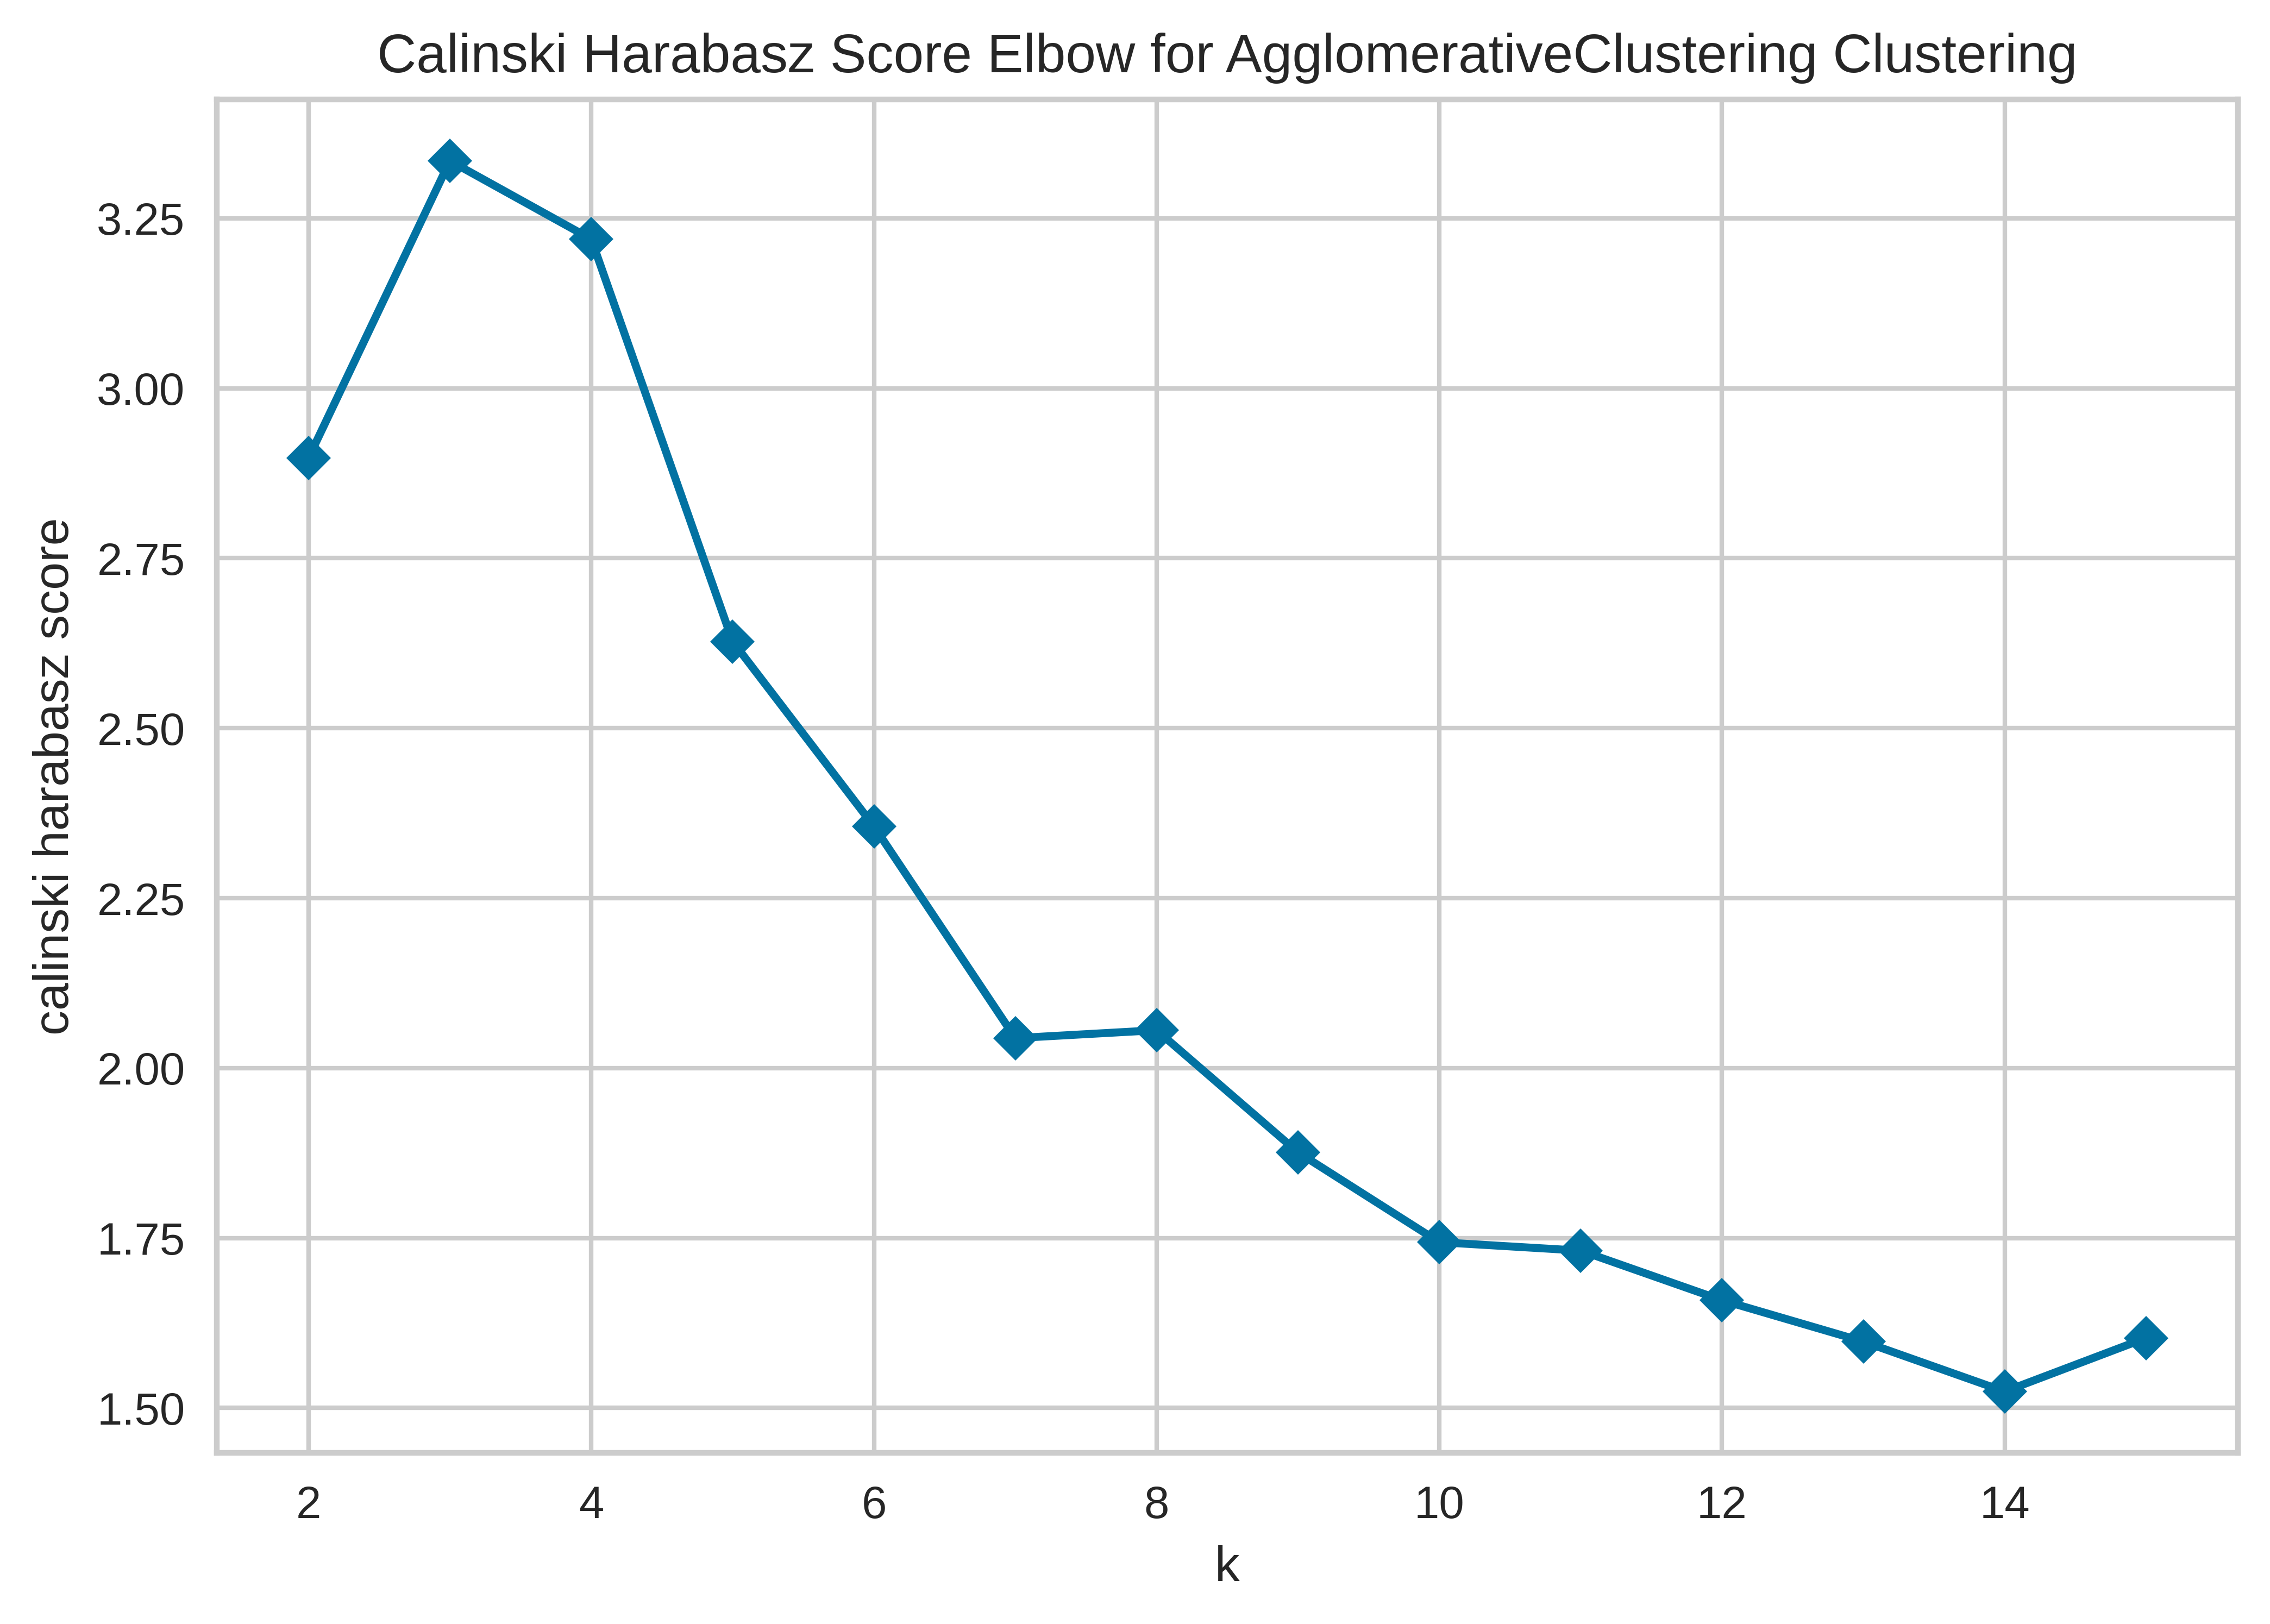

<IPython.core.display.Javascript object>

In [34]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_cmap_sigs)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_cmap_sigs)
ax = visualizer.show()


The optimal number of cluster seems to be 8 for our batch-centered JUMP morphological profiles.

In [35]:
model = AgglomerativeClustering(n_clusters=8, affinity="cosine", linkage="complete")
shared_cmap_sigs_cluster_labels = model.fit_predict(shared_cmap_sigs)
shared_cmap_sigs_clusters = pd.DataFrame(
    shared_cmap_sigs_cluster_labels,
    index=shared_cmap_sigs.index,
    columns=["cluster"],
)
shared_cmap_sigs_clusters.head()

cluster
labels         
IRAK4         1
WWTR1         0
SMAD4         4
MAP3K5        1
RHOA          3

<IPython.core.display.Javascript object>

---

## Regulatory gene embeddings (using CMap information)

In [36]:
shared_reg_embs = reg_embs.loc[shared_genes]

<IPython.core.display.Javascript object>

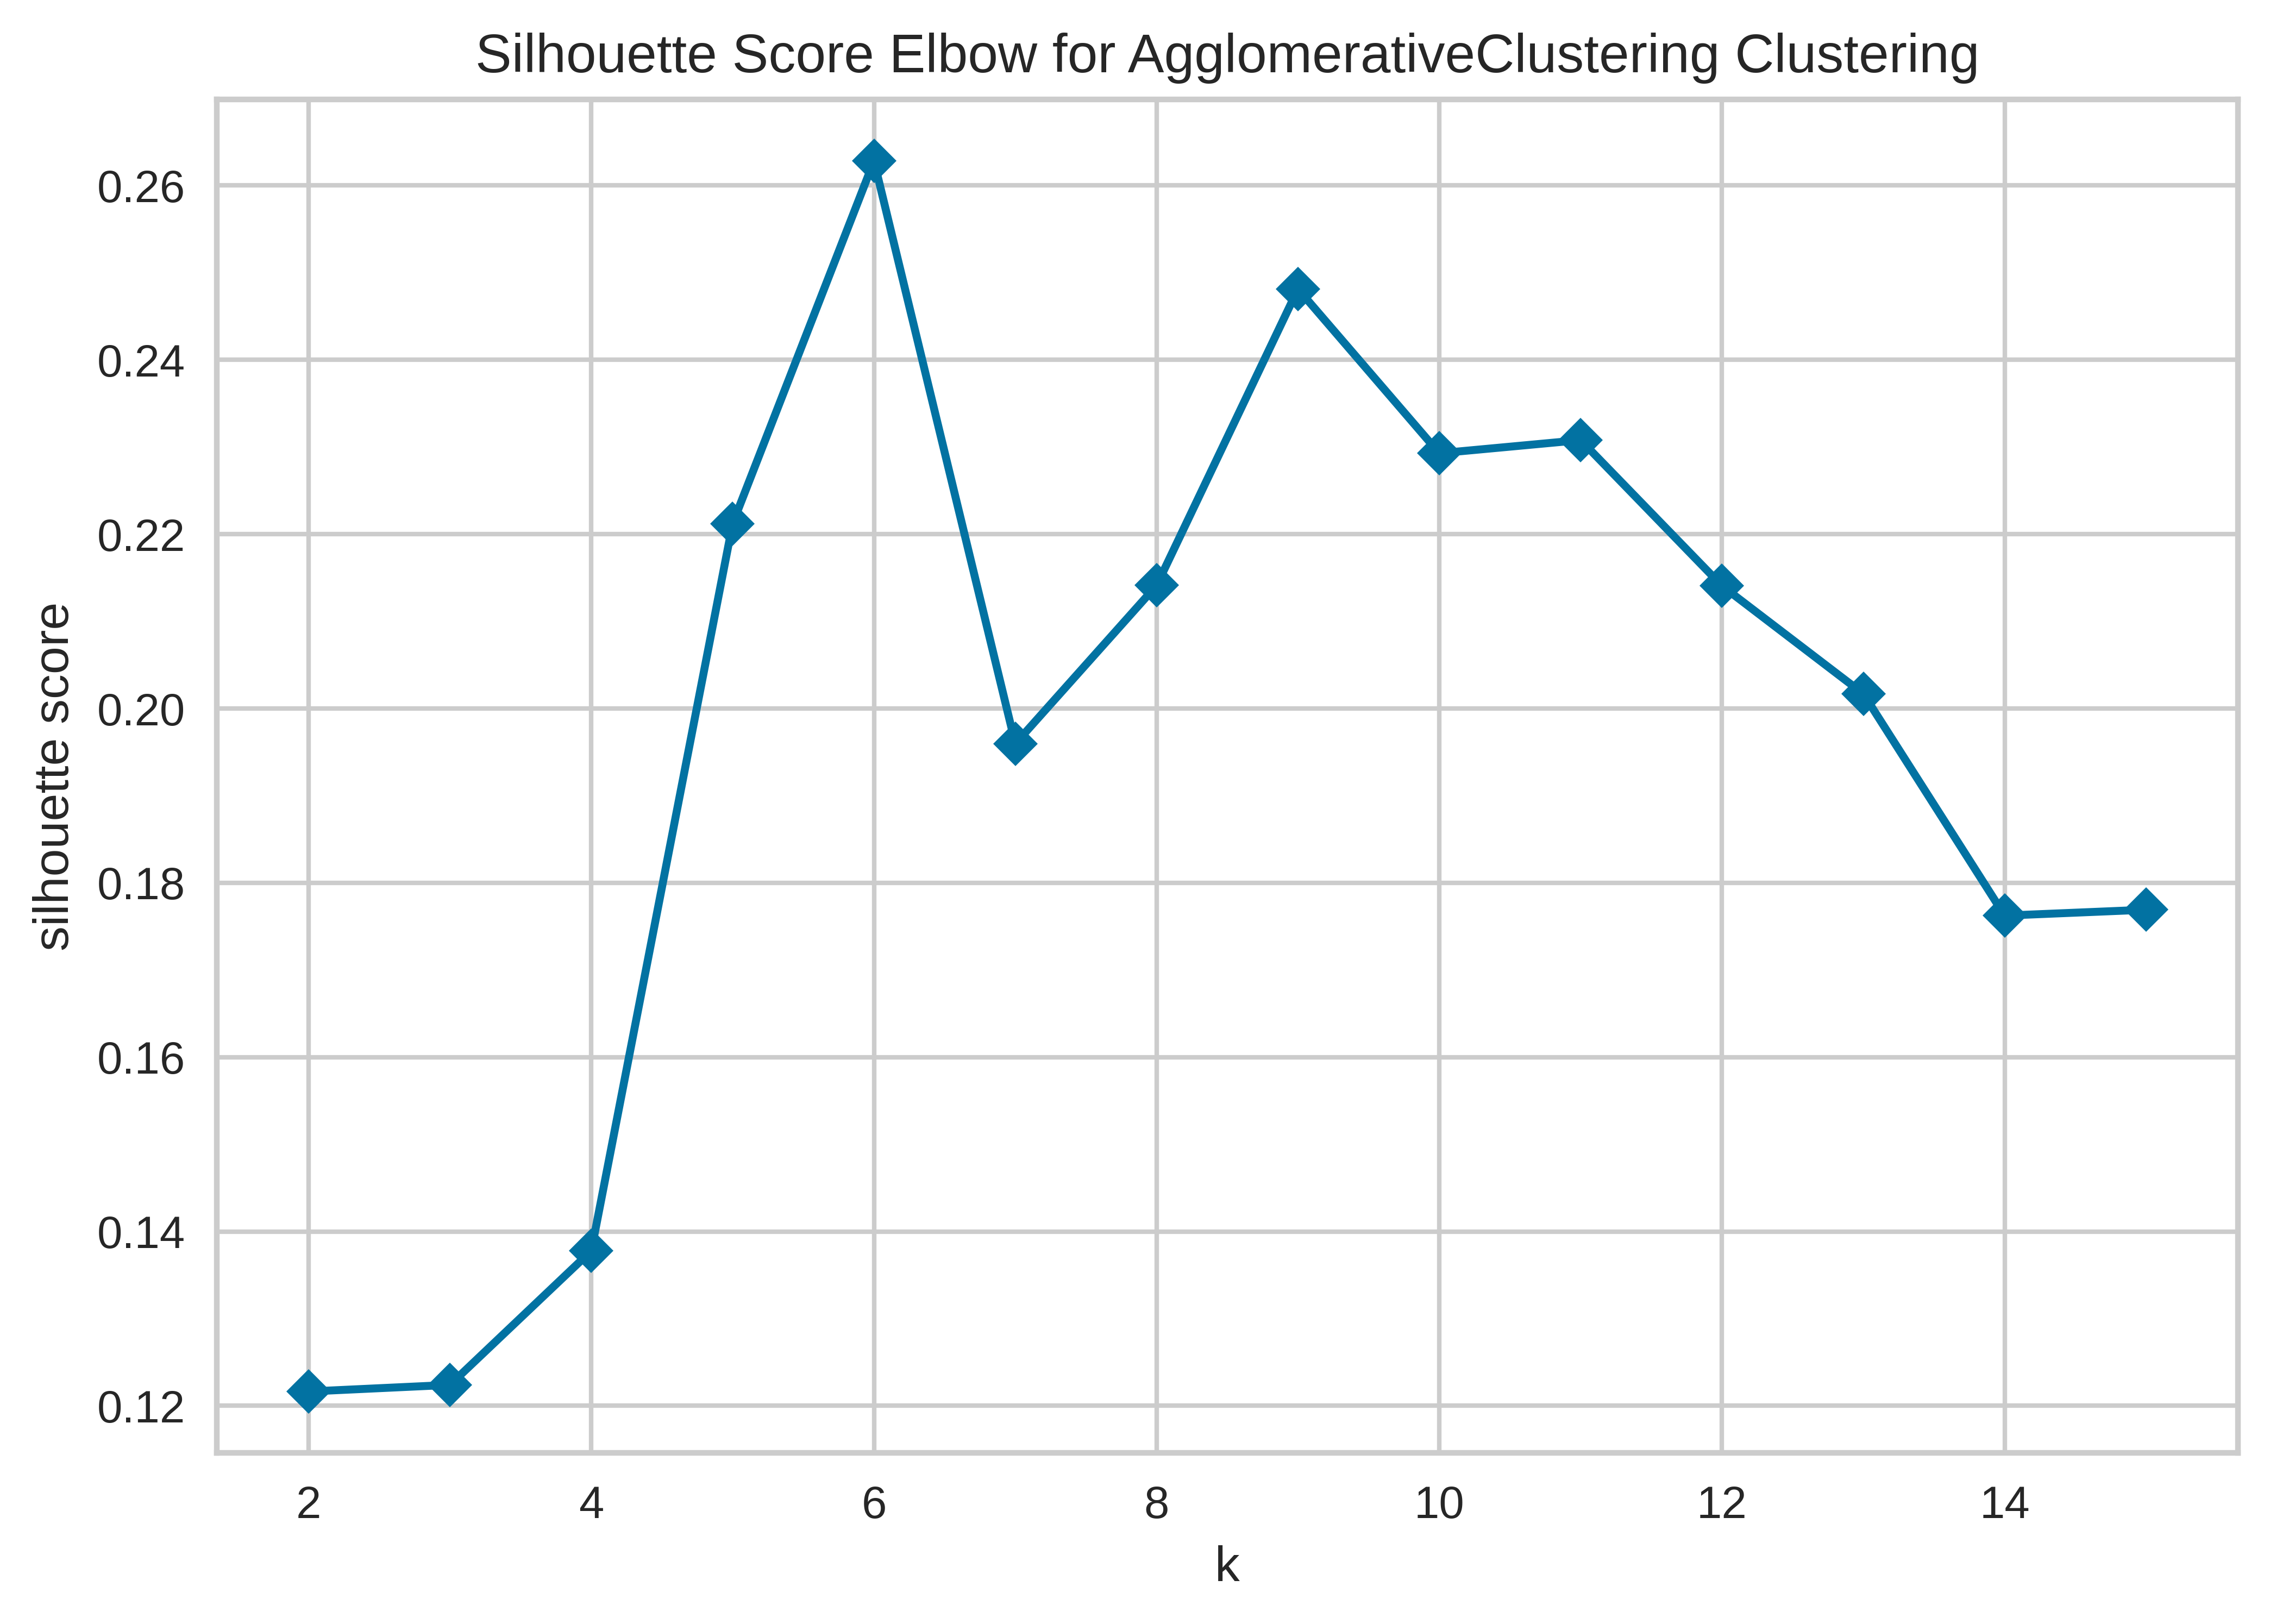

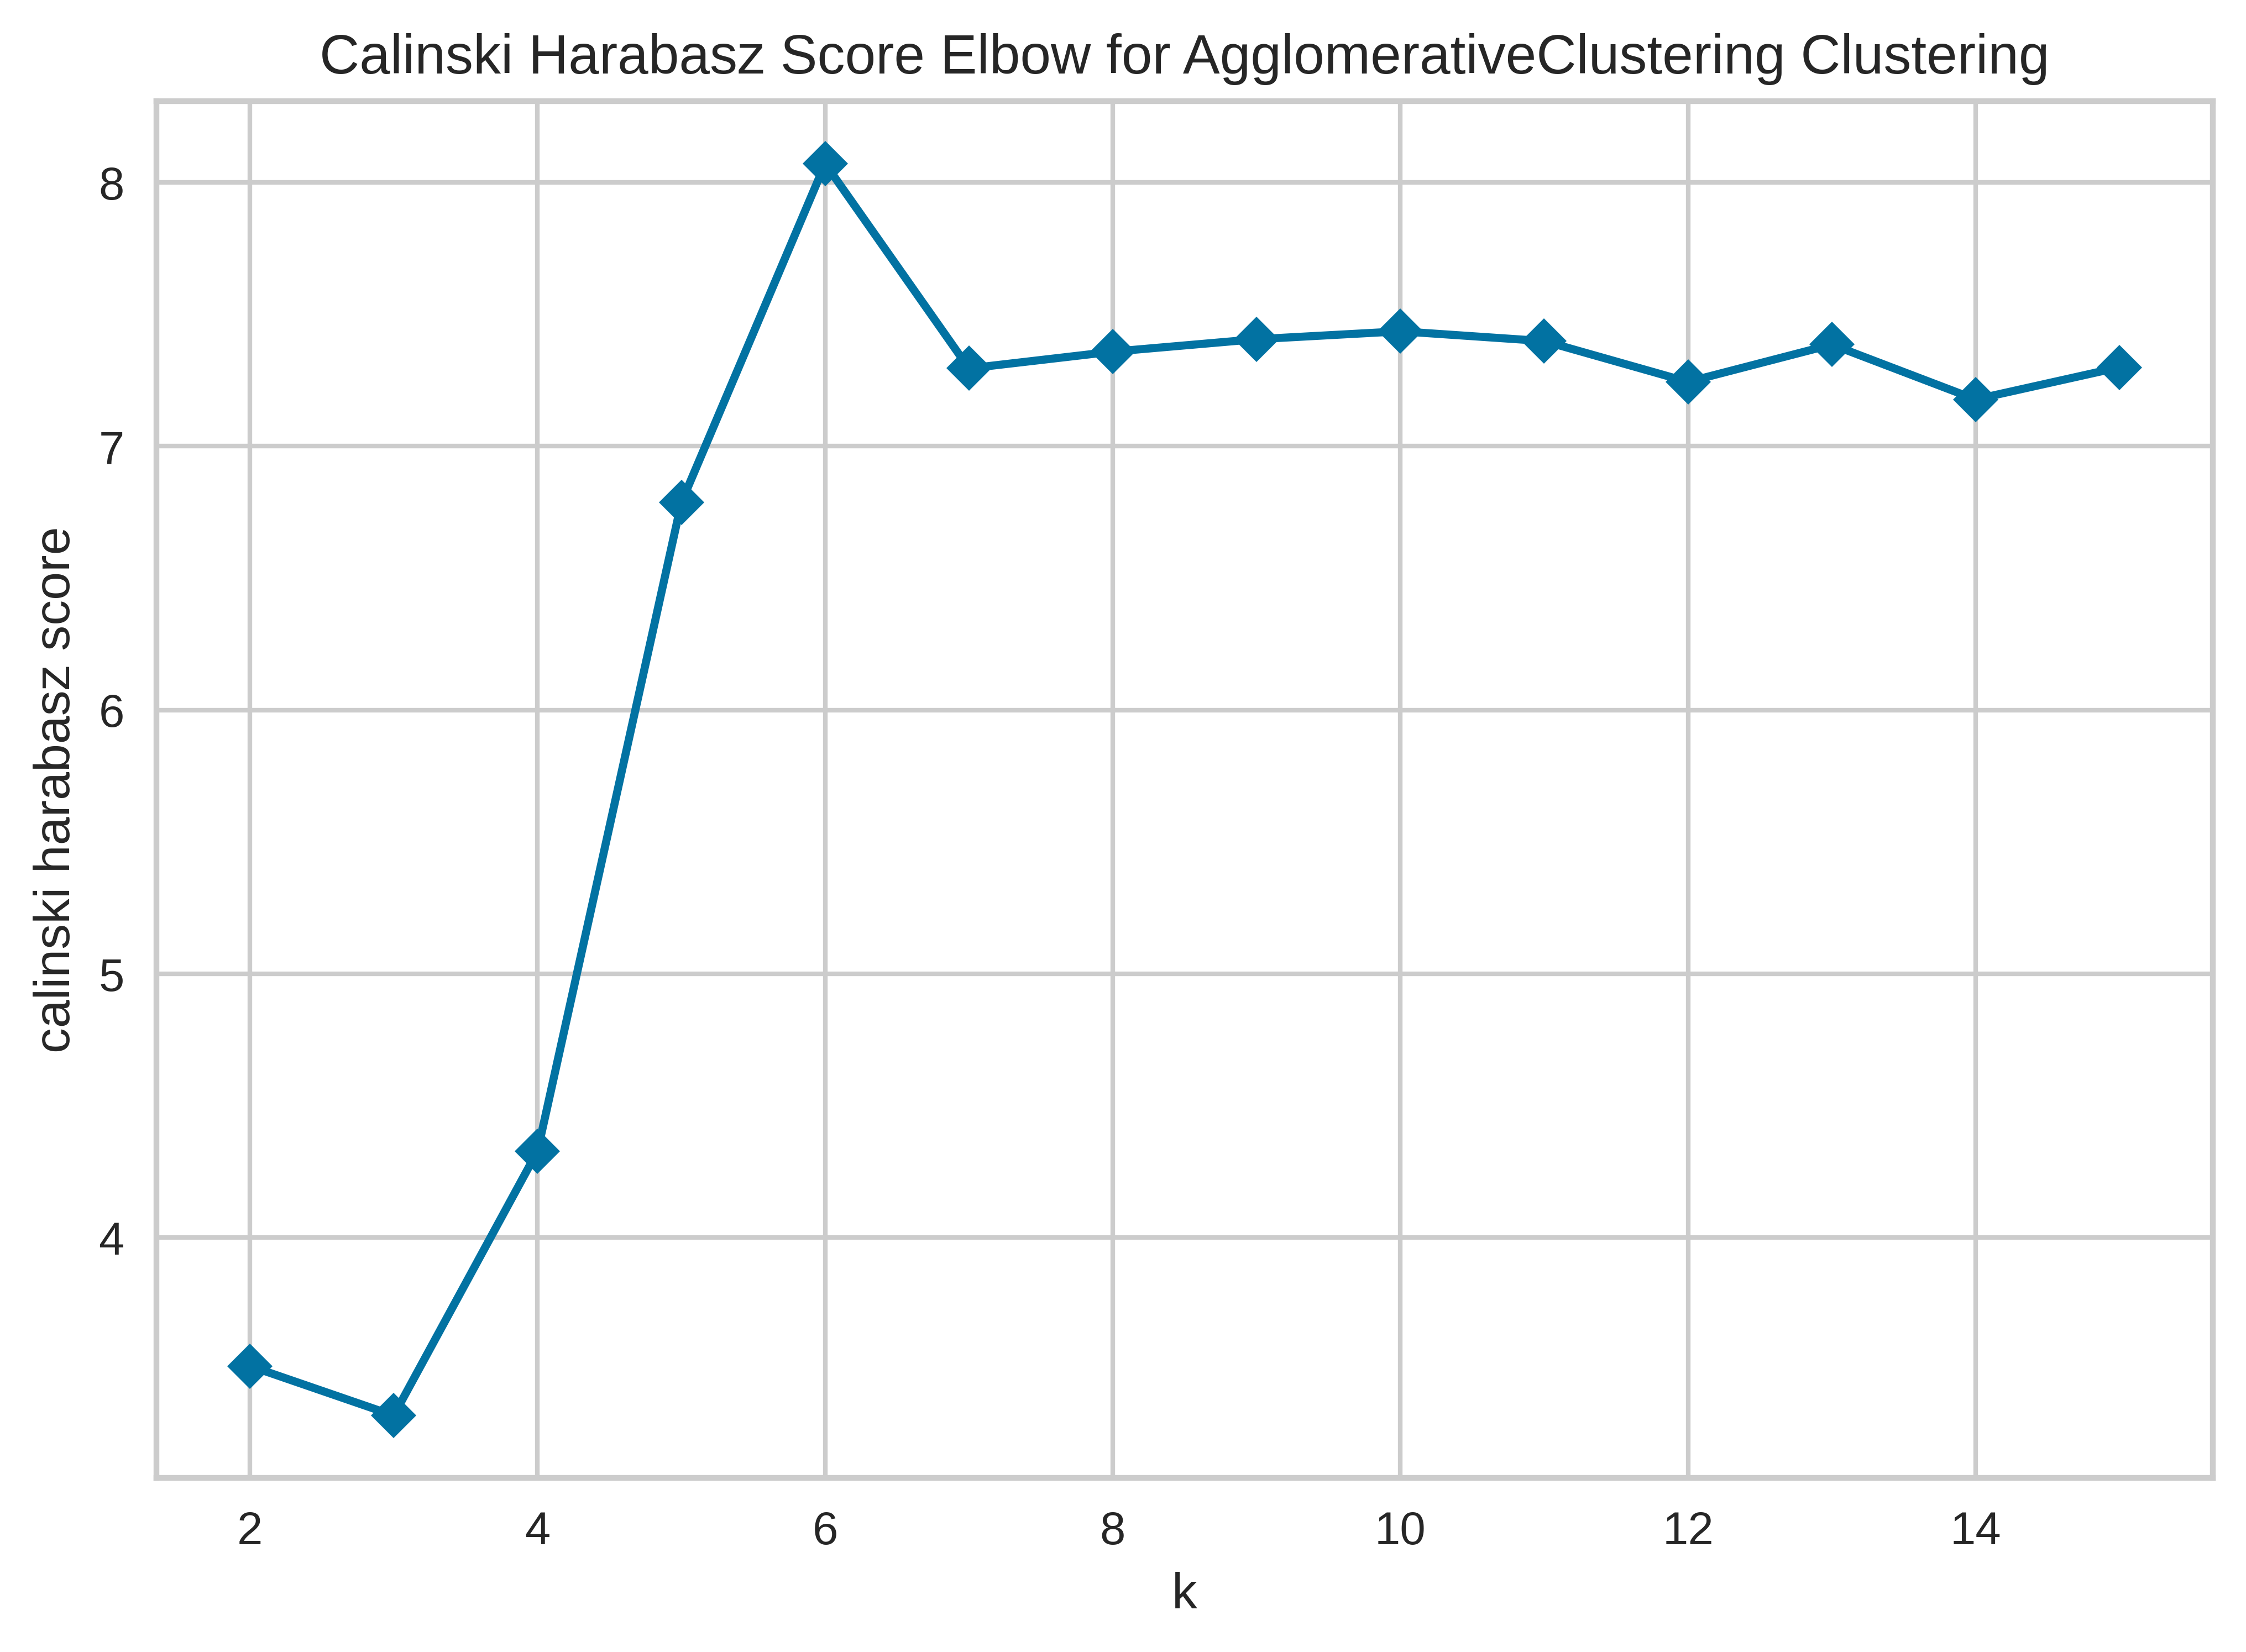

<IPython.core.display.Javascript object>

In [37]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(shared_reg_embs)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(shared_reg_embs)
ax = visualizer.show()


The optimal number of cluster seems to be 9 for our batch-centered JUMP morphological profiles.

In [38]:
model = AgglomerativeClustering(n_clusters=9, affinity="cosine", linkage="complete")
shared_reg_embs_cluster_labels = model.fit_predict(shared_reg_embs)
shared_reg_embs_clusters = pd.DataFrame(
    shared_reg_embs_cluster_labels,
    index=shared_reg_embs.index,
    columns=["cluster"],
)
shared_reg_embs_clusters.head()

cluster
IRAK4         3
WWTR1         5
SMAD4         1
MAP3K5        8
RHOA          2

<IPython.core.display.Javascript object>

---

# Co-clustering of the different profiles, signatures and embeddings

We will now assess the co-clustering of the different embeddings using their optimal cluster solutions computed in the previous section.

In [39]:
all_cluster_solutions = {
    "JUMP image embeddings": shared_jump_img_embs_clusters,
    "Batch-centered JUMP image embeddings": shared_jump_img_embs_bc_clusters,
    "INSP-corrected JUMP image embeddings": shared_jump_img_embs_insp_clusters,
    "JUMP morphological profiles": shared_jump_morph_embs_clusters,
    "Batch-centered JUMP morphological profiles": shared_jump_morph_embs_bc_clusters,
    "INSP-corrected JUMP morphological profiles": shared_jump_morph_embs_insp_clusters,
    "Rohban image embeddings": shared_rohban_img_embs_clusters,
    "Rohban morphological embeddings": shared_rohban_morph_embs_clusters,
    "CMap signatures": shared_cmap_sigs_clusters,
    "Regulatory embeddings (CMap informed)": shared_reg_embs_clusters,
}

<IPython.core.display.Javascript object>

In [40]:
pval_df = pd.DataFrame(index=list(all_cluster_solutions.keys()), columns=list(all_cluster_solutions.keys()))
assessed_coclusters = []
for k1, v1 in all_cluster_solutions.items():
    for k2, v2 in all_cluster_solutions.items():
        if k1 != k2 and (k1,k2) not in assessed_coclusters:
            v2 = v2.loc[v1.index]
            cc_results = run_cc_test(np.array(v1).flatten(), np.array(v2).flatten(), b=1000, score="mi", random_state=1234)
            pval_df.loc[k1,k2] = cc_results["pval"]
            pval_df.loc[k2,k1] = cc_results["pval"]
            assessed_coclusters.append((k1,k2))
        elif k1==k2:
            pval_df.loc[k1,k1] = 0


100%|██████████| 1000/1000 [00:00<00:00, 1602.59it/s]


<IPython.core.display.Javascript object>

In [41]:
pval_df = pd.DataFrame(
    np.array(pval_df).astype(float), index=pval_df.index, columns=pval_df.columns
)

<IPython.core.display.Javascript object>

<AxesSubplot:>

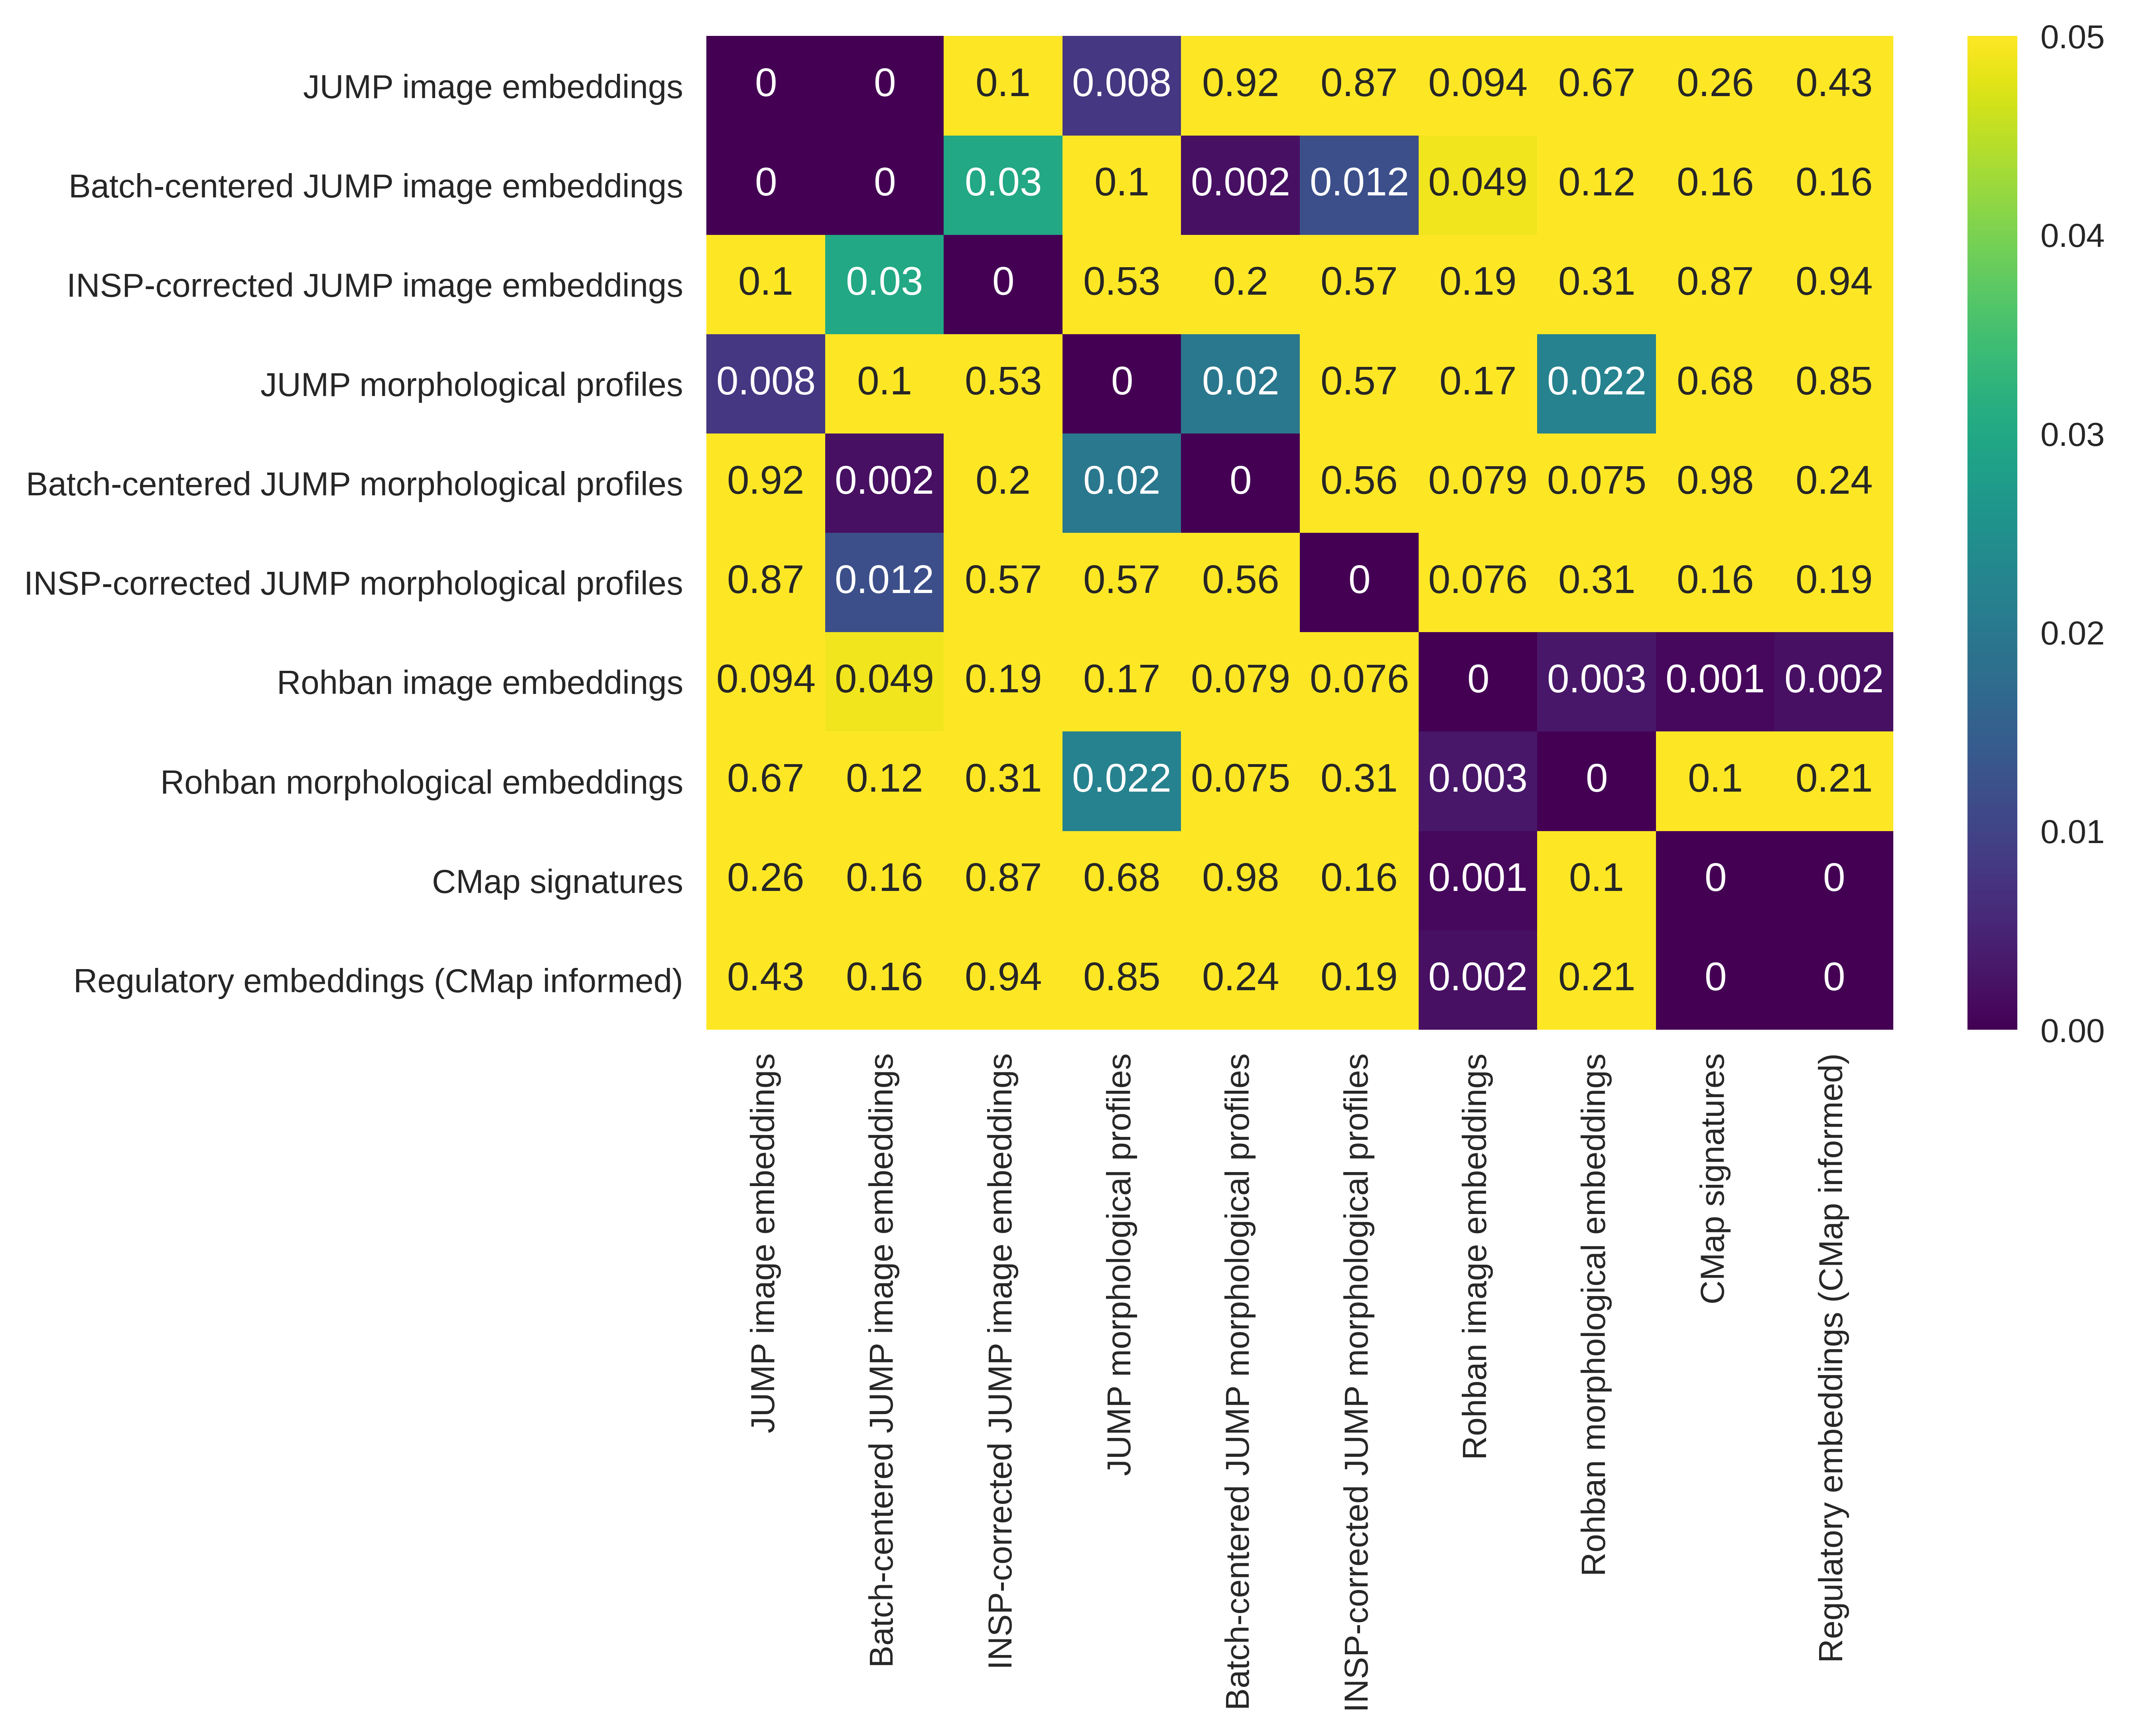

<IPython.core.display.Javascript object>

In [42]:
sns.heatmap(pval_df, annot=True, vmax=0.05, cmap="viridis")

The plot above shows one reason for the current challenges of predicting unseen overexpression conditions in the new data set. The different batch effect removal approaches seem to either not fully remove these confounding effects or no show much similarity of the with what we had observed in the study of Rohban et al.

---

# Co-clustering of the training and test conditions

The second factor contributing to the difficulty of our validation task is that we aim to predict 144 OE conditions out of sample given only 31 OE conditions for the training set. For this to work the 31 shared conditions need to span sufficiently much of both the space that describes the chromatin organization of cells in the different OE conditions as well as the regulatory gene embedding space. This is because, the methods will not predict outside of the span of the training data.

To check how many of the regulatory gene embeddings of the gene targeted for OE in the test condition fall within the space of those from the train conditions, we will cluster the whole regulatory gene embedding space and assess how often the gene targets of the train and test conditions co-cluster.

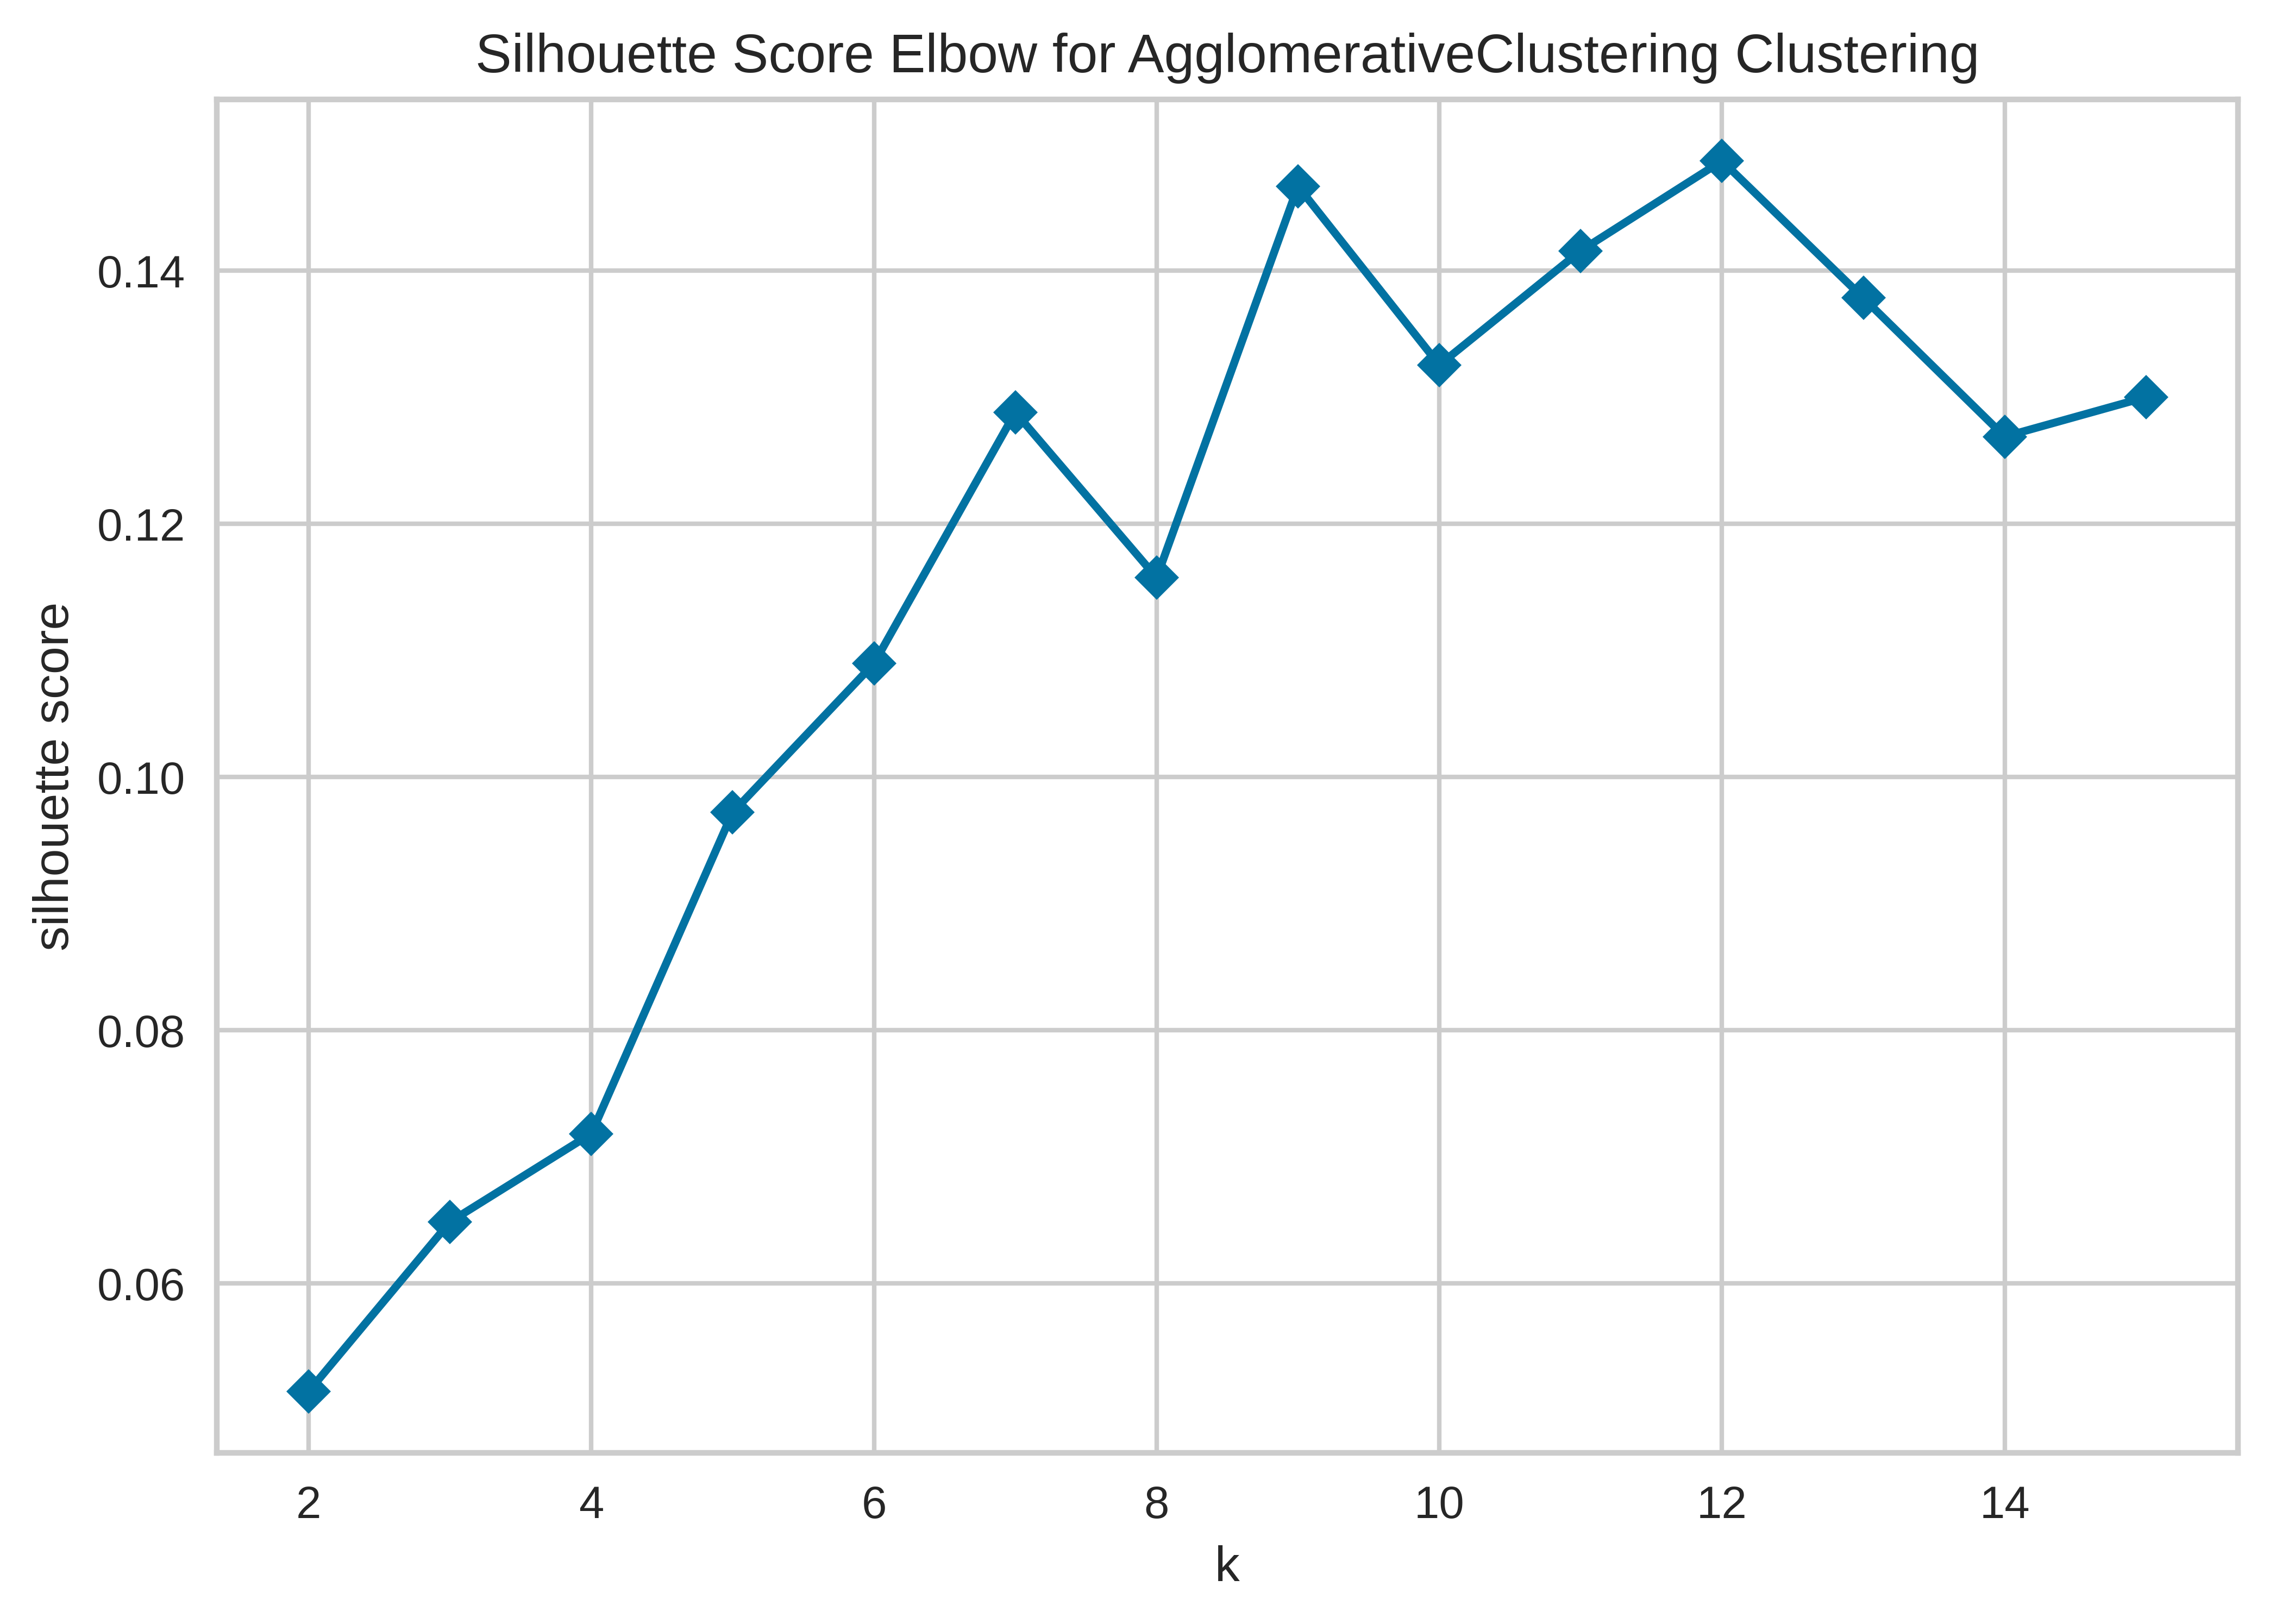

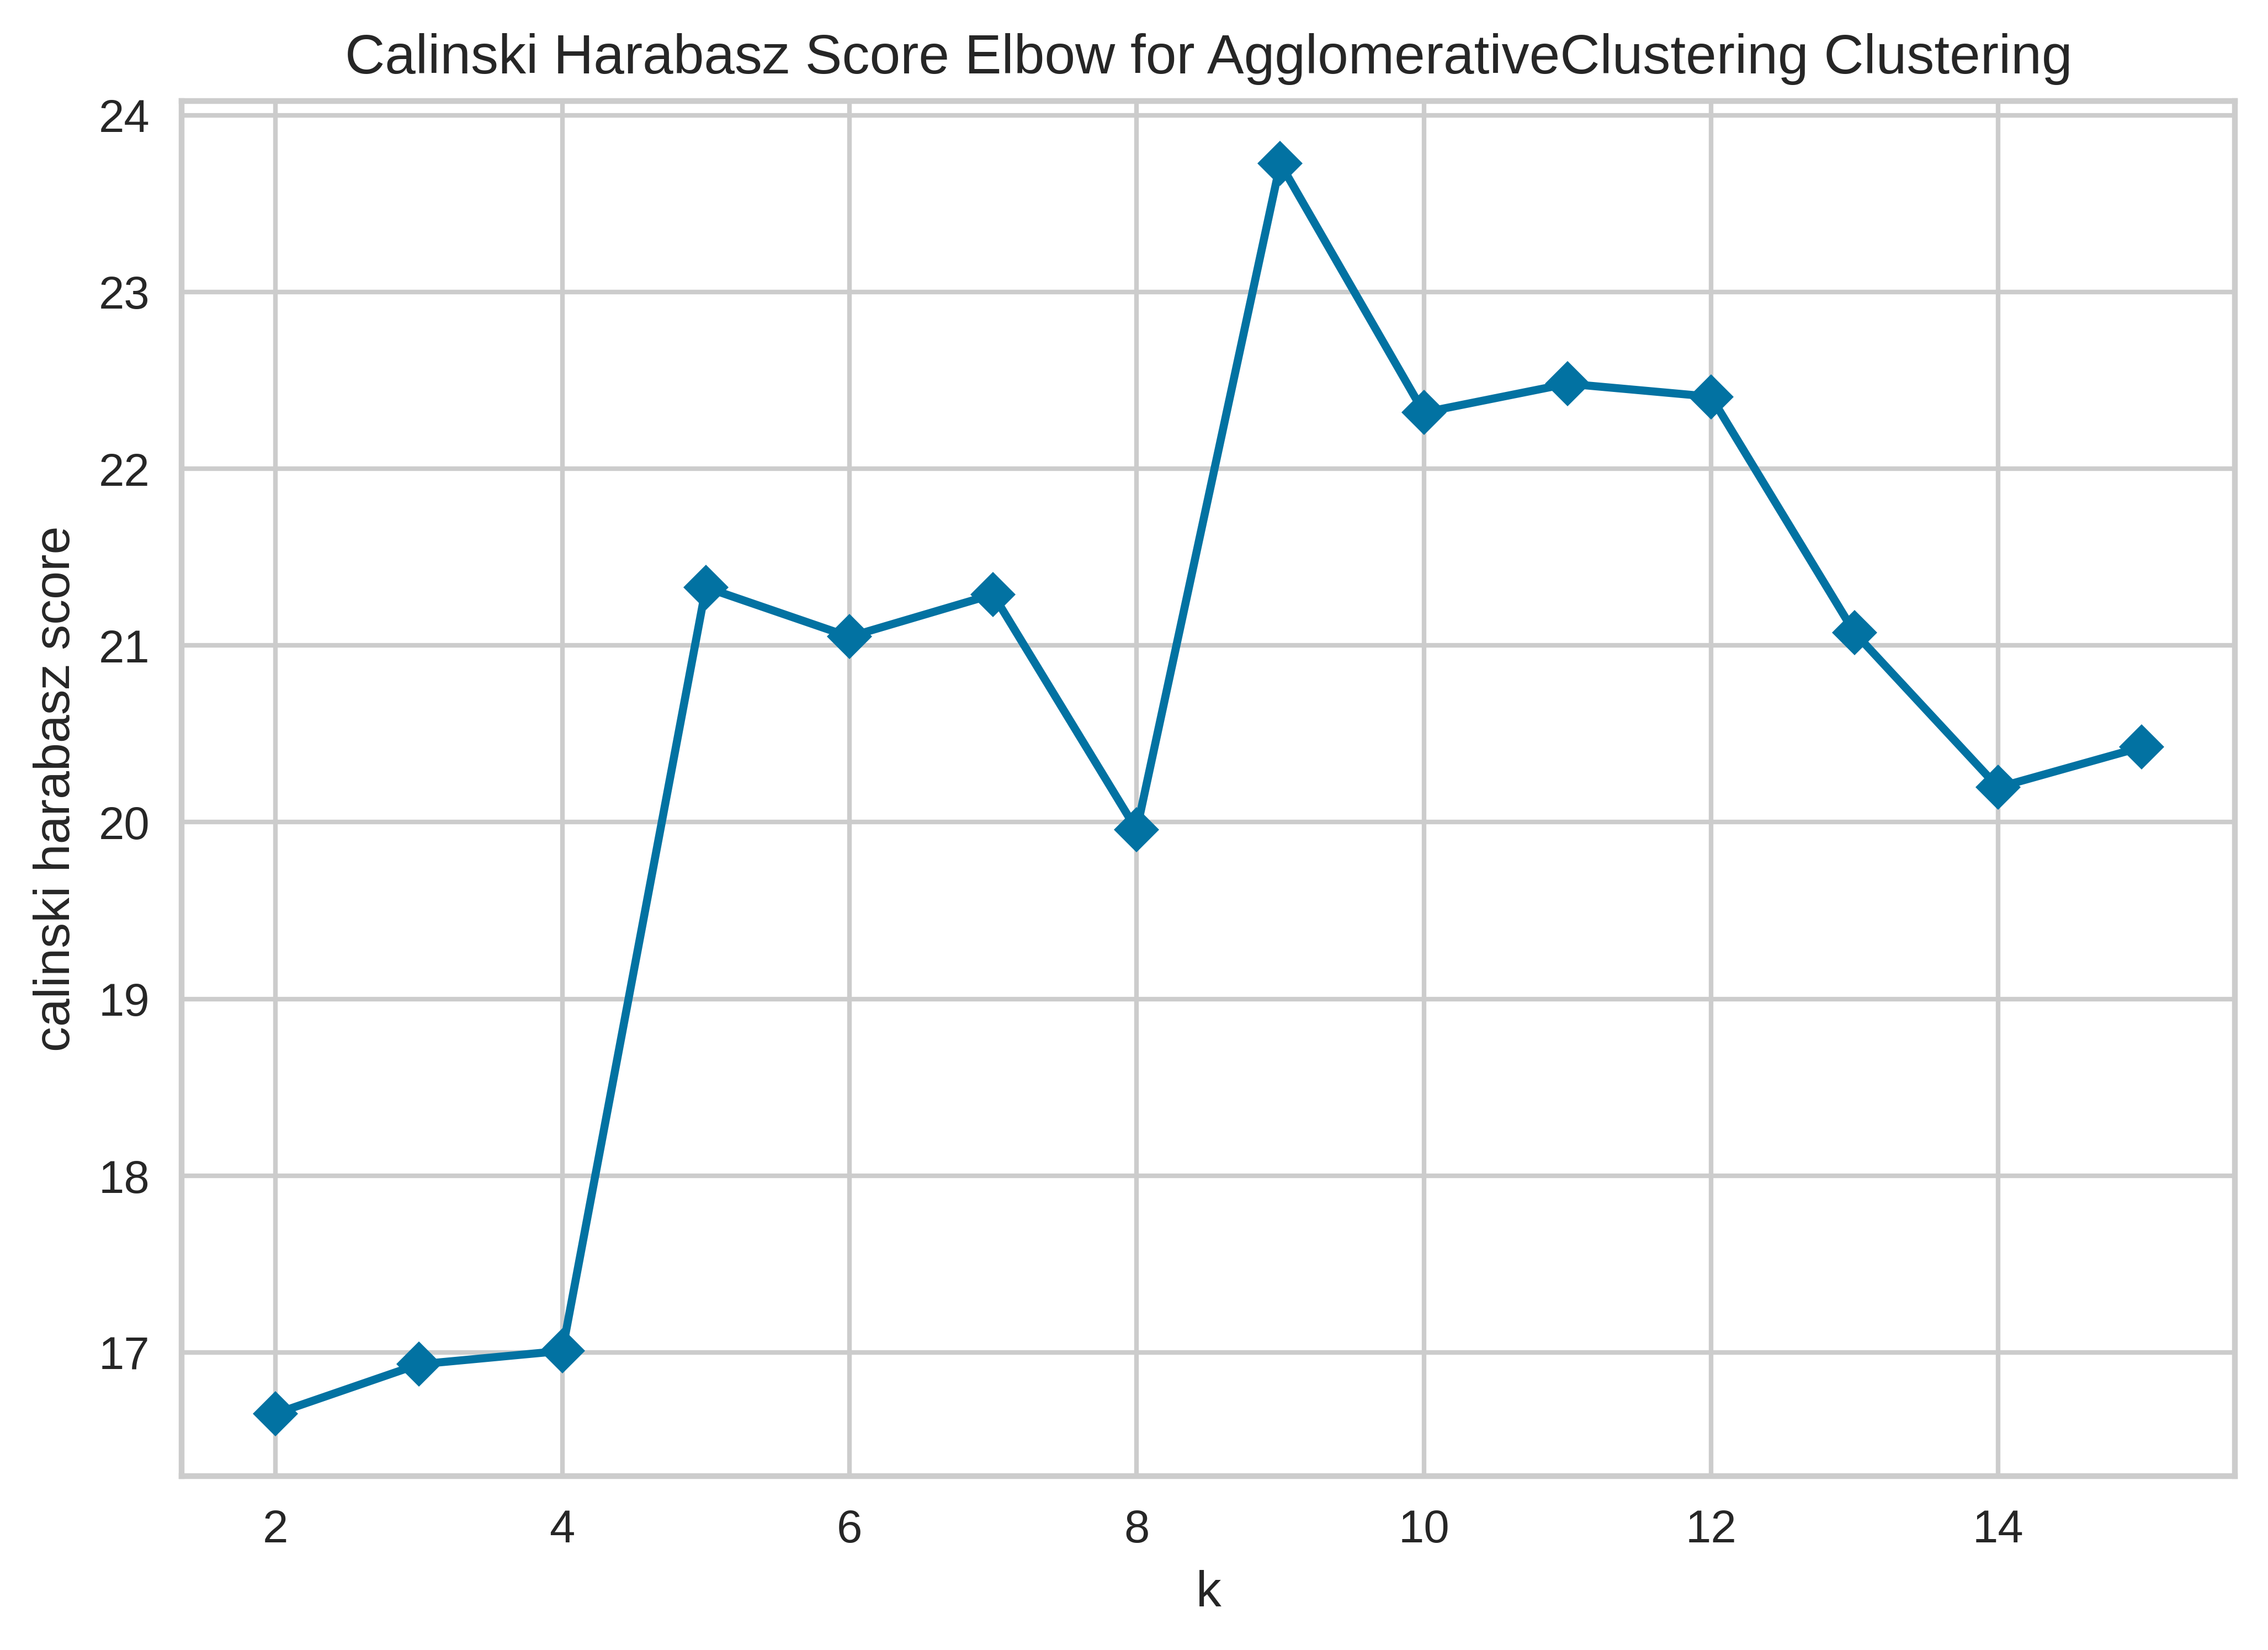

<IPython.core.display.Javascript object>

In [43]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(reg_embs)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(reg_embs)
ax = visualizer.show()


The optimal number of cluster seems to be 9 for our batch-centered JUMP morphological profiles.

In [44]:
model = AgglomerativeClustering(n_clusters=9, affinity="cosine", linkage="complete")
reg_embs_cluster_labels = model.fit_predict(reg_embs)
reg_embs_clusters = pd.DataFrame(
    reg_embs_cluster_labels,
    index=reg_embs.index,
    columns=["cluster"],
)
reg_embs_clusters.head()

cluster
PTN          5
KLK6         1
AURKB        0
TRAF2        6
TNNC1        0

<IPython.core.display.Javascript object>

Having identified the clusters, as discussed above we now assess how often the train and test conditions co-cluster.

In [45]:
train_genes = shared_genes
test_genes = list(set(jump_img_embs.index) - set(train_genes) - {"EMPTY"})

<IPython.core.display.Javascript object>

In [46]:
cluster_occ = {"cluster": [], "geneset": [], "n_gs_genes": [], "n_genes": []}
for cluster in np.unique(reg_embs_clusters.cluster):
    cluster_genes = set(
        reg_embs_clusters.loc[reg_embs_clusters.cluster == cluster].index
    )
    for geneset in ["train", "test"]:
        if geneset == "train":
            gs_genes = set(train_genes)
        elif geneset == "test":
            gs_genes = set(test_genes)
        cluster_occ["cluster"].append(cluster)
        cluster_occ["n_gs_genes"].append(len(gs_genes.intersection(cluster_genes)))
        cluster_occ["n_genes"].append(len(cluster_genes))
        cluster_occ["geneset"].append(geneset)

cluster_occ = pd.DataFrame(cluster_occ)

<IPython.core.display.Javascript object>

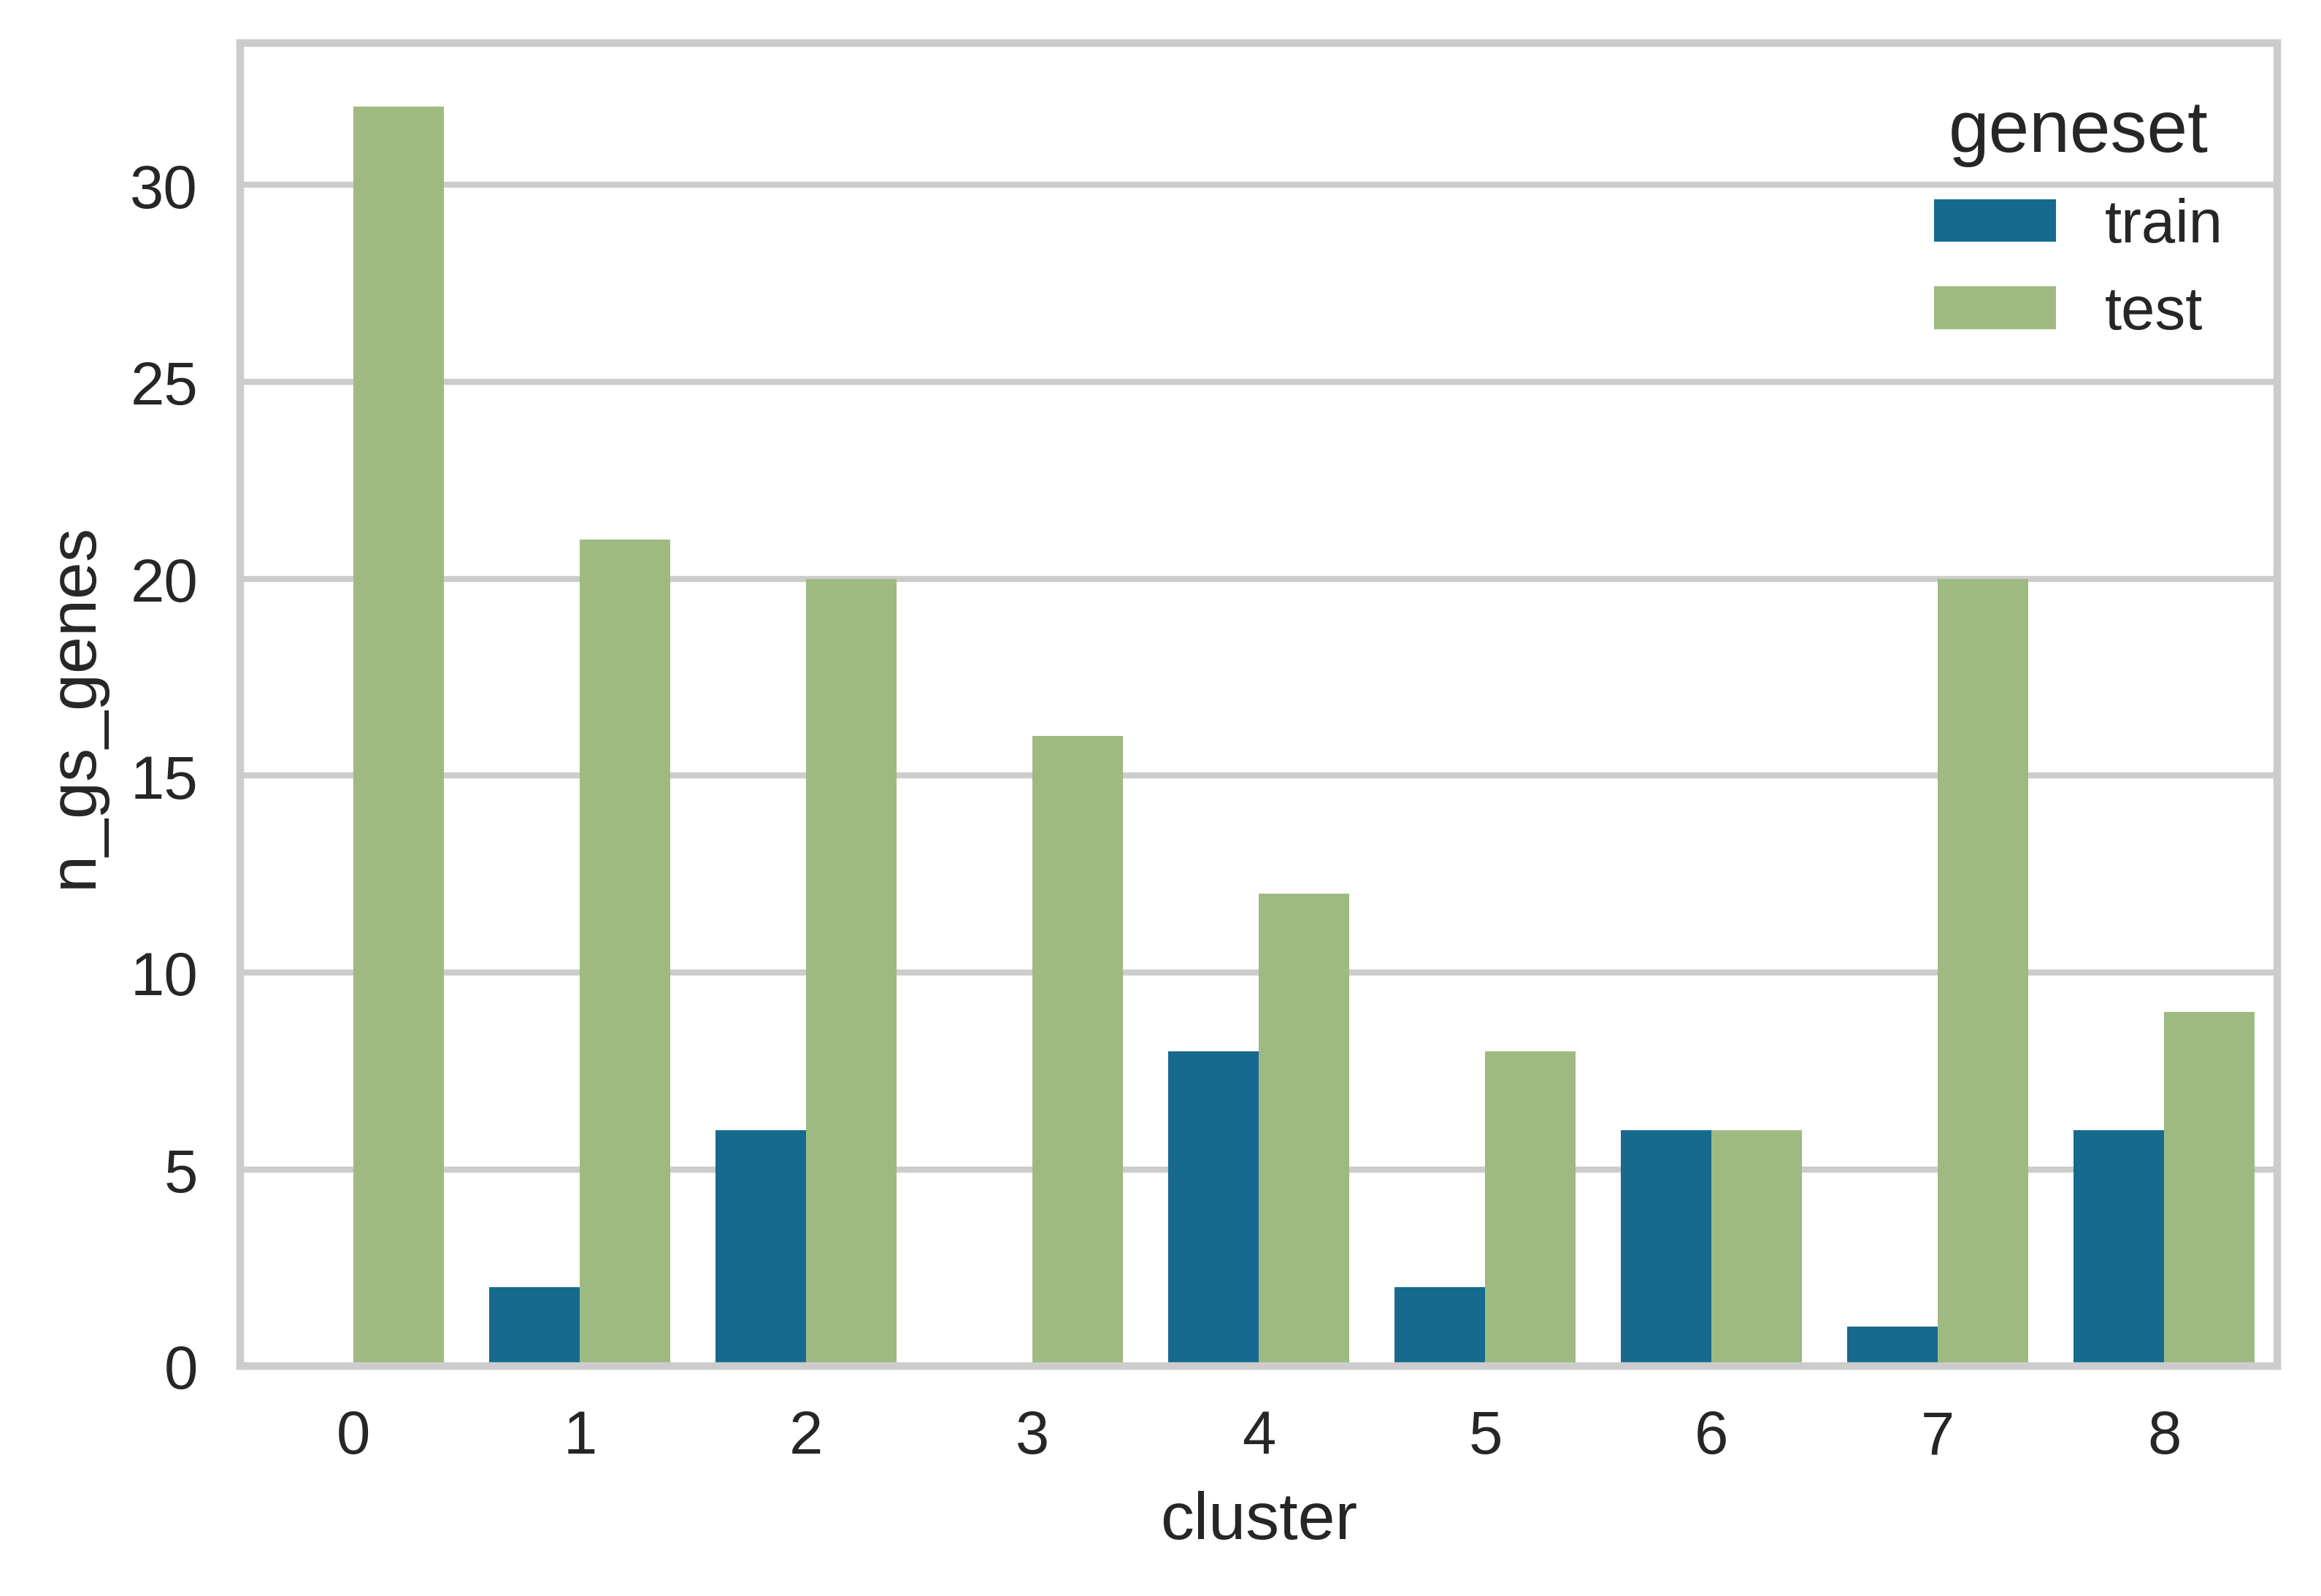

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.barplot(data=cluster_occ, x="cluster", y="n_gs_genes", hue="geneset")

The above plot highlights the difficulty of our validation task, where you see to have only small number of training conditions compared to the test conditions. While for the clusters 4, 6 and 8 the imbalance between train and test samples is not that large, for the clusters 0, 1, 3, and 7 we observe a huge imbalance with for cluster 0 and 3 no training conditions being covered in the clusters. As a consequence it seems unlikely for any model to ever output a prediction close to any member of cluster 0 and 1. To get a better idea of the similarity of these cluster, we will plot a tSNE plot for the regulatory embeddings and highlight the clusters as well as the train and test genes.

In [57]:
from sklearn.preprocessing import normalize

mapper = TSNE(
    perplexity=int(np.sqrt(len(reg_embs))) + 1,
    random_state=1234,
    init="pca",
    learning_rate="auto",
    metric="euclidean",
    square_distances=True,
)
embs = mapper.fit_transform(normalize(reg_embs))
embs = pd.DataFrame(embs, index=reg_embs.index, columns=["tSNE 1", "tSNE 2"])
embs["Cluster"] = np.array(reg_embs_clusters.loc[embs.index, "cluster"])
embs["Gene set"] = "Other"
embs.loc[train_genes, "Gene set"] = "Training conditions"
embs.loc[test_genes, "Gene set"] = "Possible test conditions"
embs.Cluster = np.array(embs.Cluster).astype(object)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

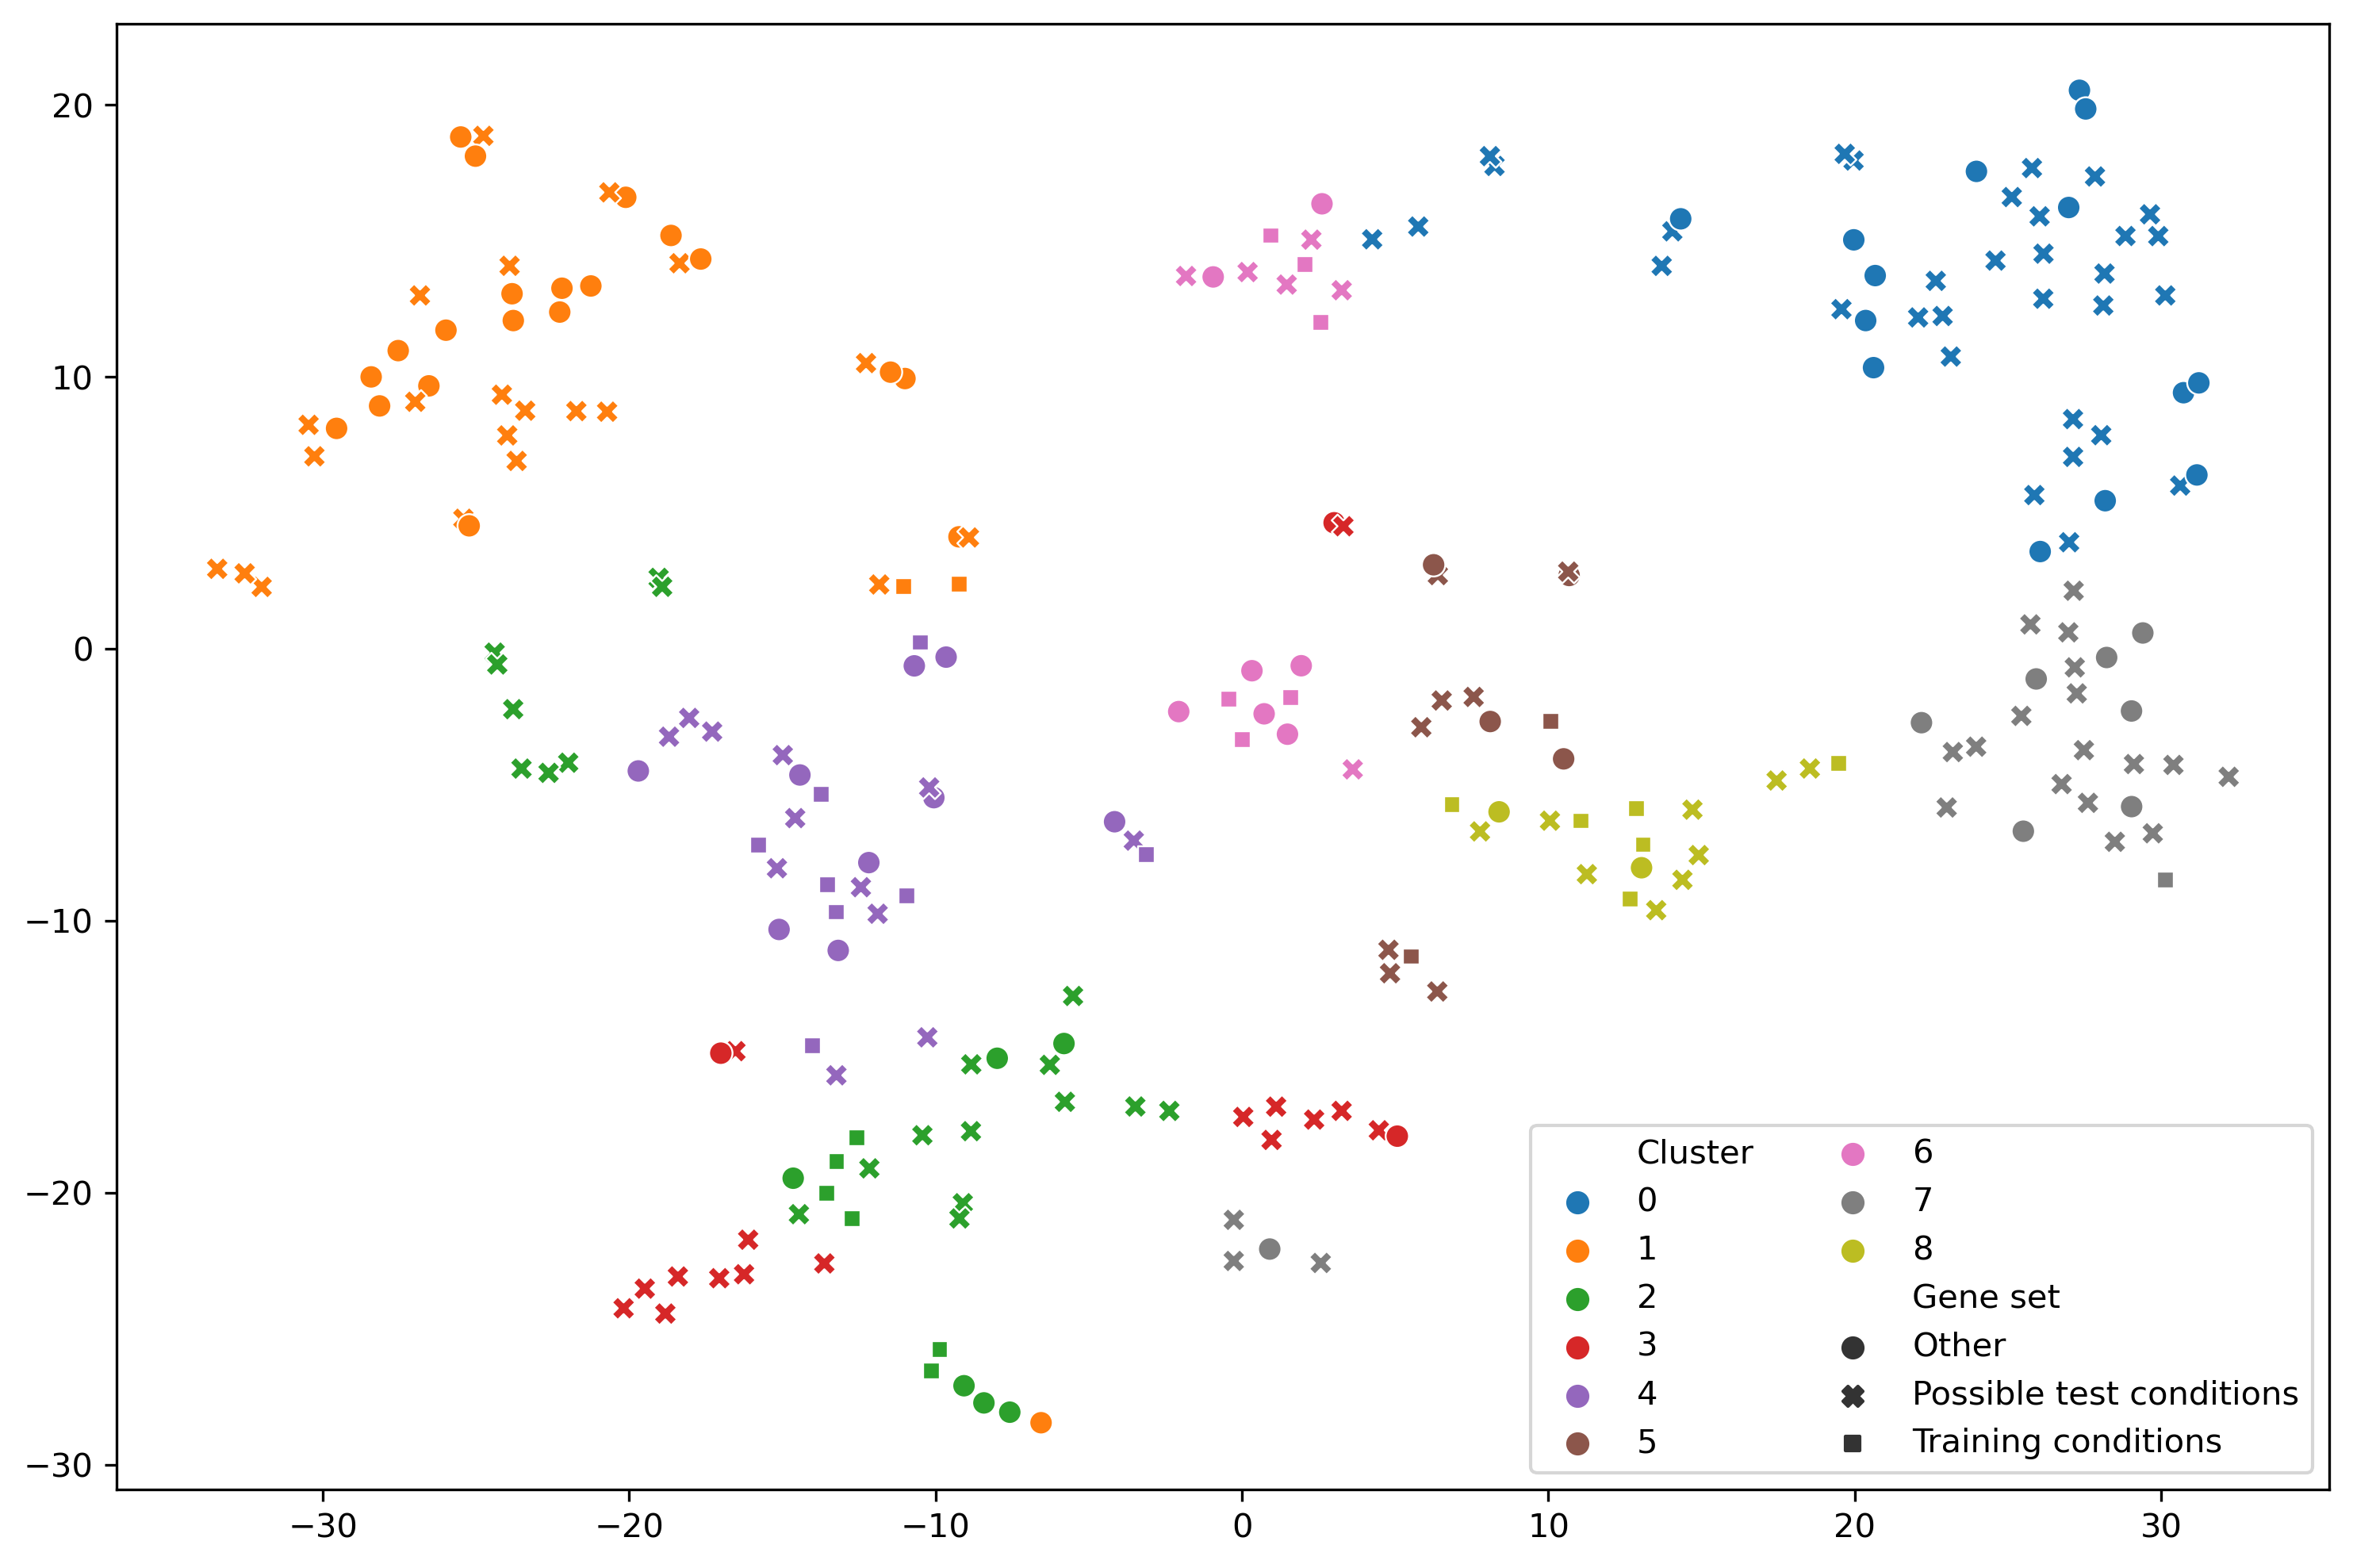

<IPython.core.display.Javascript object>

In [69]:
plt.style.use("default")
mpl.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(figsize=[12, 8])
ax = sns.scatterplot(
    data=embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="Cluster",
    style="Gene set",
    palette="tab10",
    s=50,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(ncol=2)

While the tSNE plot obviously not perfectly represents the data distribution, we still observe that in particular the test conditions with gene targets falling into cluster 0, 1 and 7 will be very hard to predict there no or only very few not well distributed training samples are available for these clusters. Unfortunately, these 3 clusters combine for roughly 50% of the overall test conditions.